In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from scipy import stats
import geopandas as gpd
import plotly.express as px
import nbformat
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Polygon
from scipy.stats import linregress
import openpyxl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
# Step 1: Load data from Excel file
file_path = r'Resources/Wine_Country_Weather_Data_adj.xlsx' 
wine_country_weather_data_df = pd.read_excel(file_path, sheet_name='Table')

# Step 2: Display the first few rows of the DataFrame to verify loading
wine_country_weather_data_df.head()

Continent Region/Country Product     Variable  Year     Unit  Quantity  \
0      Asia    Afghanistan    Wine  Consumption  1995  1000 hl         0   
1      Asia    Afghanistan    Wine      Imports  1995  1000 hl         0   
2      Asia    Afghanistan    Wine   Production  1995  1000 hl         0   
3      Asia    Afghanistan    Wine  Consumption  1996  1000 hl         0   
4      Asia    Afghanistan    Wine      Imports  1996  1000 hl         0   

  Country_Code  DP10  DP1X  ...  DX90  EMNT  EMXP  EMXT  HTDD  MNPN  MXPN  \
0           AF     0     0  ...     0   0.0   0.0   0.0     0     0     0   
1           AF     0     0  ...     0   0.0   0.0   0.0     0     0     0   
2           AF     0     0  ...     0   0.0   0.0   0.0     0     0     0   
3           AF     0     0  ...     0   0.0   0.0   0.0     0     0     0   
4           AF     0     0  ...     0   0.0   0.0   0.0     0     0     0   

   PRCP  TAVG  TMAX  
0   0.0   0.0   0.0  
1   0.0   0.0   0.0  
2   0.0   0.0   0.0  
3   0.0   0.0   0.0  
4   0.0   0.0   0.0  

[5 rows x 22 columns]

In [3]:
# Load data from Excel file
file_path = r'Resources/Wine_Country_Weather_Data_adj.xlsx' 
glossary_df = pd.read_excel(file_path, sheet_name='Glossary')

# Adjust display options to show entire strings
pd.set_option('display.max_colwidth', 60)

# Display the first few rows of the glossary dataframe
glossary_df

DataType                                                   Definition
0      DP10                              Number of days with >= 0.1 inch
1      DP1X                             Number of days with >= 1.00 inch
2      DT32  Number of days with maximum temperature <= 32 degrees Fa...
3      DX70  Number of days with maximum temperature >= 70 degrees Fa...
4      DX90  Number of days with maximum temperature >= 90 degrees Fa...
5      EMNT  Extreme minimum temperature for month. Lowest daily mini...
6      EMXP  Highest daily total of precipitation in the month. Given...
7      EMXT  Extreme maximum temperature for month. Highest daily max...
8      HTDD  Heating Degree Days. Computed when daily average tempera...
9      MNPN  Monthly Mean Minimum Temperature of evaporation pan wate...
10     MXPN  Monthly Mean Maximum Temperature of evaporation pan wate...
11     PRCP   Total Monthly Precipitation. Given in inches or millime...
12     TAVG  Average Monthly Temperature. Computed by adding the unro...
13     TMAX  Monthly Maximum Temperature. Average of daily maximum te...

In [4]:
# Convert quantity from 1000hl to gallons
# Assuming the quantity column is named 'quantity' and it is in '1000hl'
# 1 hectoliter (hl) is approximately 26.4172 gallons
# Therefore, 1000 hl is 1000 * 26.4172 gallons

conversion_factor = 26.4172
wine_country_weather_data_df['Quantity_gallons'] = wine_country_weather_data_df['Quantity'].astype(float) * 1000 * conversion_factor

# Reorder columns to place 'Gallons' right after 'Quantity'
columns = list(wine_country_weather_data_df.columns)
quantity_index = columns.index('Quantity')
columns.insert(quantity_index + 1, columns.pop(columns.index('Quantity_gallons')))
wine_country_weather_data_final_df = wine_country_weather_data_df[columns]

# Remove blank records where country_Country_Country_code is blank
wine_country_weather_data_final_df = wine_country_weather_data_final_df[wine_country_weather_data_final_df['Country_Code'].notna()].reset_index(drop=True)


# Display the modified dataframe
# print(wine_country_weather_data_final_df.head())
wine_country_weather_data_final_df.head()

Continent Region/Country Product     Variable  Year     Unit  Quantity  \
0      Asia    Afghanistan    Wine  Consumption  1995  1000 hl         0   
1      Asia    Afghanistan    Wine      Imports  1995  1000 hl         0   
2      Asia    Afghanistan    Wine   Production  1995  1000 hl         0   
3      Asia    Afghanistan    Wine  Consumption  1996  1000 hl         0   
4      Asia    Afghanistan    Wine      Imports  1996  1000 hl         0   

   Quantity_gallons Country_Code  DP10  ...  DX90  EMNT  EMXP  EMXT  HTDD  \
0               0.0           AF     0  ...     0   0.0   0.0   0.0     0   
1               0.0           AF     0  ...     0   0.0   0.0   0.0     0   
2               0.0           AF     0  ...     0   0.0   0.0   0.0     0   
3               0.0           AF     0  ...     0   0.0   0.0   0.0     0   
4               0.0           AF     0  ...     0   0.0   0.0   0.0     0   

   MNPN  MXPN  PRCP  TAVG  TMAX  
0     0     0   0.0   0.0   0.0  
1     0     0   0.0   0.0   0.0  
2     0     0   0.0   0.0   0.0  
3     0     0   0.0   0.0   0.0  
4     0     0   0.0   0.0   0.0  

[5 rows x 23 columns]

Total wine production for all countries combined from 1995 to 2023

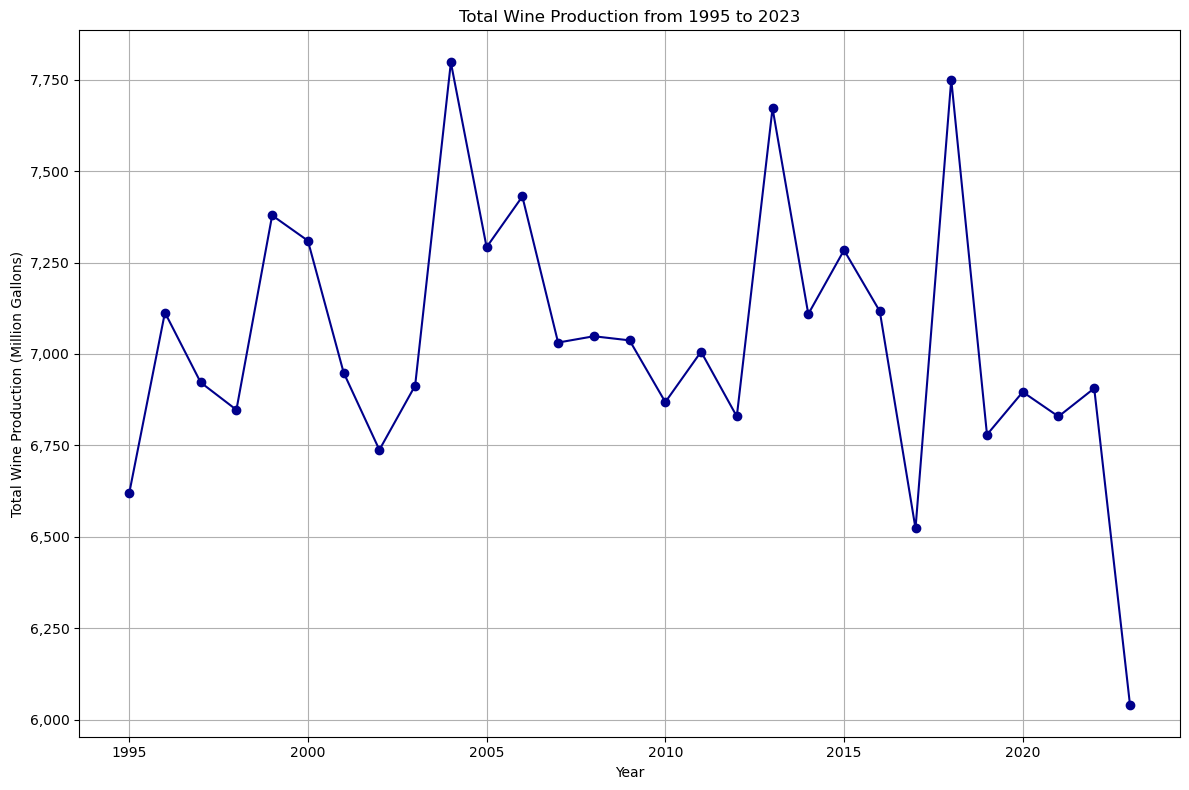

<Figure size 640x480 with 0 Axes>

In [5]:
# Filter the data to include only wine production records
wine_production_df = wine_country_weather_data_final_df[wine_country_weather_data_final_df['Variable'] == 'Production']
wine_production_path = 'Outputs/Wine_data_all_Production.csv'
wine_production_df.to_csv(wine_production_path, index=False)
# Group by Year and sum the Quantity_gallons
wine_production_by_year = wine_production_df.groupby('Year')['Quantity_gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_year['Quantity_gallons_million'] = wine_production_by_year['Quantity_gallons'] / 1e6

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Create the line plot
plt.figure(figsize=(12, 8))
plt.plot(wine_production_by_year['Year'], wine_production_by_year['Quantity_gallons_million'], marker='o', linestyle='-', color='darkblue')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Total Wine Production (Million Gallons)')
plt.title('Total Wine Production from 1995 to 2023')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Figures/WineProduction1995-2023.png')

In [6]:
wine_production_df

Continent Region/Country Product    Variable  Year     Unit  Quantity  \
2          Asia    Afghanistan    Wine  Production  1995  1000 hl         0   
5          Asia    Afghanistan    Wine  Production  1996  1000 hl         0   
8          Asia    Afghanistan    Wine  Production  1997  1000 hl         0   
11         Asia    Afghanistan    Wine  Production  1998  1000 hl         0   
14         Asia    Afghanistan    Wine  Production  1999  1000 hl         0   
...         ...            ...     ...         ...   ...      ...       ...   
19045    Africa       Zimbabwe    Wine  Production  2018  1000 hl        20   
19049    Africa       Zimbabwe    Wine  Production  2019  1000 hl        14   
19053    Africa       Zimbabwe    Wine  Production  2020  1000 hl        14   
19057    Africa       Zimbabwe    Wine  Production  2021  1000 hl        14   
19061    Africa       Zimbabwe    Wine  Production  2022  1000 hl        14   

       Quantity_gallons Country_Code  DP10  ...  DX90  EMNT  EMXP  EMXT  HTDD  \
2                   0.0           AF     0  ...     0   0.0   0.0   0.0     0   
5                   0.0           AF     0  ...     0   0.0   0.0   0.0     0   
8                   0.0           AF     0  ...     0   0.0   0.0   0.0     0   
11                  0.0           AF     0  ...     0   0.0   0.0   0.0     0   
14                  0.0           AF     0  ...     0   0.0   0.0   0.0     0   
...                 ...          ...   ...  ...   ...   ...   ...   ...   ...   
19045          528344.0           ZI     0  ...     0   0.0   0.0   0.0     0   
19049          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   
19053          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   
19057          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   
19061          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   

       MNPN  MXPN  PRCP  TAVG  TMAX  
2         0     0   0.0   0.0   0.0  
5         0     0   0.0   0.0   0.0  
8         0     0   0.0   0.0   0.0  
11        0     0   0.0   0.0   0.0  
14        0     0   0.0   0.0   0.0  
...     ...   ...   ...   ...   ...  
19045     0     0   0.0   0.0   0.0  
19049     0     0   0.0   0.0   0.0  
19053     0     0   0.0   0.0   0.0  
19057     0     0   0.0   0.0   0.0  
19061     0     0   0.0   0.0   0.0  

[5179 rows x 23 columns]

Map of total wine production by country in 1995

In [7]:
# Filter the data to include only wine production records and for the year 1995
wine_production_1995_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 1995)]

# Group by Region/Country and sum the Quantity_gallons
wine_production_1995_by_country = wine_production_1995_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Create the choropleth map
fig = px.choropleth(
    wine_production_1995_by_country,
    locations="Region/Country",
    locationmode="country names",
    color="Quantity_gallons",
    hover_name="Region/Country",
    color_continuous_scale=px.colors.sequential.OrRd,
    labels={'Quantity_gallons': 'Total Wine Production (Gallons)'},
    title='Total Wine Production by Country in 1995'
)

# Customize the layout
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Show the plot
fig.show()

Map of total wine production by country in 2023

In [8]:
#  Filter the data to include only wine production records and for the year 2023
wine_production_2023_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 2023)]

# Group by Region/Country and sum the Quantity_gallons
wine_production_2023_by_country = wine_production_2023_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Create the choropleth map
fig = px.choropleth(
    wine_production_2023_by_country,
    locations="Region/Country",
    locationmode="country names",
    color="Quantity_gallons",
    hover_name="Region/Country",
    color_continuous_scale=px.colors.sequential.OrRd,
    labels={'Quantity_gallons': 'Total Wine Production (Gallons)'},
    title='Total Wine Production by Country in 2023'
)

# Customize the layout
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Show the plot
fig.show()


# Question 1: Which were the top wine producing countries from year 1995?

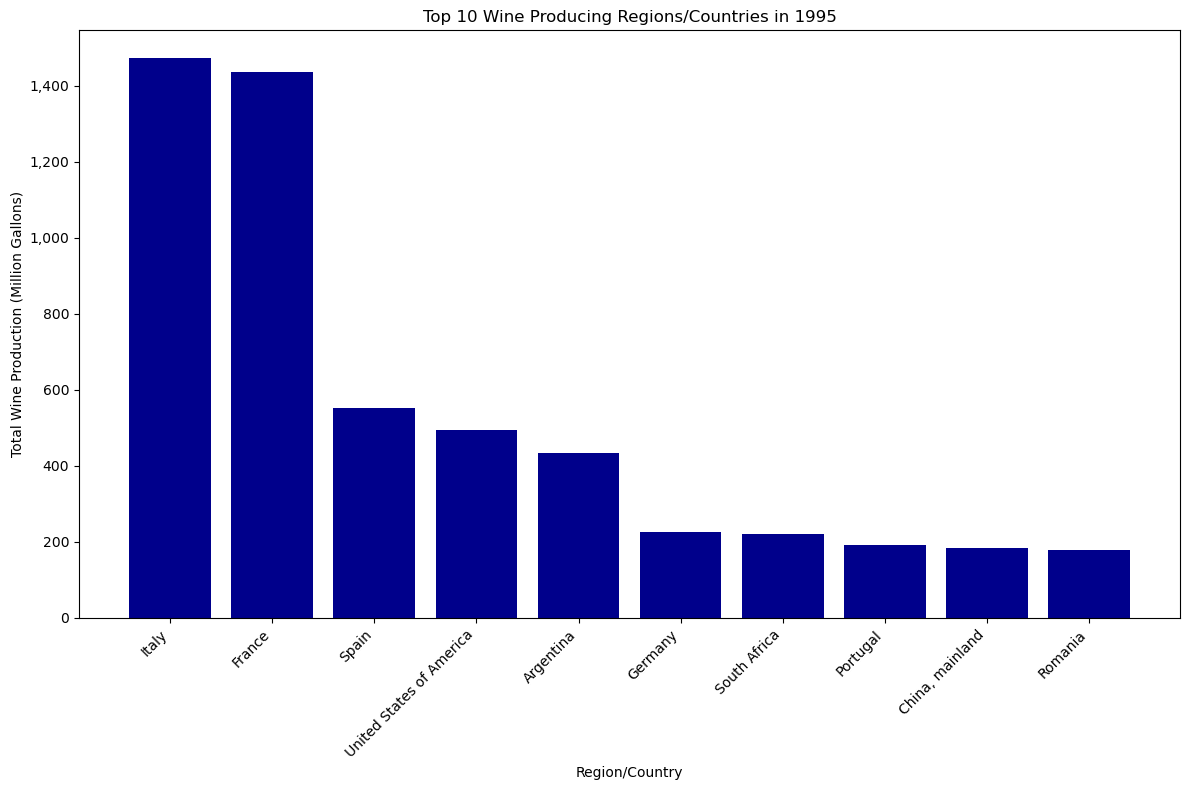

In [9]:
# Filter the data to include only wine production records and for the year 1995
wine_production_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 1995)]

# Group by Region/Country and sum the Quantity_gallons
wine_production_by_region = wine_production_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_region['Quantity_gallons_million'] = wine_production_by_region['Quantity_gallons'] / 1e6

# Sort the values in descending order and get the top 10
top_10_wine_producing_regions = wine_production_by_region.sort_values(by='Quantity_gallons_million', ascending=False).head(10)

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.bar(top_10_wine_producing_regions['Region/Country'], top_10_wine_producing_regions['Quantity_gallons_million'], color='darkblue')
plt.xlabel('Region/Country')
plt.ylabel('Total Wine Production (Million Gallons)')
plt.title('Top 10 Wine Producing Regions/Countries in 1995')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()  # Adjust layout to make room for rotated x labels
plt.show()

# Question 2: Which were the top wine producing countries from year 2023?

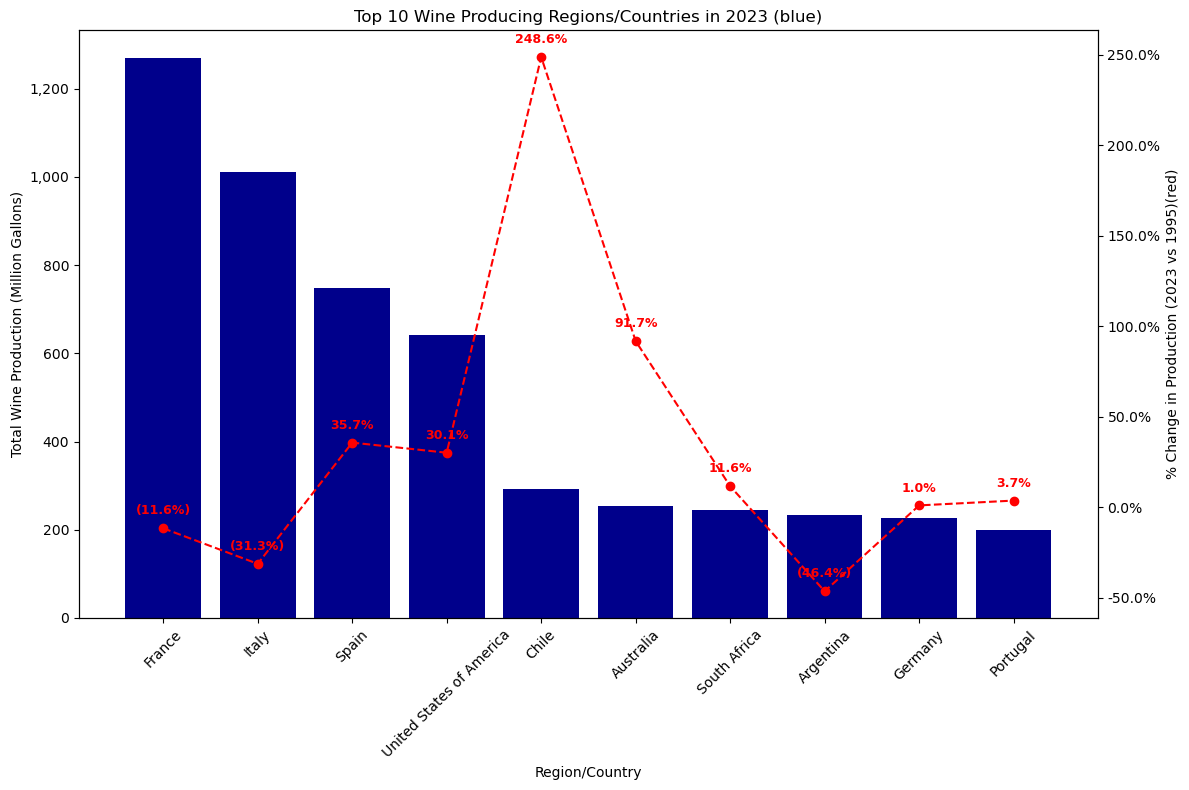

In [10]:
# Filter the data to include only wine production records and for the year 1995
wine_production_df_1995 = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 1995)]

# Filter the data to include only wine production records and for the year 2023
wine_production_df_2023 = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 2023)]

# Group by Region/Country and sum the Quantity_gallons for 1995 and 2023
wine_production_by_region_1995 = wine_production_df_1995.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()
wine_production_by_region_2023 = wine_production_df_2023.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Merge the two dataframes on Region/Country
wine_production_comparison = pd.merge(wine_production_by_region_1995, wine_production_by_region_2023, on='Region/Country', suffixes=('_1995', '_2023'))

# Calculate the percentage change
wine_production_comparison['Percentage_change'] = ((wine_production_comparison['Quantity_gallons_2023'] - wine_production_comparison['Quantity_gallons_1995']) / wine_production_comparison['Quantity_gallons_1995']) * 100

# Convert the Quantity_gallons_2023 to millions for plotting
wine_production_comparison['Quantity_gallons_2023_million'] = wine_production_comparison['Quantity_gallons_2023'] / 1e6

# Sort the values in descending order and get the top 10
top_10_wine_producing_regions = wine_production_comparison.sort_values(by='Quantity_gallons_2023_million', ascending=False).head(10)

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Define a function to format the percentage change values with one decimal place
def percentage_formatter(x, pos):
    return f'{x:,.1f}%'

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(top_10_wine_producing_regions['Region/Country'], top_10_wine_producing_regions['Quantity_gallons_2023_million'], color='darkblue')
ax1.set_xlabel('Region/Country')
ax1.set_ylabel('Total Wine Production (Million Gallons)')
ax1.set_title('Top 10 Wine Producing Regions/Countries in 2023 (blue)')
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.tick_params(axis='x', rotation=45)

# Create the secondary axis
ax2 = ax1.twinx()
ax2.plot(top_10_wine_producing_regions['Region/Country'], top_10_wine_producing_regions['Percentage_change'], color='red', marker='o', linestyle='--')
ax2.set_ylabel('% Change in Production (2023 vs 1995)(red)')
ax2.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Add data labels to the line graph
for i, txt in enumerate(top_10_wine_producing_regions['Percentage_change']):
    label = f'{txt:.1f}%' if txt >= 0 else f'({-txt:.1f}%)'
    ax2.annotate(label, (top_10_wine_producing_regions['Region/Country'].iloc[i], top_10_wine_producing_regions['Percentage_change'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red', fontweight='bold')

plt.tight_layout()  # Adjust layout to make room for rotated x labels
plt.show()

# 3. What is the correlation between temperature and wine production?


In [11]:
#Load wine data
# Filter the data to include only wine production records
wine_production_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production')]

# Group by Region/Country and sum the Quantity_gallons
wine_production_by_region = wine_production_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_region['Quantity_gallons_million'] = wine_production_by_region['Quantity_gallons'] / 1e6

wine_production_df

Continent Region/Country Product    Variable  Year     Unit  Quantity  \
2          Asia    Afghanistan    Wine  Production  1995  1000 hl         0   
5          Asia    Afghanistan    Wine  Production  1996  1000 hl         0   
8          Asia    Afghanistan    Wine  Production  1997  1000 hl         0   
11         Asia    Afghanistan    Wine  Production  1998  1000 hl         0   
14         Asia    Afghanistan    Wine  Production  1999  1000 hl         0   
...         ...            ...     ...         ...   ...      ...       ...   
19045    Africa       Zimbabwe    Wine  Production  2018  1000 hl        20   
19049    Africa       Zimbabwe    Wine  Production  2019  1000 hl        14   
19053    Africa       Zimbabwe    Wine  Production  2020  1000 hl        14   
19057    Africa       Zimbabwe    Wine  Production  2021  1000 hl        14   
19061    Africa       Zimbabwe    Wine  Production  2022  1000 hl        14   

       Quantity_gallons Country_Code  DP10  ...  DX90  EMNT  EMXP  EMXT  HTDD  \
2                   0.0           AF     0  ...     0   0.0   0.0   0.0     0   
5                   0.0           AF     0  ...     0   0.0   0.0   0.0     0   
8                   0.0           AF     0  ...     0   0.0   0.0   0.0     0   
11                  0.0           AF     0  ...     0   0.0   0.0   0.0     0   
14                  0.0           AF     0  ...     0   0.0   0.0   0.0     0   
...                 ...          ...   ...  ...   ...   ...   ...   ...   ...   
19045          528344.0           ZI     0  ...     0   0.0   0.0   0.0     0   
19049          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   
19053          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   
19057          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   
19061          369840.8           ZI     0  ...     0   0.0   0.0   0.0     0   

       MNPN  MXPN  PRCP  TAVG  TMAX  
2         0     0   0.0   0.0   0.0  
5         0     0   0.0   0.0   0.0  
8         0     0   0.0   0.0   0.0  
11        0     0   0.0   0.0   0.0  
14        0     0   0.0   0.0   0.0  
...     ...   ...   ...   ...   ...  
19045     0     0   0.0   0.0   0.0  
19049     0     0   0.0   0.0   0.0  
19053     0     0   0.0   0.0   0.0  
19057     0     0   0.0   0.0   0.0  
19061     0     0   0.0   0.0   0.0  

[5179 rows x 23 columns]

In [12]:
# Drop unnecessary columns
import pandas as pd

# Get all columns up to and including 'Country_Code'
columns_to_keep = wine_production_df.columns[:wine_production_df.columns.get_loc('Country_Code') + 1]

# Select only the columns to keep
wine_data_df= wine_production_df[columns_to_keep]
wine_data_df_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_data_df.to_csv(wine_data_df_path, index=False)

# Print the modified DataFrame
print(wine_data_df)

      Continent Region/Country Product    Variable  Year     Unit  Quantity  \
2          Asia    Afghanistan    Wine  Production  1995  1000 hl         0   
5          Asia    Afghanistan    Wine  Production  1996  1000 hl         0   
8          Asia    Afghanistan    Wine  Production  1997  1000 hl         0   
11         Asia    Afghanistan    Wine  Production  1998  1000 hl         0   
14         Asia    Afghanistan    Wine  Production  1999  1000 hl         0   
...         ...            ...     ...         ...   ...      ...       ...   
19045    Africa       Zimbabwe    Wine  Production  2018  1000 hl        20   
19049    Africa       Zimbabwe    Wine  Production  2019  1000 hl        14   
19053    Africa       Zimbabwe    Wine  Production  2020  1000 hl        14   
19057    Africa       Zimbabwe    Wine  Production  2021  1000 hl        14   
19061    Africa       Zimbabwe    Wine  Production  2022  1000 hl        14   

       Quantity_gallons Country_Code  
2           

### Prepare wine Production data to be joined with updated climate data

In [13]:
import pandas as pd

# Load the CSV file
file_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_data_df = pd.read_csv(file_path)

# Remove unnecessary columns
columns_to_remove = ['Variable', 'Continent', 'Product', 'Unit']
wine_data_df = wine_data_df.drop(columns=columns_to_remove)

# Rename columns
columns_to_rename = {
    'Region/Country': 'Country',
    'Quantity': 'Quantity_hl',
    'Quantity_gallons': 'Gallons',
    'Country_Code': 'code'
}
wine_data_df = wine_data_df.rename(columns=columns_to_rename)

# Save the cleaned DataFrame to a new CSV file
cleaned_file_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_data_df.to_csv(cleaned_file_path, index=False)

# Display the cleaned DataFrame
print(wine_data_df.head())



       Country  Year  Quantity_hl  Gallons code
0  Afghanistan  1995            0      0.0   AF
1  Afghanistan  1996            0      0.0   AF
2  Afghanistan  1997            0      0.0   AF
3  Afghanistan  1998            0      0.0   AF
4  Afghanistan  1999            0      0.0   AF


### Clean and pivot climate data tables to one record for each station / year

In [14]:
import pandas as pd

# Load the Weather Data
file_path = 'Resources/weather_all_country_codes3.csv'
df = pd.read_csv(file_path)

# Convert date to just the year
df['date'] = pd.to_datetime(df['date']).dt.year

# Pivot the Weather DataFrame
pivoted_df = df.pivot_table(index=['station', 'date'], columns='datatype', values='value').reset_index()

# Load the Station Codes Data
file_path_txt = 'Resources/stationcodes.txt'
column_names = ['station_id', 'latitude', 'longitude', 'elevation', 'location']
colspecs = [(0, 11), (12, 20), (21, 30), (31, 37), (38, None)]
df_station_codes = pd.read_fwf(file_path_txt, colspecs=colspecs, header=None, names=column_names)

# Rename Columns for Merging
df_station_codes.rename(columns={'station_id': 'station'}, inplace=True)

# Clean Column Names
pivoted_df.columns = pivoted_df.columns.str.strip()
df_station_codes.columns = df_station_codes.columns.str.strip()

# Remove the 'GHCND:' prefix from the 'station' column in both DataFrames
pivoted_df['station'] = pivoted_df['station'].str.replace('GHCND:', '', regex=False)
df_station_codes['station'] = df_station_codes['station'].str.replace('GHCND:', '', regex=False)

# Update the 'code' values
pivoted_df['code'] = pivoted_df['station'].str[:2]

# Merge the DataFrames to add Lat, Long to weather data
merged_df = pd.merge(pivoted_df, df_station_codes, on='station', how='left')

# Export the merged DataFrame to a CSV file
output_file_path = 'Outputs/merged_weather_data.csv'
merged_df.to_csv(output_file_path, index=False)
print(f"Merged DataFrame exported to {output_file_path}")

# Display the merged DataFrame as a table
print("Merged DataFrame:")
print(merged_df.head().to_string(index=False))

# Load the country codes data
country_file_path = 'Resources/fips-countries.csv'
country_df = pd.read_csv(country_file_path)

# Ensure the 'code' column exists in country_df
if 'code' not in country_df.columns:
    print("Error: 'code' column not found in country_df")
else:
    # Merge the weather data with country data using 'code'
    final_merged_df = pd.merge(merged_df, country_df, on='code', how='left')

    # Save the final merged DataFrame to a new CSV file
    final_output_path = 'Outputs/merged_weather_country_data_Station_year.csv'
    final_merged_df.to_csv(final_output_path, index=False)
    print(f"Final Merged DataFrame exported to {final_output_path}")

    # Display the first few rows of the final merged DataFrame as a table
    print("Final Merged DataFrame:")
    print(final_merged_df.head().to_string(index=False))


Merged DataFrame exported to Outputs/merged_weather_data.csv
Merged DataFrame:
    station  date  DP10  DP1X  DT32  DX70  DX90  EMNT  EMXP  EMXT  HTDD  MNPN  MXPN  PRCP  TAVG  TMAX code  latitude  longitude  elevation                                     location
AE000041196  2012   NaN   NaN   NaN 346.0 226.0   NaN   NaN 121.0   NaN   NaN   NaN   NaN   NaN  96.0   AE    25.333     55.517       34.0 SHARJAH INTER. AIRP            GSN     41196
AE000041196  2023   8.0   1.0   NaN   NaN   NaN   NaN  1.06   NaN   NaN   NaN   NaN  3.42   NaN   NaN   AE    25.333     55.517       34.0 SHARJAH INTER. AIRP            GSN     41196
AEM00041194  2004   4.0   0.0   NaN   NaN   NaN   NaN  0.90   NaN   NaN   NaN   NaN  2.31   NaN   NaN   AE    25.255     55.364       10.4 DUBAI INTL                             41194
AEM00041194  2006   7.0   1.0   NaN   NaN   NaN   NaN  1.77   NaN   NaN   NaN   NaN  4.08   NaN   NaN   AE    25.255     55.364       10.4 DUBAI INTL                             41194
A

### Begin Spatial analysis of wine regions to weather stations

       station  date  DP10  DP1X  DT32   DX70   DX90  EMNT  EMXP   EMXT  ...  \
0  AE000041196  2012   NaN   NaN   NaN  346.0  226.0   NaN   NaN  121.0  ...   
1  AE000041196  2023   8.0   1.0   NaN    NaN    NaN   NaN  1.06    NaN  ...   
2  AEM00041194  2004   4.0   0.0   NaN    NaN    NaN   NaN  0.90    NaN  ...   
3  AEM00041194  2006   7.0   1.0   NaN    NaN    NaN   NaN  1.77    NaN  ...   
4  AEM00041194  2010   5.0   1.0   NaN    NaN    NaN   NaN  3.15    NaN  ...   

   PRCP  TAVG  TMAX  code  latitude  longitude elevation  \
0   NaN   NaN  96.0    AE    25.333     55.517      34.0   
1  3.42   NaN   NaN    AE    25.333     55.517      34.0   
2  2.31   NaN   NaN    AE    25.255     55.364      10.4   
3  4.08   NaN   NaN    AE    25.255     55.364      10.4   
4  4.83   NaN   NaN    AE    25.255     55.364      10.4   

                                       location               country  \
0  SHARJAH INTER. AIRP            GSN     41196  United Arab Emirates   
1  SHARJAH I

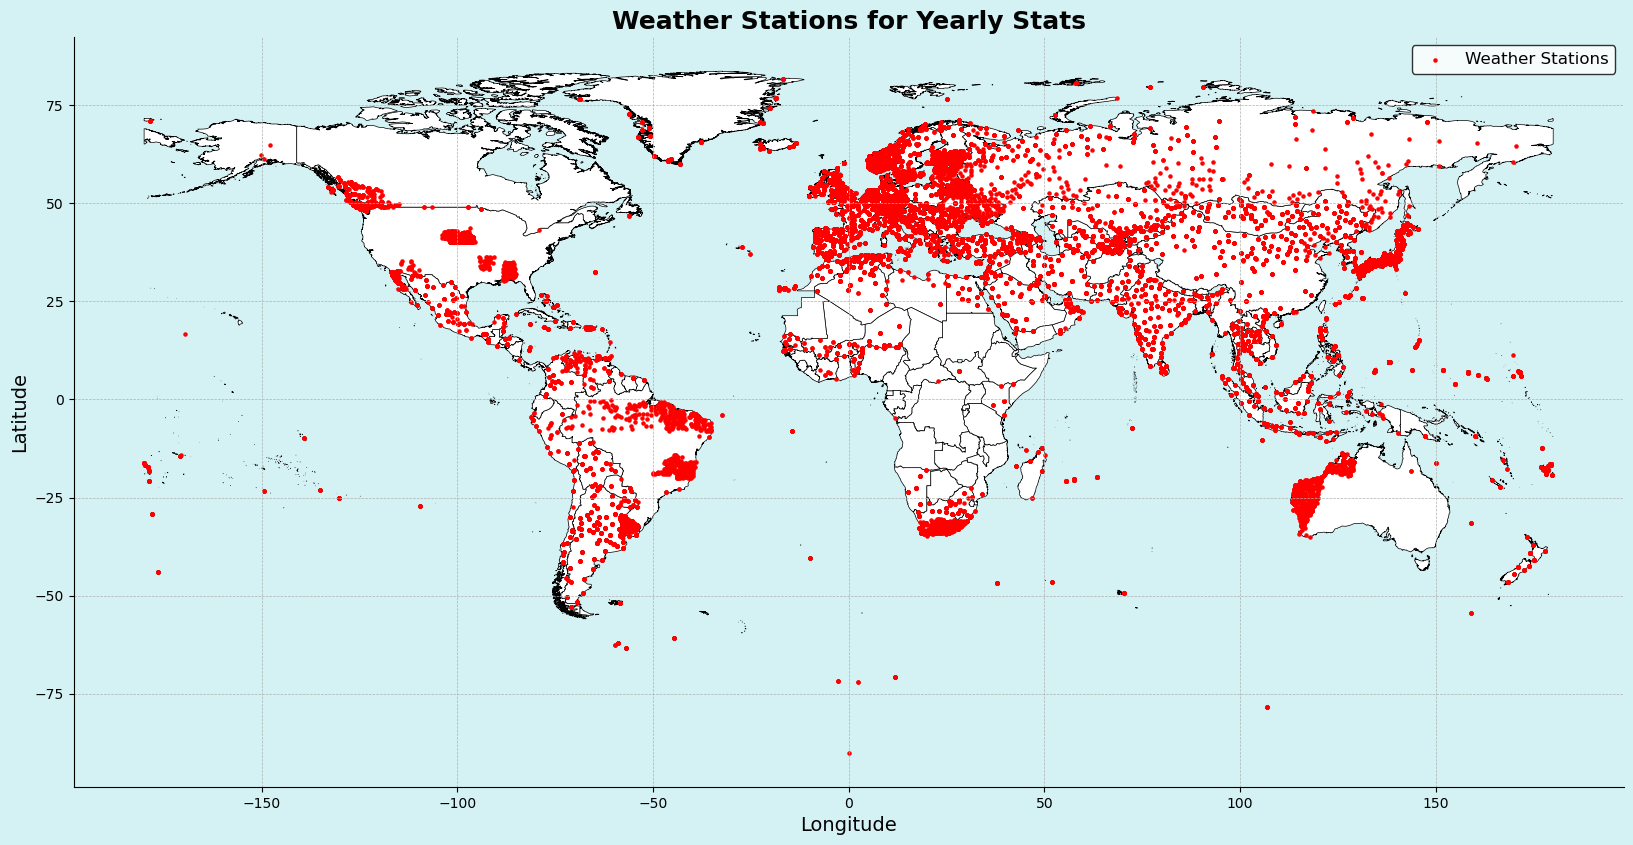

In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Polygon

font_family = "sans"
background_color = "#D4F1F4"
text_color = "#040303"

sns.set_style({
    "axes.facecolor": background_color,
    "figure.facecolor": background_color,
    "font.family": font_family,
    "text.color": text_color,
})

# Load the CSV file
csv_file_path = 'Outputs/merged_weather_country_data_Station_year.csv'
df = pd.read_csv(csv_file_path)

# Ensure the directory exists or create it
import os
save_dir = "Figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Create a GeoDataFrame from the CSV file
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Display the first few rows of the GeoDataFrame
print(gdf.head())

# Load the world map from the Natural Earth dataset
world_shapefile_path = 'Resources/Shapefiles/WB_countries_Admin0_10m.shp'
world = gpd.read_file(world_shapefile_path)

# Create the plot figure with the desired figsize
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Plot the world map with countries in white

world.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Plot the weather stations from the CSV
gdf.plot(ax=ax, color='red', markersize=5, label='Weather Stations')

# Add titles and labels
plt.title('Weather Stations for Yearly Stats', fontsize=18, fontweight='bold', color=text_color)
plt.xlabel('Longitude', fontsize=14, color=text_color)
plt.ylabel('Latitude', fontsize=14, color=text_color)

# Customize legend
plt.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white', edgecolor='black')

# Improve the overall aesthetics
ax.set_facecolor(background_color)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the figure with the correct file path
plt.savefig(os.path.join(save_dir, "Weather_Stations_all.png"))

# Display the plot
plt.show()



### Find stations within wine regions

In [16]:

from shapely.geometry import Polygon, Point
from shapely.ops import unary_union


# Load the shapefile
shapefile_path = 'Resources/Shapefiles/GlobalVineyards.shp'
gdf_shape = gpd.read_file(shapefile_path)


# Check for stations that did not get lat and long coordinates
stations_df = merged_df.dropna(subset=['latitude', 'longitude'])  # Drop rows with missing coordinates

# Create a GeoDataFrame from the weather station DataFrame
geometry = [Point(xy) for xy in zip(stations_df['longitude'], stations_df['latitude'])]
gdf_stations = gpd.GeoDataFrame(stations_df, geometry=geometry)

# Ensure the GeoDataFrame uses the same coordinate system
gdf_stations.crs = "EPSG:4326"

# Re-project both GeoDataFrames to a projected CRS suitable for distance calculations
projected_crs = "EPSG:3395"  # World Mercator projection
gdf_shape = gdf_shape.to_crs(projected_crs)
gdf_stations = gdf_stations.to_crs(projected_crs)

# Convert distance to meters (500 miles is approximately 804,670 meters)
buffer_distance = 804670  # 500 miles in meters

# Create a buffer around the shapefile geometries
shape_buffer = gdf_shape.geometry.buffer(buffer_distance)

# Combine all buffered shapes into a single geometry
combined_shape_buffer = unary_union(shape_buffer)

# Find weather stations within the buffer
stations_within_buffer = gdf_stations[gdf_stations.geometry.within(combined_shape_buffer)]

# Save the results to a new CSV file
output_file_path = 'Outputs/stations_within_100_miles.csv'
stations_within_buffer.to_csv(output_file_path, index=False)
print(f"Stations within 100 miles exported to {output_file_path}")

# Re-project back to geographic CRS for plotting
stations_within_buffer = stations_within_buffer.to_crs(epsg=4326)
shape_buffer_geo = gpd.GeoSeries([combined_shape_buffer], crs=projected_crs).to_crs(epsg=4326)

# Display the results
stations_within_buffer


Stations within 100 miles exported to Outputs/stations_within_100_miles.csv


station  date  DP10  DP1X  DT32   DX70   DX90  EMNT  EMXP   EMXT  \
16     AG000060390  1995  40.0   4.0   3.0  239.0   27.0  31.0  1.60  105.0   
17     AG000060390  1996  59.0   6.0   2.0  228.0   21.0  29.0  2.56  113.0   
18     AG000060390  1997  44.0   5.0   0.0  231.0   20.0  33.0  2.08  101.0   
19     AG000060390  1998  47.0   6.0   4.0  220.0   30.0  30.0  1.92  104.0   
20     AG000060390  2004  51.0   8.0   NaN    NaN    NaN   NaN  1.85    NaN   
...            ...   ...   ...   ...   ...    ...    ...   ...   ...    ...   
31182  WA004191820  1999  17.0   1.0   0.0  324.0  158.0  33.0  1.38  105.0   
31183  WA004191820  2000  12.0   3.0   3.0  327.0  114.0  27.0  1.54  103.0   
31184  WA004191820  2001  13.0   1.0   1.0  317.0  140.0  27.0  1.14  104.0   
31185  WA004191820  2002   9.0   0.0   2.0  315.0  153.0  30.0  0.55  105.0   
31186  WA004191820  2003   8.0   0.0   1.0  328.0  171.0  31.0  0.47  105.0   

       ...  MXPN   PRCP  TAVG  TMAX  code  latitude longitude  elevation  \
16     ...   NaN  21.72  64.5  75.5    AG   36.7167      3.25       24.0   
17     ...   NaN  31.57  63.6  73.5    AG   36.7167      3.25       24.0   
18     ...   NaN  21.52  65.0  75.4    AG   36.7167      3.25       24.0   
19     ...   NaN  23.99  63.7  74.8    AG   36.7167      3.25       24.0   
20     ...   NaN  25.31   NaN   NaN    AG   36.7167      3.25       24.0   
...    ...   ...    ...   ...   ...   ...       ...       ...        ...   
31182  ...   NaN   7.24  71.9  85.2    WA  -26.5300     18.12     1077.0   
31183  ...   NaN   7.17  69.7  83.6    WA  -26.5300     18.12     1077.0   
31184  ...   NaN   5.51  70.4  84.3    WA  -26.5300     18.12     1077.0   
31185  ...   NaN   3.94  71.1  84.8    WA  -26.5300     18.12     1077.0   
31186  ...   NaN   2.40  71.9  85.9    WA  -26.5300     18.12     1077.0   

                                           location  \
16     ALGER-DAR EL BEIDA             GSN     60390   
17     ALGER-DAR EL BEIDA             GSN     60390   
18     ALGER-DAR EL BEIDA             GSN     60390   
19     ALGER-DAR EL BEIDA             GSN     60390   
20     ALGER-DAR EL BEIDA             GSN     60390   
...                                             ...   
31182  J.G.H. VAN DER WATH AIRP       GSN     68312   
31183  J.G.H. VAN DER WATH AIRP       GSN     68312   
31184  J.G.H. VAN DER WATH AIRP       GSN     68312   
31185  J.G.H. VAN DER WATH AIRP       GSN     68312   
31186  J.G.H. VAN DER WATH AIRP       GSN     68312   

                         geometry  
16       POINT (3.25000 36.71670)  
17       POINT (3.25000 36.71670)  
18       POINT (3.25000 36.71670)  
19       POINT (3.25000 36.71670)  
20       POINT (3.25000 36.71670)  
...                           ...  
31182  POINT (18.12000 -26.53000)  
31183  POINT (18.12000 -26.53000)  
31184  POINT (18.12000 -26.53000)  
31185  POINT (18.12000 -26.53000)  
31186  POINT (18.12000 -26.53000)  

[15421 rows x 22 columns]

### Plot stations within wine regions

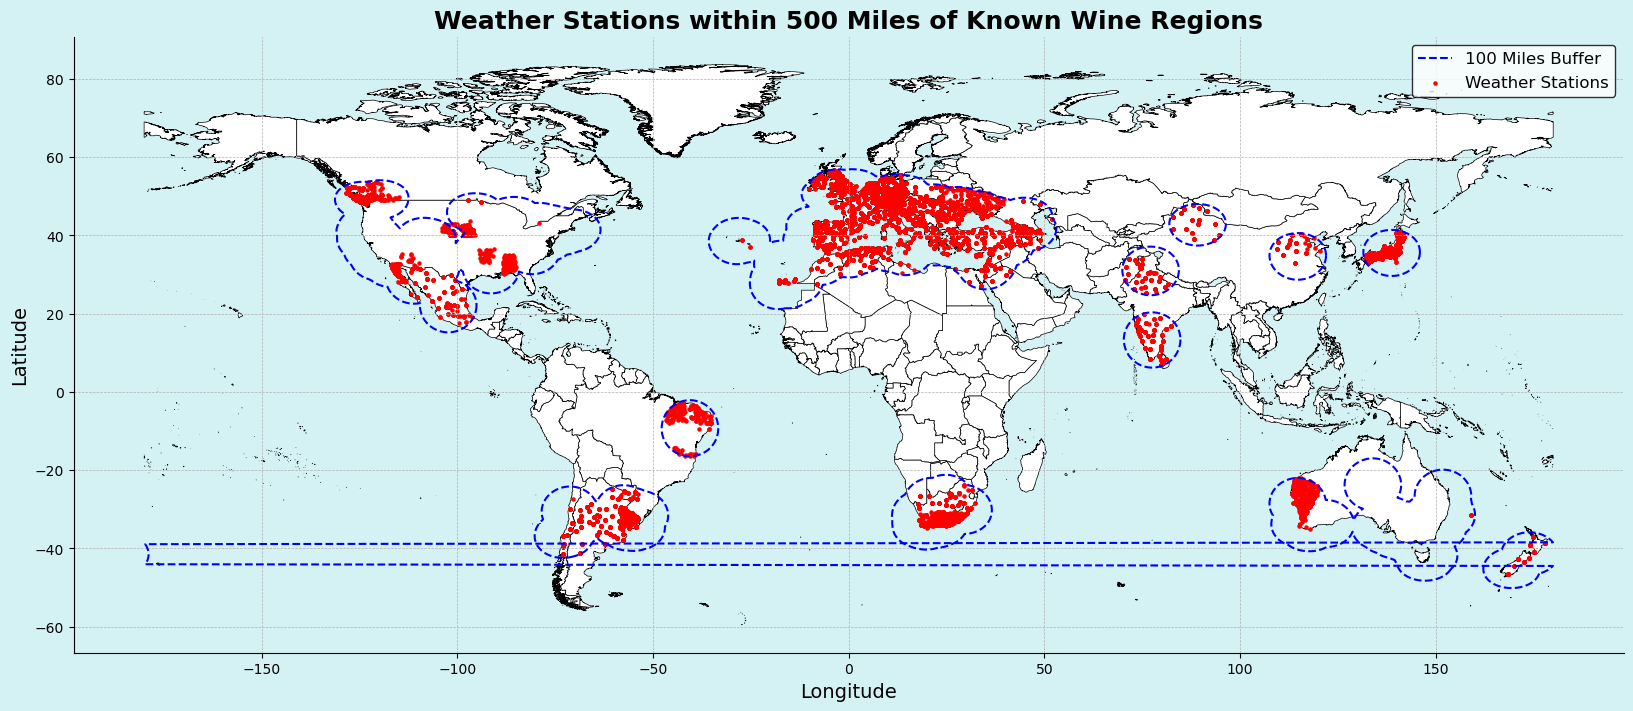

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Customizing the plot's appearance
font_family = "sans"
background_color = "#D4F1F4"
text_color = "#040303"

sns.set_style({
    "axes.facecolor": background_color,
    "figure.facecolor": background_color,
    "font.family": font_family,
    "text.color": text_color,
})

# Load the world map from the Natural Earth dataset
world_shapefile_path = 'Resources/Shapefiles/WB_countries_Admin0_10m.shp'
world = gpd.read_file(world_shapefile_path)

# Re-project world map to match the buffer zone's CRS
world = world.to_crs(epsg=4326)

# Ensure shape_buffer_geo and stations_within_buffer are also in the correct CRS
shape_buffer_geo = shape_buffer_geo.to_crs(epsg=4326)
stations_within_buffer = stations_within_buffer.to_crs(epsg=4326)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Plot the world map with white countries
world.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Plot the buffer zone
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1.5, linestyle='--', label='100 Miles Buffer')

# Plot the weather stations within the buffer
stations_within_buffer.plot(ax=ax, color='red', markersize=5, label='Weather Stations')

# Add titles and labels
plt.title('Weather Stations within 500 Miles of Known Wine Regions', fontsize=18, fontweight='bold', color=text_color)
plt.xlabel('Longitude', fontsize=14, color=text_color)
plt.ylabel('Latitude', fontsize=14, color=text_color)

# Customize legend
plt.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white', edgecolor='black')

# Improve the overall aesthetics
ax.set_facecolor(background_color)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the aspect of the map to be equal
ax.set_aspect('equal')

# Save the figure with the correct file path
save_dir = "Figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(os.path.join(save_dir, "Weather_Stations_by_Wine_Regions.png"))

# Display the plot
plt.show()


### Double checking my climate file matches up with original start file

In [18]:


import pandas as pd

# Load the weather_all_country_codes3.csv file
weather_file_path = 'Resources/weather_all_country_codes3.csv'
weather_df = pd.read_csv(weather_file_path)

# Load the merged_weather_data.csv file
merged_file_path = 'Outputs/merged_weather_country_data_Station_year.csv'
merged_df = pd.read_csv(merged_file_path)

# Ensure the station identifiers are consistent (e.g., remove 'GHCND:' prefix if necessary)
weather_df['station'] = weather_df['station'].str.replace('GHCND:', '')
merged_df['station'] = merged_df['station'].str.replace('GHCND:', '')

# Calculate the number of unique station IDs in each file
unique_stations_weather = weather_df['station'].nunique()
unique_stations_merged = merged_df['station'].nunique()

print(f"Number of unique stations in weather_all_country_codes3.csv: {unique_stations_weather}")
print(f"Number of unique stations in merged_weather_data.csv: {unique_stations_merged}")


Number of unique stations in weather_all_country_codes3.csv: 6303
Number of unique stations in merged_weather_data.csv: 6303


### Identify all weather stations within 500 miles of a known wine region

In [19]:
import pandas as pd

# Load the merged weather station file
merged_file_path = 'Outputs/merged_weather_country_data_Station_year.csv'
merged_df = pd.read_csv(merged_file_path)

# Load the stations_within_buffer file
stations_within_buffer_file_path = 'Outputs/stations_within_100_miles.csv'
stations_within_buffer = pd.read_csv(stations_within_buffer_file_path)

# Load the wine data file
wine_data_file_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_df = pd.read_csv(wine_data_file_path)

# Ensure column names are consistent
merged_df.columns = merged_df.columns.str.lower()
stations_within_buffer.columns = stations_within_buffer.columns.str.lower()
wine_df.columns = wine_df.columns.str.lower()

# Rename 'Region/Country' to 'country' in the wine DataFrame
if 'region/country' in wine_df.columns:
    wine_df.rename(columns={'region/country': 'country'}, inplace=True)

# Print column names to verify renaming
print("Merged DataFrame columns:", merged_df.columns)
print("Stations within buffer DataFrame columns:", stations_within_buffer.columns)
print("Wine data DataFrame columns:", wine_df.columns)

# Check if 'country' column exists in stations_within_buffer
if 'country' not in stations_within_buffer.columns:
    # If it does not exist, you need to decide how to handle this case
    # For example, you might want to extract country information from another column
    # or add a default value for the sake of demonstration:
    stations_within_buffer['country'] = 'Unknown'

# Extract unique country codes
unique_countries_wine = set(wine_df['country'].unique())
unique_countries_buffer = set(stations_within_buffer['country'].unique())

# Find countries in wine production data but not in stations within buffer
missing_countries = unique_countries_wine - unique_countries_buffer

# Filter the merged weather data for the missing countries
missing_data = merged_df[merged_df['country'].isin(missing_countries)]

# Save the missing data to a file
missing_data_file_path = 'Outputs/missing_countries_weather_data.csv'
missing_data.to_csv(missing_data_file_path, index=False)
print(f"Missing countries' weather data saved to {missing_data_file_path}")

# Add the missing countries' data back to the stations within the buffer data
updated_buffer_data = pd.concat([stations_within_buffer, missing_data], ignore_index=True)

# Save the updated buffer data
updated_buffer_file_path = 'Outputs/updated_stations_within_100_miles.csv'
updated_buffer_data.to_csv(updated_buffer_file_path, index=False)
print(f"Updated buffer data saved to {updated_buffer_file_path}")

# Display the first few rows of the updated buffer data as a table
print("Updated Buffer Data:")
print(updated_buffer_data.head().to_string(index=False))


Merged DataFrame columns: Index(['station', 'date', 'dp10', 'dp1x', 'dt32', 'dx70', 'dx90', 'emnt',
       'emxp', 'emxt', 'htdd', 'mnpn', 'mxpn', 'prcp', 'tavg', 'tmax', 'code',
       'latitude', 'longitude', 'elevation', 'location', 'country'],
      dtype='object')
Stations within buffer DataFrame columns: Index(['station', 'date', 'dp10', 'dp1x', 'dt32', 'dx70', 'dx90', 'emnt',
       'emxp', 'emxt', 'htdd', 'mnpn', 'mxpn', 'prcp', 'tavg', 'tmax', 'code',
       'latitude', 'longitude', 'elevation', 'location', 'geometry'],
      dtype='object')
Wine data DataFrame columns: Index(['country', 'year', 'quantity_hl', 'gallons', 'code'], dtype='object')
Missing countries' weather data saved to Outputs/missing_countries_weather_data.csv
Updated buffer data saved to Outputs/updated_stations_within_100_miles.csv
Updated Buffer Data:
    station  date  dp10  dp1x  dt32  dx70  dx90  emnt  emxp  emxt   htdd  mnpn  mxpn  prcp  tavg  tmax code  latitude  longitude  elevation                  

### Clean up weather station data to have only an averaged data value for each country by year. 

In [20]:

# Load the CSV file
file_path = 'Outputs/updated_stations_within_100_miles.csv'
data = pd.read_csv(file_path)

# Specify the columns to average and calculate standard deviation
columns_to_average = ['dp10', 'dp1x', 'dt32', 'dx70', 'dx90', 'emnt', 'emxp', 'emxt', 'htdd', 'mnpn', 'mxpn', 'prcp', 'tavg', 'tmax']

# Group by 'country' and 'date', then calculate the mean and standard deviation
grouped_data = data.groupby(['country', 'date'])[columns_to_average].agg(['mean', 'std']).reset_index()

# Flatten the column names
grouped_data.columns = ['_'.join(col).strip('_') for col in grouped_data.columns.values]

# Save the cleaned and grouped data to a new CSV file if needed
output_path = 'Outputs/averages_updated_100_mile_stations.csv'
grouped_data.to_csv(output_path, index=False)

# Display the cleaned and grouped data
grouped_data


C:\Users\tfregoso\AppData\Local\Temp\1\ipykernel_32892\3390705029.py:3: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



country  date   dp10_mean   dp10_std  dp1x_mean  dp1x_std  dt32_mean  \
0     Albania  1995   97.000000        NaN  29.000000       NaN        NaN   
1     Albania  1996  101.000000        NaN  30.000000       NaN        NaN   
2     Albania  1997   70.000000        NaN  16.000000       NaN        NaN   
3     Albania  1998         NaN        NaN        NaN       NaN        NaN   
4     Albania  1999   91.000000        NaN  24.000000       NaN        NaN   
...       ...   ...         ...        ...        ...       ...        ...   
2191  Vietnam  2019   70.285714  20.572751  17.285714  7.825477        NaN   
2192  Vietnam  2020   71.285714  16.908719  17.714286  8.826367        NaN   
2193  Vietnam  2021   77.000000   6.055301  21.250000  8.845903        NaN   
2194  Vietnam  2022  128.000000        NaN  34.000000       NaN        NaN   
2195  Vietnam  2023   70.857143  22.378774  16.428571  8.941610        NaN   

      dt32_std  dx70_mean   dx70_std  ...  mnpn_mean  mnpn_std  mxpn_mean  \
0          NaN      160.0        NaN  ...        NaN       NaN        NaN   
1          NaN      173.0        NaN  ...        NaN       NaN        NaN   
2          NaN      169.5  12.020815  ...        NaN       NaN        NaN   
3          NaN      182.0        NaN  ...        NaN       NaN        NaN   
4          NaN      187.5   0.707107  ...        NaN       NaN        NaN   
...        ...        ...        ...  ...        ...       ...        ...   
2191       NaN        NaN        NaN  ...        NaN       NaN        NaN   
2192       NaN        NaN        NaN  ...        NaN       NaN        NaN   
2193       NaN        NaN        NaN  ...        NaN       NaN        NaN   
2194       NaN        NaN        NaN  ...        NaN       NaN        NaN   
2195       NaN        NaN        NaN  ...        NaN       NaN        NaN   

      mxpn_std   prcp_mean   prcp_std  tavg_mean  tavg_std  tmax_mean  \
0          NaN   90.820000        NaN        NaN       NaN      66.90   
1          NaN   92.590000        NaN        NaN       NaN      68.70   
2          NaN   57.740000        NaN        NaN       NaN      69.65   
3          NaN         NaN        NaN        NaN       NaN      70.90   
4          NaN   72.340000        NaN        NaN       NaN      71.00   
...        ...         ...        ...        ...       ...        ...   
2191       NaN   56.551429  18.578469        NaN       NaN        NaN   
2192       NaN   62.635714  26.536631        NaN       NaN        NaN   
2193       NaN   72.560000  28.564926        NaN       NaN        NaN   
2194       NaN  105.860000        NaN        NaN       NaN        NaN   
2195       NaN   56.478571  24.640240        NaN       NaN        NaN   

      tmax_std  
0          NaN  
1          NaN  
2     1.343503  
3          NaN  
4     0.424264  
...        ...  
2191       NaN  
2192       NaN  
2193       NaN  
2194       NaN  
2195       NaN  

[2196 rows x 30 columns]

### Merge Wine production data with cleaned accounting for region weather data

In [21]:
import pandas as pd

# Load the two CSV files
wine_data = pd.read_csv('Outputs/Wine_data_Production_cleaned.csv')
weather_data = pd.read_csv('Outputs/averages_updated_100_mile_stations.csv')

# Rename columns to prepare for merging
wine_data.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)
weather_data.rename(columns={'date': 'year'}, inplace=True)

# Merging the datasets on the 'country' and 'year' column
merged_data = pd.merge(wine_data, weather_data, on=['country', 'year'], how='outer')

# Save the final merged dataframe to a CSV file
output_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
merged_data.to_csv(output_path, index=False)

# Identify unmatched wine data
# Extract country columns
merged_countries = weather_data['country'].unique()
wine_data_all_countries = wine_data['country'].unique()

# Convert to sets for easy comparison
merged_countries_set = set(merged_countries)
wine_data_all_countries_set = set(wine_data_all_countries)

# Find common and unique countries
common_countries = merged_countries_set & wine_data_all_countries_set
unique_to_merged = merged_countries_set - wine_data_all_countries_set
unique_to_wine_data_all = wine_data_all_countries_set - merged_countries_set

# Count the countries in each category
common_countries_count = len(common_countries)
unique_to_merged_count = len(unique_to_merged)
unique_to_wine_data_all_count = len(unique_to_wine_data_all)

# Results
print("Countries present in both datasets:", common_countries_count)
print("Countries unique to the weather:", unique_to_merged_count)
print("Countries unique to the wine data all dataset:", unique_to_wine_data_all_count)

# Lists of unique countries
unique_to_merged_countries = list(unique_to_merged)
unique_to_wine_data_all_countries = list(unique_to_wine_data_all)

print("Countries unique to the weather dataset:", unique_to_merged_countries)
print("Countries unique to the wine data all dataset:", unique_to_wine_data_all_countries)


Countries present in both datasets: 127
Countries unique to the weather: 1
Countries unique to the wine data all dataset: 58
Countries unique to the weather dataset: ['Unknown']
Countries unique to the wine data all dataset: ['Tonga', 'China, mainland', 'Seychelles', 'Mauritania', 'Qatar', 'Tuvalu', 'Cameroon', 'Uganda', 'Gabon', 'Republic of North Macedonia', 'Malawi', "Korea (the Democratic People's Republic of)", 'South Sudan', 'Rwanda', 'Congo (the Democratic Republic of the)', 'Brunei Darussalam', 'Nigeria', 'Syrian Arab Republic', 'Dominica', 'Maldives', 'Barbados', 'Sierra Leone', "Lao People's Democratic Republic", 'Guadeloupe', 'Nicaragua', 'Antigua and Barbuda', 'Afghanistan', 'Kiribati', 'Panama', 'Niue', 'Ecuador', 'Cambodia', 'Ghana', 'Guinea', 'Norfolk Island', 'Reunion island', 'Liberia', 'Luxemburg', 'Saint Lucia', 'Bahrain', 'Gambia', 'Zimbabwe', 'Angola', 'Burundi', 'Congo', 'Chad', 'Serbia And Montenegro', 'Lesotho', 'Tanzania, the United Republic of', 'Eritrea', 'Et

# Weather by Region Analysis

In [22]:
#Region data set
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
region_data_all = pd.read_csv(file_path)

# Max temperature
# We only care about data that is not NaN
r_tmax_ww_df = region_data_all[region_data_all['tmax_mean'].notna()]

r_tmax_ww_df.head()

country  year  Quantity_hl    Gallons code  dp10_mean  dp10_std  \
28  Albania  1995        169.0  4464506.8   AL       97.0       NaN   
29  Albania  1996        293.0  7740239.6   AL      101.0       NaN   
30  Albania  1997        168.0  4438089.6   AL       70.0       NaN   
31  Albania  1998        105.0  2773806.0   AL        NaN       NaN   
32  Albania  1999        127.0  3354984.4   AL       91.0       NaN   

    dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
28       29.0       NaN        NaN  ...        NaN       NaN        NaN   
29       30.0       NaN        NaN  ...        NaN       NaN        NaN   
30       16.0       NaN        NaN  ...        NaN       NaN        NaN   
31        NaN       NaN        NaN  ...        NaN       NaN        NaN   
32       24.0       NaN        NaN  ...        NaN       NaN        NaN   

    mxpn_std  prcp_mean  prcp_std  tavg_mean  tavg_std  tmax_mean  tmax_std  
28       NaN      90.82       NaN        NaN       NaN      66.90       NaN  
29       NaN      92.59       NaN        NaN       NaN      68.70       NaN  
30       NaN      57.74       NaN        NaN       NaN      69.65  1.343503  
31       NaN        NaN       NaN        NaN       NaN      70.90       NaN  
32       NaN      72.34       NaN        NaN       NaN      71.00  0.424264  

[5 rows x 33 columns]

Dropdown(description='Country:', index=58, options=('Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'An…

Dropdown(description='Weather Params:', index=2, options=('tmax_mean', 'prcp_mean', 'tavg_mean', 'emxt_mean', …

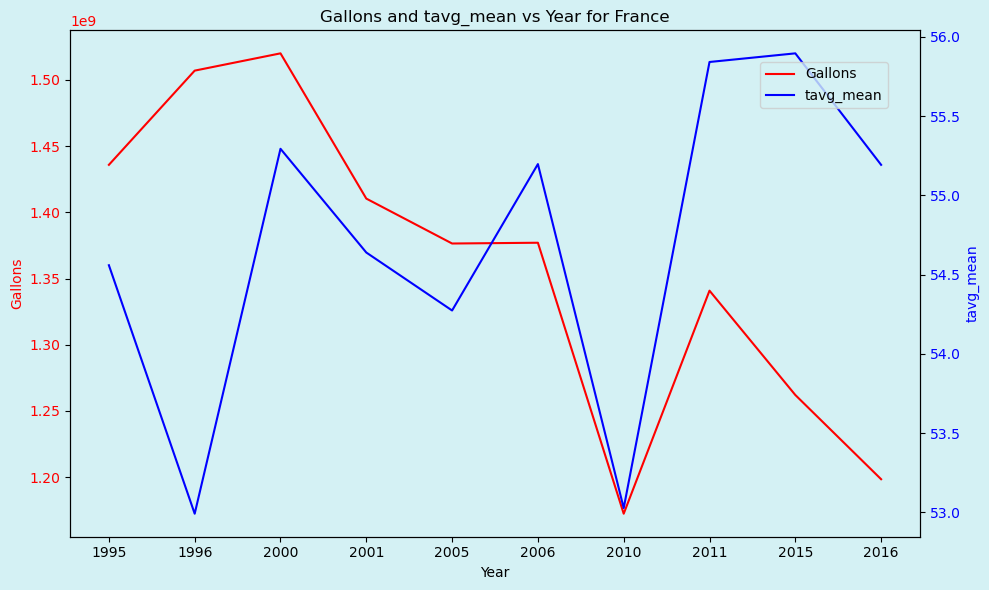

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assuming region_data_all is already loaded
# Convert 'year' to string format if it's not already
region_data_all['year'] = region_data_all['year'].astype(str).str[:4]

# Unique countries for the dropdown
countries = region_data_all['country'].unique()
weather_params = ['tmax_mean', 'prcp_mean', 'tavg_mean', 'emxt_mean', 'emnt_mean']

# Create a dropdown widget for country selection
country_widget = widgets.Dropdown(
    options=countries,
    description='Country:',
    value='France',  # Set a default value
    disabled=False,
)

# Create a dropdown widget for weather parameters
weather_params_widget = widgets.Dropdown(
    options=weather_params,
    description='Weather Params:',
    value='tavg_mean',  # Set a default value
    disabled=False,
)

# Function to update the plot based on the selected country
def update_plot(change=None):
    clear_output(wait=True)
    display(country_widget, weather_params_widget)

    country = country_widget.value
    weather_param = weather_params_widget.value

    # Filter the dataframe
    weather_df = region_data_all[region_data_all[weather_param].notna()]
    filtered_df = weather_df[weather_df['country'] == country]

    if filtered_df.empty:
        print(f"No data available for {country} with parameter {weather_param}")
        return

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting Gallons vs Year on the primary y-axis
    ax1.plot(filtered_df['year'], filtered_df['Gallons'], color='red', label='Gallons')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Gallons', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(filtered_df['year'], filtered_df[weather_param], color='blue', label=weather_param)
    ax2.set_ylabel(weather_param, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Adding titles
    plt.title(f'Gallons and {weather_param} vs Year for {country}')

    # Adding legends
    fig.tight_layout()  # Adjust layout to fit both y-axis labels
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# Observe changes in the dropdown and update the plot accordingly
country_widget.observe(update_plot, names='value')
weather_params_widget.observe(update_plot, names='value')

# Display the widgets
display(country_widget, weather_params_widget)

# Initial plot
update_plot()


# 3. What is the correlation between max temperature and wine production?

Missing values in 'year': 0
Missing values in 'Gallons': 0
Missing values in 'tmax_mean': 19
Gallons Regression Line: 1648    1503.748405
1649    1490.064847
1653    1435.330617
1654    1421.647059
1658    1366.912829
1659    1353.229271
1663    1298.495041
1664    1284.811483
1668    1230.077253
1669    1216.393695
Name: year, dtype: float64
Temperature Regression Line: 1648    61.678258
1649    61.760567
1653    62.089804
1654    62.172113
1658    62.501349
1659    62.583658
1663    62.912895
1664    62.995204
1668    63.324440
1669    63.406750
Name: year, dtype: float64


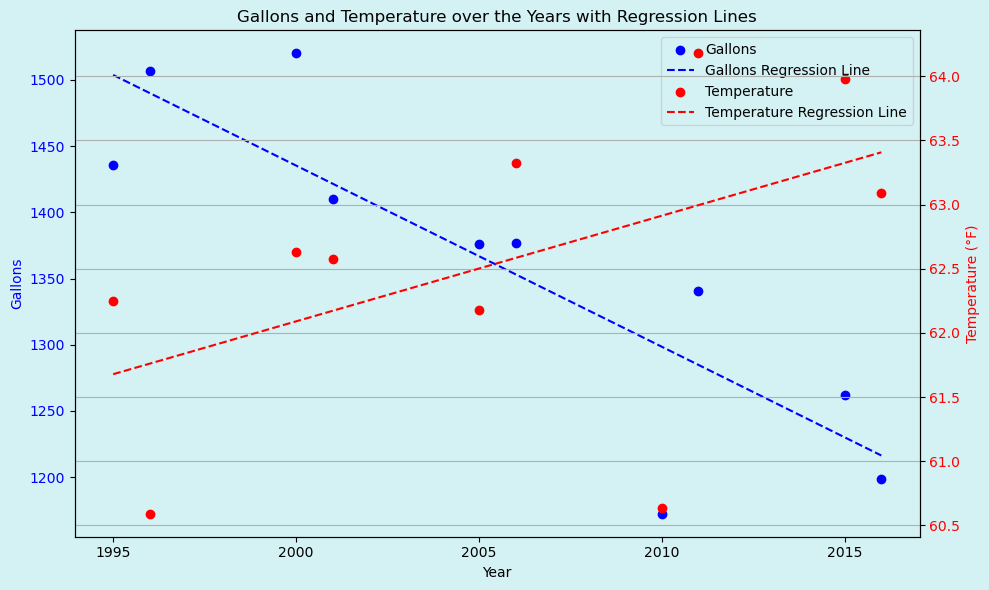

Gallons Regression:
Slope: -13.683557598805967
Intercept: 28802.445814365365
R-squared: 0.7389335686511054
P-value: 0.0014295105151015538
Standard error: 2.8755892358735027

Temperature Regression:
Slope: 0.08230912400960783
Intercept: -102.52844441579762
R-squared: 0.2557162200358093
P-value: 0.1359274246791114
Standard error: 0.04964701311352754


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure 'year' column is in the correct format
region_data_all['year'] = region_data_all['year'].astype(str).str[:4].astype(int)

# Copy the dataframe and filter for France ('FR')
fr_data = region_data_all.copy()
fr_data = fr_data[fr_data['code'] == 'FR'] 

# Convert Gallons to millions
fr_data['Gallons'] = fr_data['Gallons'] / 1e6
yearly_production = fr_data

# Check for missing values in the columns used for regression
print("Missing values in 'year':", yearly_production['year'].isna().sum())
print("Missing values in 'Gallons':", yearly_production['Gallons'].isna().sum())
print("Missing values in 'tmax_mean':", yearly_production['tmax_mean'].isna().sum())

# Ensure there are no missing values
yearly_production = yearly_production.dropna(subset=['year', 'Gallons', 'tmax_mean'])

# Ensure there are at least two data points for regression
if len(yearly_production) < 2:
    print("Not enough data points for regression.")
else:
    # Calculate the linear regression for Gallons over the Years
    slope_gallons, intercept_gallons, r_value_gallons, p_value_gallons, std_err_gallons = linregress(yearly_production['year'], yearly_production['Gallons'])

    # Calculate the linear regression for Temperature over the Years
    slope_temp, intercept_temp, r_value_temp, p_value_temp, std_err_temp = linregress(yearly_production['year'], yearly_production['tmax_mean'])

    # Generate the regression lines
    regression_line_gallons = intercept_gallons + slope_gallons * yearly_production['year']
    regression_line_temp = intercept_temp + slope_temp * yearly_production['year']

    # Debug statements to ensure the regression lines are calculated
    print("Gallons Regression Line:", regression_line_gallons)
    print("Temperature Regression Line:", regression_line_temp)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot gallons data and regression line
    ax1.scatter(yearly_production['year'], yearly_production['Gallons'], label='Gallons', color='blue')
    ax1.plot(yearly_production['year'], regression_line_gallons, color='blue', linestyle='--', label='Gallons Regression Line')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Gallons', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for temperature
    ax2 = ax1.twinx()
    ax2.scatter(yearly_production['year'], yearly_production['tmax_mean'], label='Temperature', color='red')
    ax2.plot(yearly_production['year'], regression_line_temp, color='red', linestyle='--', label='Temperature Regression Line')
    ax2.set_ylabel('Temperature (°F)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add title and grid
    plt.title('Gallons and Temperature over the Years with Regression Lines')
    fig.tight_layout()
    plt.grid(True)

    # Combine legends from both y-axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='best')

    plt.show()

    # Print the regression statistics for gallons
    print("Gallons Regression:")
    print(f"Slope: {slope_gallons}")
    print(f"Intercept: {intercept_gallons}")
    print(f"R-squared: {r_value_gallons**2}")
    print(f"P-value: {p_value_gallons}")
    print(f"Standard error: {std_err_gallons}")

    # Print the regression statistics for temperature
    print("\nTemperature Regression:")
    print(f"Slope: {slope_temp}")
    print(f"Intercept: {intercept_temp}")
    print(f"R-squared: {r_value_temp**2}")
    print(f"P-value: {p_value_temp}")
    print(f"Standard error: {std_err_temp}")


### Are there any correlations in weather parameters and production?

In [25]:
import pandas as pd

# Load the datasets
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')
glossary = pd.read_csv('Resources/DataType_Glossary.csv')

# Display the first few rows of each dataset to understand their structure
print(wine_weather_data.head())
print(glossary.head())

# Data cleaning and preparation
wine_weather_data_clean = wine_weather_data.dropna(subset=['Gallons'])

# Selecting relevant weather columns for correlation analysis
weather_columns = ['dp10_mean', 'dp1x_mean', 'dt32_mean', 'dx70_mean', 'dx90_mean',
                   'emxp_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']

# Ensure all weather columns exist in the dataset
weather_columns = [col for col in weather_columns if col in wine_weather_data_clean.columns]

# Calculate correlation coefficients
correlations = wine_weather_data_clean[['Gallons'] + weather_columns].corr()

# Extract the correlations of Quantity_gallons with weather columns
quantity_gallons_corr = correlations['Gallons'].drop('Gallons')

quantity_gallons_corr


       country  year  Quantity_hl  Gallons code  dp10_mean  dp10_std  \
0  Afghanistan  1995          0.0      0.0   AF        NaN       NaN   
1  Afghanistan  1996          0.0      0.0   AF        NaN       NaN   
2  Afghanistan  1997          0.0      0.0   AF        NaN       NaN   
3  Afghanistan  1998          0.0      0.0   AF        NaN       NaN   
4  Afghanistan  1999          0.0      0.0   AF        NaN       NaN   

   dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
0        NaN       NaN        NaN  ...        NaN       NaN        NaN   
1        NaN       NaN        NaN  ...        NaN       NaN        NaN   
2        NaN       NaN        NaN  ...        NaN       NaN        NaN   
3        NaN       NaN        NaN  ...        NaN       NaN        NaN   
4        NaN       NaN        NaN  ...        NaN       NaN        NaN   

   mxpn_std  prcp_mean  prcp_std  tavg_mean  tavg_std  tmax_mean  tmax_std  
0       NaN        NaN       NaN        NaN  

dp10_mean   -0.156479
dp1x_mean   -0.155540
dt32_mean   -0.051554
dx70_mean   -0.101701
dx90_mean   -0.147488
emxp_mean   -0.106783
prcp_mean   -0.162205
tavg_mean   -0.054011
tmax_mean   -0.064077
Name: Gallons, dtype: float64

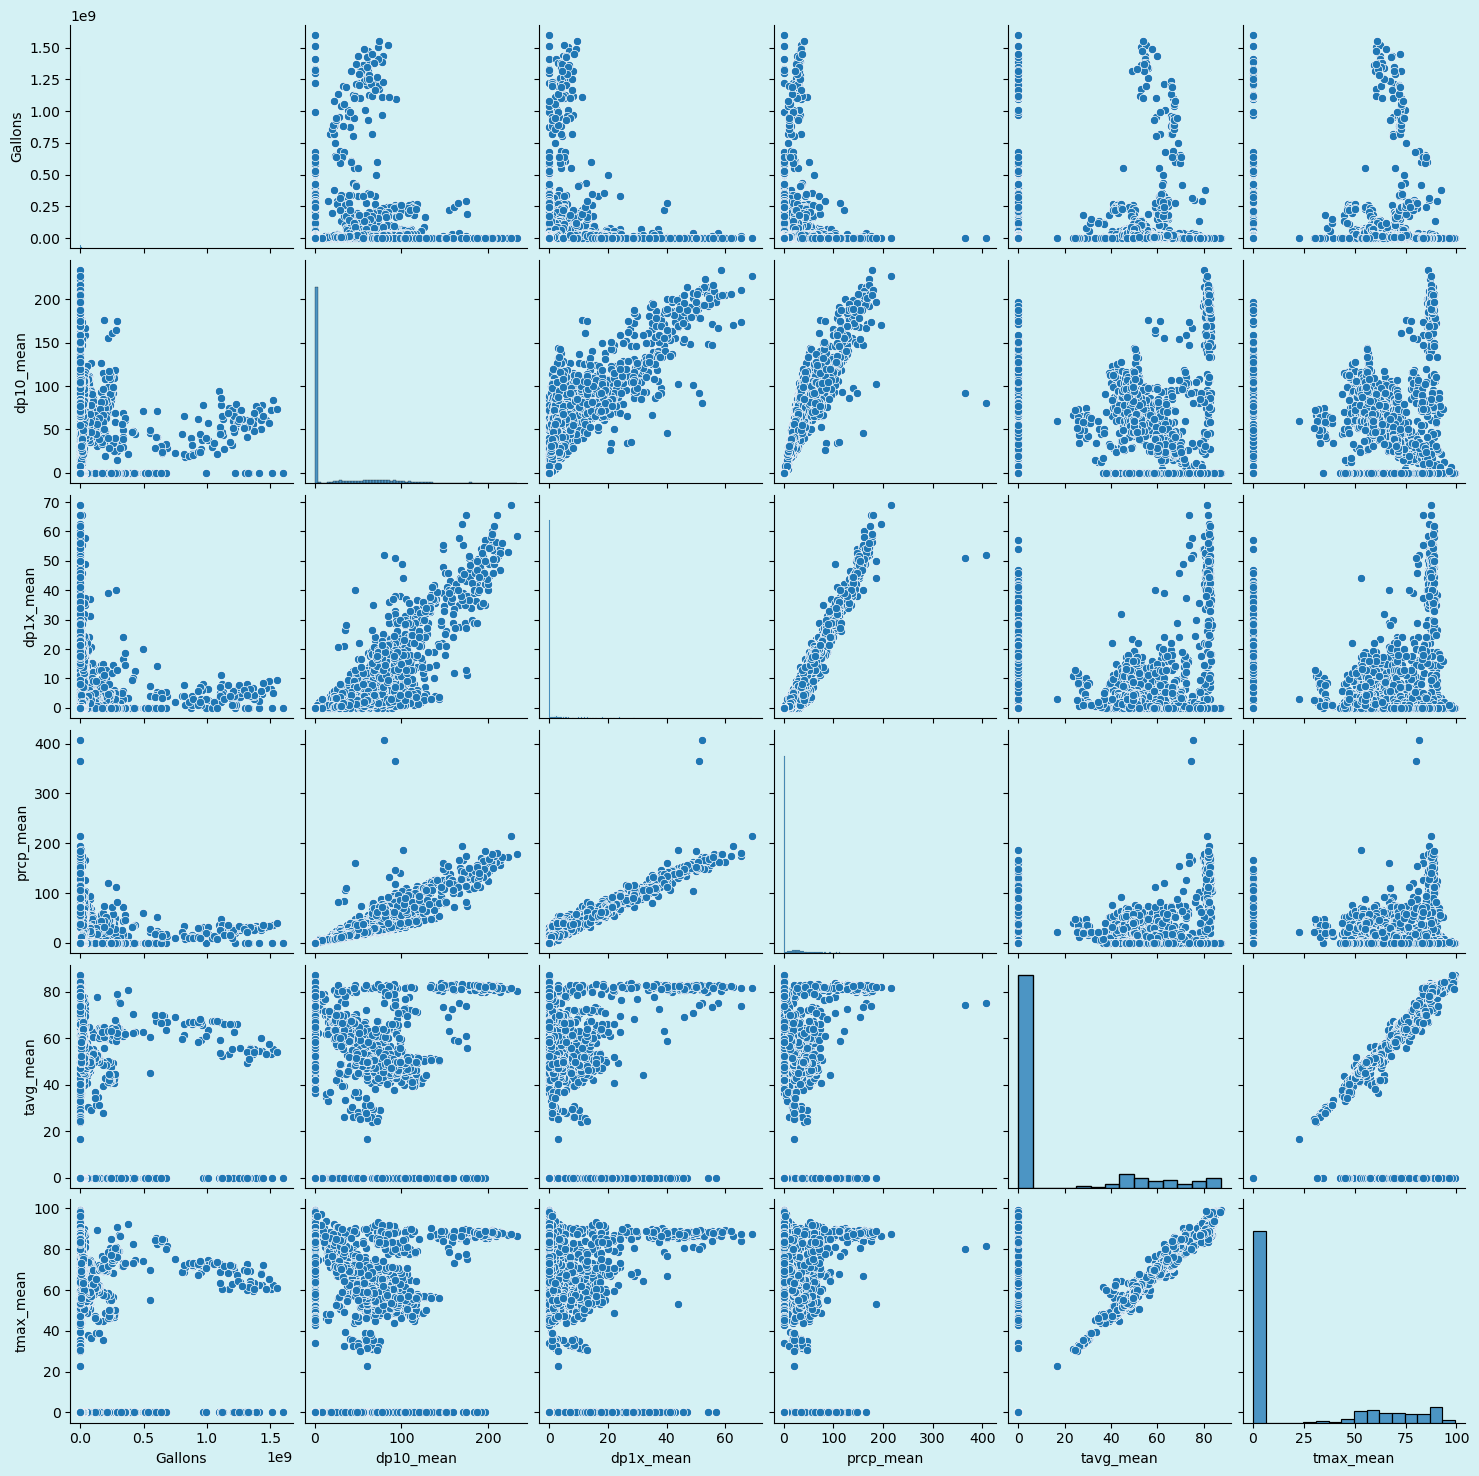

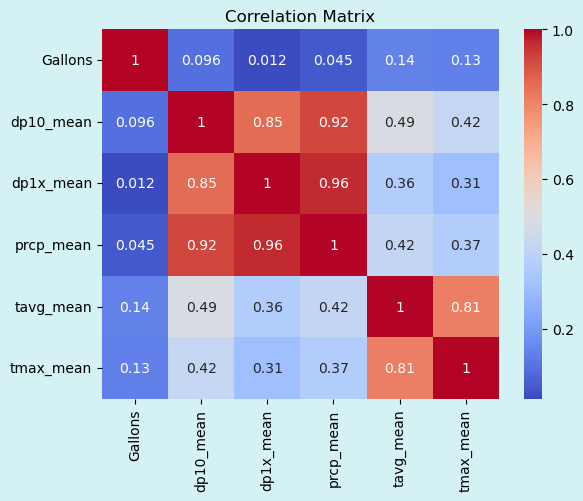

                            OLS Regression Results                            
Dep. Variable:                Gallons   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     38.44
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           7.24e-39
Time:                        15:22:02   Log-Likelihood:            -1.0528e+05
No. Observations:                5179   AIC:                         2.106e+05
Df Residuals:                    5173   BIC:                         2.106e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.16e+07   2.79e+06      7.755      0.0

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Load the data
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Clean the data: handle missing values, ensure data types are correct
wine_weather_data.dropna(subset=['Gallons'], inplace=True)
wine_weather_data.fillna(0, inplace=True)

# Select relevant columns
relevant_columns = ['Gallons', 'dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
data = wine_weather_data[relevant_columns]

# Visualize the data
sns.pairplot(data)
plt.show()

# Correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Linear regression model
X = data[['dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']]
y = data['Gallons']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())


       country  year  counts
0  Afghanistan  1995       1
1  Afghanistan  1996       1
2  Afghanistan  1997       1
3  Afghanistan  1998       1
4  Afghanistan  1999       1
          country  unique_years
0     Afghanistan            28
1         Albania            28
2         Algeria            29
3  American Samoa            28
4          Angola            28
       country  year  Quantity_hl  Gallons code  dp10_mean  dp10_std  \
0  Afghanistan  1995          0.0      0.0   AF        NaN       NaN   
1  Afghanistan  1996          0.0      0.0   AF        NaN       NaN   
2  Afghanistan  1997          0.0      0.0   AF        NaN       NaN   
3  Afghanistan  1998          0.0      0.0   AF        NaN       NaN   
4  Afghanistan  1999          0.0      0.0   AF        NaN       NaN   

   dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
0        NaN       NaN        NaN  ...        NaN       NaN        NaN   
1        NaN       NaN        NaN  ...        NaN    

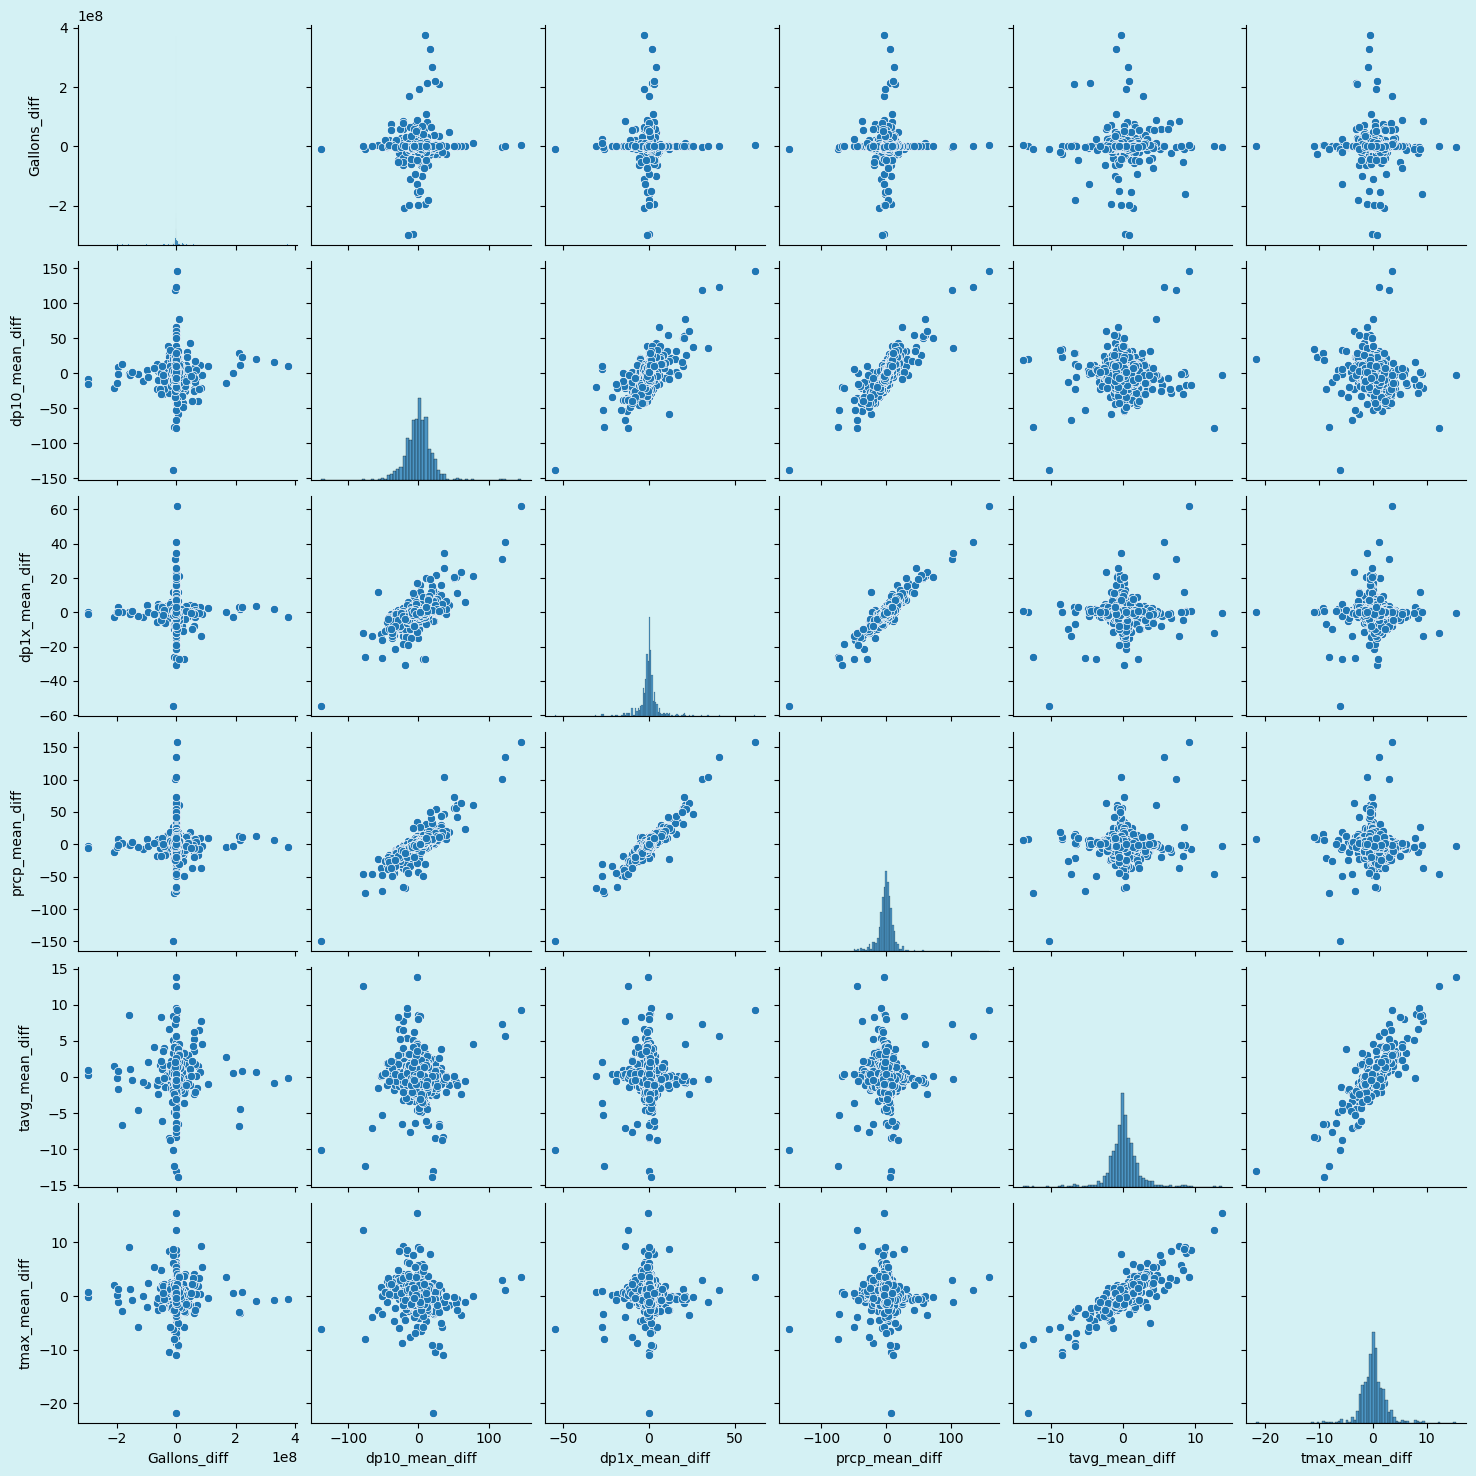

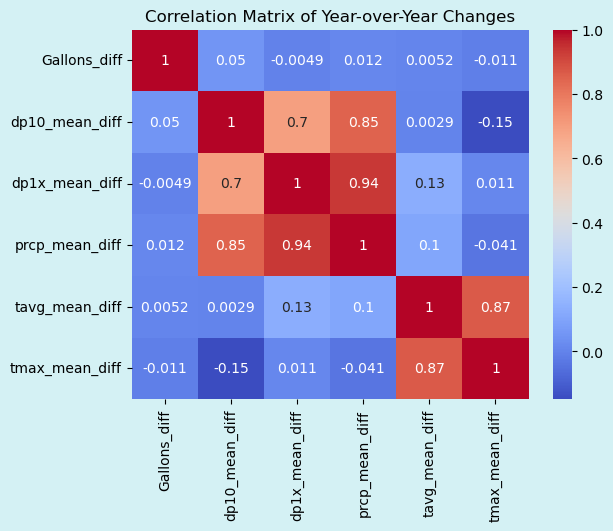

                            OLS Regression Results                            
Dep. Variable:           Gallons_diff   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9302
Date:                Thu, 20 Jun 2024   Prob (F-statistic):              0.461
Time:                        15:22:08   Log-Likelihood:                -13783.
No. Observations:                 728   AIC:                         2.758e+04
Df Residuals:                     722   BIC:                         2.760e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.311e+05   1.51e+06      0.

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the data again for clarity
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Verify the number of records per country and year
records_per_country_year = filtered_data.groupby(['country', 'year']).size().reset_index(name='counts')
print(records_per_country_year.head())

# Check unique years per country
unique_years_per_country = filtered_data.groupby('country')['year'].nunique().reset_index(name='unique_years')
print(unique_years_per_country.head())

# Filter countries with insufficient records
sufficient_records_countries = unique_years_per_country[unique_years_per_country['unique_years'] > 1]['country']
filtered_data_sufficient = filtered_data[filtered_data['country'].isin(sufficient_records_countries)]

# Inspect the filtered data to ensure it's non-empty
print(filtered_data_sufficient.head())

# Recompute year-over-year differences
filtered_data_sufficient['Gallons_diff'] = filtered_data_sufficient.groupby('country')['Gallons'].diff()
filtered_data_sufficient['dp10_mean_diff'] = filtered_data_sufficient.groupby('country')['dp10_mean'].diff()
filtered_data_sufficient['dp1x_mean_diff'] = filtered_data_sufficient.groupby('country')['dp1x_mean'].diff()
filtered_data_sufficient['prcp_mean_diff'] = filtered_data_sufficient.groupby('country')['prcp_mean'].diff()
filtered_data_sufficient['tavg_mean_diff'] = filtered_data_sufficient.groupby('country')['tavg_mean'].diff()
filtered_data_sufficient['tmax_mean_diff'] = filtered_data_sufficient.groupby('country')['tmax_mean'].diff()

# Select relevant columns for analysis
diff_columns = ['Gallons_diff', 'dp10_mean_diff', 'dp1x_mean_diff', 'prcp_mean_diff', 'tavg_mean_diff', 'tmax_mean_diff']
data_diff_sufficient = filtered_data_sufficient[diff_columns]

# Inspect year-over-year differences to ensure they are computed correctly
print(data_diff_sufficient.head())

# Drop rows with missing values
data_diff_sufficient = data_diff_sufficient.dropna()

# Ensure there are no remaining NaNs
missing_values_sufficient = data_diff_sufficient.isnull().sum()
print(missing_values_sufficient)

# Check for any zero-size arrays
print(data_diff_sufficient.shape)

# Proceed with the analysis if data is clean
if data_diff_sufficient.isnull().sum().sum() == 0 and data_diff_sufficient.shape[0] > 0:
    # Visualize the data
    sns.pairplot(data_diff_sufficient)
    plt.show()

    # Correlation matrix for year-over-year changes
    correlation_matrix_diff = data_diff_sufficient.corr()
    sns.heatmap(correlation_matrix_diff, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Year-over-Year Changes')
    plt.show()

    # Linear regression model for year-over-year changes
    X_diff = data_diff_sufficient[['dp10_mean_diff', 'dp1x_mean_diff', 'prcp_mean_diff', 'tavg_mean_diff', 'tmax_mean_diff']]
    y_diff = data_diff_sufficient['Gallons_diff']

    # Add a constant to the model (intercept)
    X_diff = sm.add_constant(X_diff)

    # Fit the model
    model_diff = sm.OLS(y_diff, X_diff).fit()

    # Model summary
    model_summary_diff = model_diff.summary()

    print(model_summary_diff)
else:
    print("Data still contains missing values or has zero-size arrays.")


                            OLS Regression Results                            
Dep. Variable:                Gallons   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.717
Date:                Thu, 20 Jun 2024   Prob (F-statistic):            0.00331
Time:                        15:22:08   Log-Likelihood:            -1.0537e+05
No. Observations:                5179   AIC:                         2.108e+05
Df Residuals:                    5176   BIC:                         2.108e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.141e+07   6.18e+0

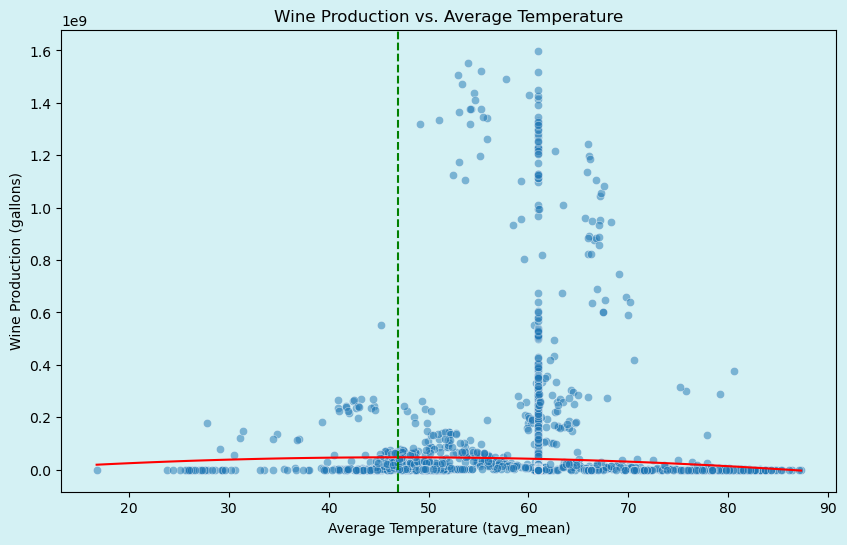

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Drop rows with missing production values
filtered_data = filtered_data.dropna(subset=['Gallons'])

# Fill missing values in weather data with the mean of the respective column
weather_columns = ['dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
filtered_data[weather_columns] = filtered_data[weather_columns].fillna(filtered_data[weather_columns].mean())

# Create a quadratic term for average temperature
filtered_data['tavg_mean_squared'] = filtered_data['tavg_mean'] ** 2

# Select relevant columns for the regression model
X = filtered_data[['tavg_mean', 'tavg_mean_squared']]
y = filtered_data['Gallons']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
quadratic_model = sm.OLS(y, X).fit()

# Model summary
print(quadratic_model.summary())

# Calculate the optimal temperature
optimal_temperature = -quadratic_model.params['tavg_mean'] / (2 * quadratic_model.params['tavg_mean_squared'])
print(f"The optimal average temperature for maximum production is approximately {optimal_temperature:.2f} degrees.")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tavg_mean', y='Gallons', data=filtered_data, alpha=0.5)
tavg_mean_range = np.linspace(filtered_data['tavg_mean'].min(), filtered_data['tavg_mean'].max(), 100)
predicted_production = quadratic_model.predict(sm.add_constant(pd.DataFrame({
    'tavg_mean': tavg_mean_range,
    'tavg_mean_squared': tavg_mean_range ** 2
})))
plt.plot(tavg_mean_range, predicted_production, color='red')
plt.axvline(x=optimal_temperature, color='green', linestyle='--')
plt.title('Wine Production vs. Average Temperature')
plt.xlabel('Average Temperature (tavg_mean)')
plt.ylabel('Wine Production (gallons)')
plt.show()


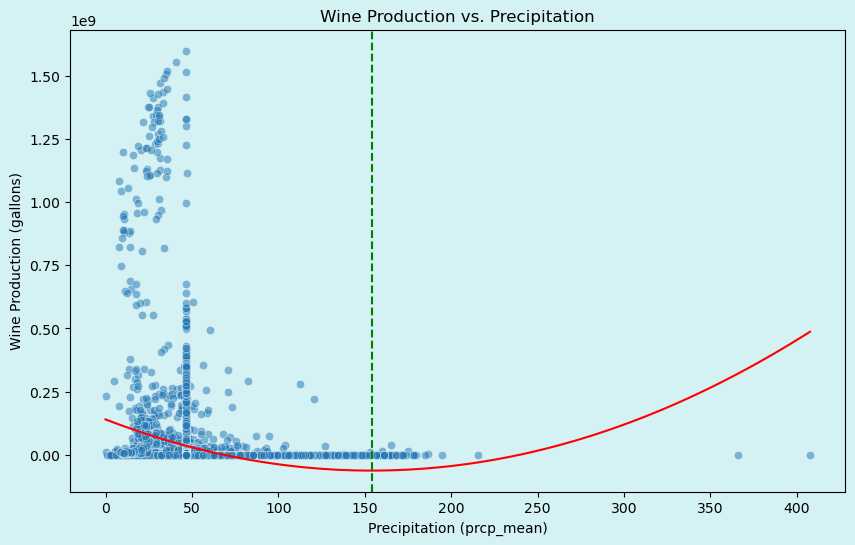

(153.99515039461227,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                Gallons   R-squared:                       0.032
 Model:                            OLS   Adj. R-squared:                  0.032
 Method:                 Least Squares   F-statistic:                     85.79
 Date:                Thu, 20 Jun 2024   Prob (F-statistic):           2.22e-37
 Time:                        15:22:08   Log-Likelihood:            -1.0529e+05
 No. Observations:                5179   AIC:                         2.106e+05
 Df Residuals:                    5176   BIC:                         2.106e+05
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
 -----------------------------------------

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data again for clarity
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Drop rows with missing production values
filtered_data = filtered_data.dropna(subset=['Gallons'])

# Fill missing values in weather data with the mean of the respective column
weather_columns = ['dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
filtered_data[weather_columns] = filtered_data[weather_columns].fillna(filtered_data[weather_columns].mean())

# Create a quadratic term for precipitation
filtered_data['prcp_mean_squared'] = filtered_data['prcp_mean'] ** 2

# Select relevant columns for the regression model
X = filtered_data[['prcp_mean', 'prcp_mean_squared']]
y = filtered_data['Gallons']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
quadratic_model = sm.OLS(y, X).fit()

# Model summary
model_summary = quadratic_model.summary()

# Calculate the optimal precipitation
optimal_precipitation = -quadratic_model.params['prcp_mean'] / (2 * quadratic_model.params['prcp_mean_squared'])

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='prcp_mean', y='Gallons', data=filtered_data, alpha=0.5)
prcp_mean_range = np.linspace(filtered_data['prcp_mean'].min(), filtered_data['prcp_mean'].max(), 100)
predicted_production = quadratic_model.predict(sm.add_constant(pd.DataFrame({
    'prcp_mean': prcp_mean_range,
    'prcp_mean_squared': prcp_mean_range ** 2
})))
plt.plot(prcp_mean_range, predicted_production, color='red')
plt.axvline(x=optimal_precipitation, color='green', linestyle='--')
plt.title('Wine Production vs. Precipitation')
plt.xlabel('Precipitation (prcp_mean)')
plt.ylabel('Wine Production (gallons)')
plt.show()

optimal_precipitation, model_summary


                            OLS Regression Results                            
Dep. Variable:                Gallons   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     44.04
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           2.07e-36
Time:                        15:22:09   Log-Likelihood:            -1.0529e+05
No. Observations:                5179   AIC:                         2.106e+05
Df Residuals:                    5174   BIC:                         2.106e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.082e+07   6.13e+0

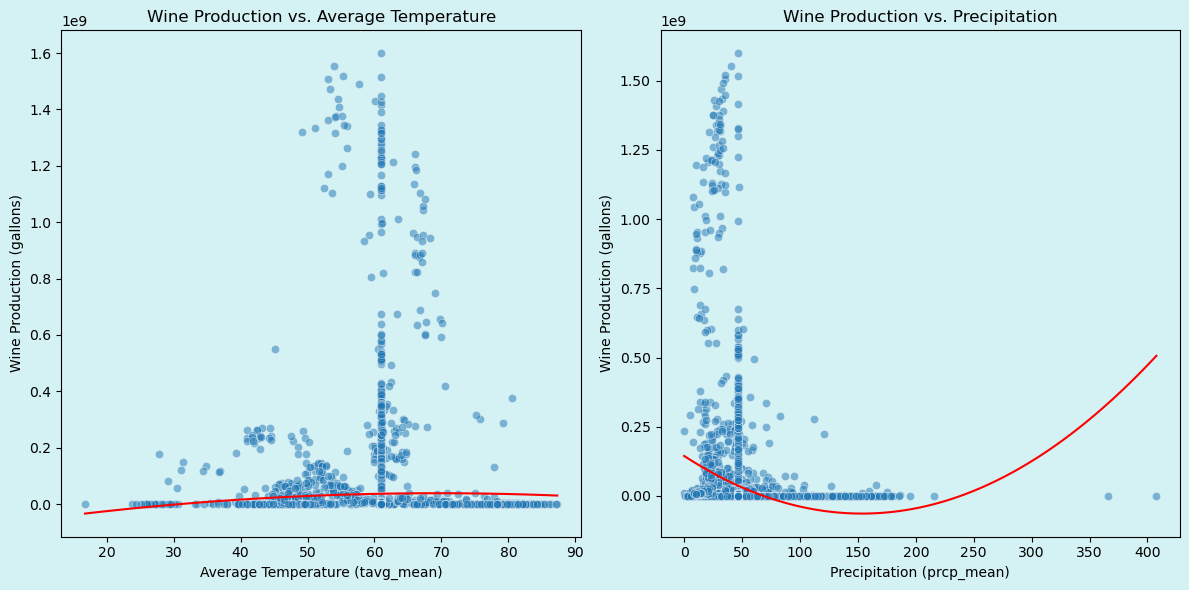

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Gallons   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     44.04
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           2.07e-36
Time:                        15:22:09   Log-Likelihood:            -1.0529e+05
No. Observations:                5179   AIC:                         2.106e+05
Df Residuals:                    5174   BIC:                         2.106e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.082e+07   6.13e+07      0.340      0.734   -9.93e+07    1.41e+08
tavg_mean          3.612e+06   1.97e+06      1.832      0.067   -2.52e+05    7.48e+06
tavg_mean_squared   -2.6e+04    1.6e+04     -1.621      0.105   -5.74e+04    5448.734
prcp_mean         -2.712e+06   2.23e+05    -12.157      0.000   -3.15e+06   -2.27e+06
prcp_mean_squared  8828.9710   1064.928      8.291      0.000    6741.261    1.09e+04
==============================================================================
Omnibus:                     5835.713   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           387681.008
Skew:                           6.010   Prob(JB):                         0.00
Kurtosis:                      43.645   Cond. No.                     1.56e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data again for clarity
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Drop rows with missing production values
filtered_data = filtered_data.dropna(subset=['Gallons'])

# Fill missing values in weather data with the mean of the respective column
weather_columns = ['dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
filtered_data[weather_columns] = filtered_data[weather_columns].fillna(filtered_data[weather_columns].mean())

# Create quadratic terms for average temperature and precipitation
filtered_data['tavg_mean_squared'] = filtered_data['tavg_mean'] ** 2
filtered_data['prcp_mean_squared'] = filtered_data['prcp_mean'] ** 2

# Select relevant columns for the regression model
X = filtered_data[['tavg_mean', 'tavg_mean_squared', 'prcp_mean', 'prcp_mean_squared']]
y = filtered_data['Gallons']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
quadratic_model = sm.OLS(y, X).fit()

# Model summary
model_summary = quadratic_model.summary()

# Display the model summary
print(model_summary)

# Visualize the relationships
plt.figure(figsize=(12, 6))

# Scatter plot for temperature
plt.subplot(1, 2, 1)
sns.scatterplot(x='tavg_mean', y='Gallons', data=filtered_data, alpha=0.5)
tavg_mean_range = np.linspace(filtered_data['tavg_mean'].min(), filtered_data['tavg_mean'].max(), 100)
predicted_production_temp = quadratic_model.predict(sm.add_constant(pd.DataFrame({
    'const': 1,
    'tavg_mean': tavg_mean_range,
    'tavg_mean_squared': tavg_mean_range ** 2,
    'prcp_mean': filtered_data['prcp_mean'].mean(),
    'prcp_mean_squared': (filtered_data['prcp_mean'].mean()) ** 2
})))
plt.plot(tavg_mean_range, predicted_production_temp, color='red')
plt.title('Wine Production vs. Average Temperature')
plt.xlabel('Average Temperature (tavg_mean)')
plt.ylabel('Wine Production (gallons)')

# Scatter plot for precipitation
plt.subplot(1, 2, 2)
sns.scatterplot(x='prcp_mean', y='Gallons', data=filtered_data, alpha=0.5)
prcp_mean_range = np.linspace(filtered_data['prcp_mean'].min(), filtered_data['prcp_mean'].max(), 100)
predicted_production_prcp = quadratic_model.predict(sm.add_constant(pd.DataFrame({
    'const': 1,
    'tavg_mean': filtered_data['tavg_mean'].mean(),
    'tavg_mean_squared': (filtered_data['tavg_mean'].mean()) ** 2,
    'prcp_mean': prcp_mean_range,
    'prcp_mean_squared': prcp_mean_range ** 2
})))
plt.plot(prcp_mean_range, predicted_production_prcp, color='red')
plt.title('Wine Production vs. Precipitation')
plt.xlabel('Precipitation (prcp_mean)')
plt.ylabel('Wine Production (gallons)')

plt.tight_layout()
plt.show()

model_summary


# Is there a maximum temperature that once reached, hinders production?

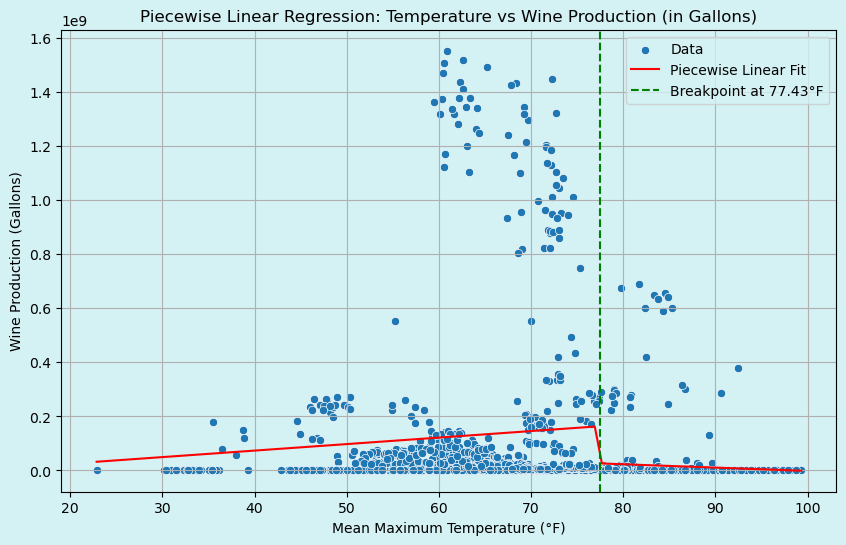

77.43333260341866

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Define a piecewise linear function for regression
def piecewise_linear(x, breakpoint, slope1, slope2, intercept):
    return np.where(x < breakpoint, slope1 * x + intercept, slope2 * x + intercept + slope2 * (x - breakpoint))

# Load the data from the uploaded file
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
data = pd.read_csv(file_path)

# Filter out rows with NaN or infinite values in tmax_mean or Gallons
cleaned_data = data[['tmax_mean', 'Gallons']].dropna()
cleaned_data = cleaned_data[np.isfinite(cleaned_data['tmax_mean'])]
cleaned_data = cleaned_data[np.isfinite(cleaned_data['Gallons'])]

# Convert tmax_mean from Fahrenheit to Celsius
cleaned_data['tmax_mean_celsius'] = (cleaned_data['tmax_mean'] - 32) * 5/9

# Fit the piecewise linear model with the cleaned data
initial_breakpoint_celsius = cleaned_data['tmax_mean_celsius'].median()
params, _ = curve_fit(piecewise_linear, cleaned_data['tmax_mean_celsius'], cleaned_data['Gallons'], 
                      p0=[initial_breakpoint_celsius, 1, -1, cleaned_data['Gallons'].mean()])

breakpoint_celsius, slope1, slope2, intercept = params

# Convert the breakpoint back to Fahrenheit
breakpoint_fahrenheit = (breakpoint_celsius * 9/5) + 32

# Generate a range of temperatures in Celsius for plotting the fitted model
tmax_range_celsius = np.linspace(cleaned_data['tmax_mean_celsius'].min(), cleaned_data['tmax_mean_celsius'].max(), 100)
tmax_range_fahrenheit = (tmax_range_celsius * 9/5) + 32

# Plot the data and the fitted piecewise linear model in Fahrenheit
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cleaned_data['tmax_mean'], y=cleaned_data['Gallons'], label='Data')
plt.plot(tmax_range_fahrenheit, piecewise_linear(tmax_range_celsius, *params), color='red', label='Piecewise Linear Fit')
plt.axvline(breakpoint_fahrenheit, color='green', linestyle='--', label=f'Breakpoint at {breakpoint_fahrenheit:.2f}°F')
plt.title('Piecewise Linear Regression: Temperature vs Wine Production (in Gallons)')
plt.xlabel('Mean Maximum Temperature (°F)')
plt.ylabel('Wine Production (Gallons)')
plt.legend()
plt.grid(True)
plt.show()

breakpoint_fahrenheit


# Is there an optimal temperature for wine production?

                            OLS Regression Results                            
Dep. Variable:                Gallons   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.717
Date:                Thu, 20 Jun 2024   Prob (F-statistic):            0.00331
Time:                        15:22:10   Log-Likelihood:            -1.0537e+05
No. Observations:                5179   AIC:                         2.108e+05
Df Residuals:                    5176   BIC:                         2.108e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.141e+07   6.18e+0

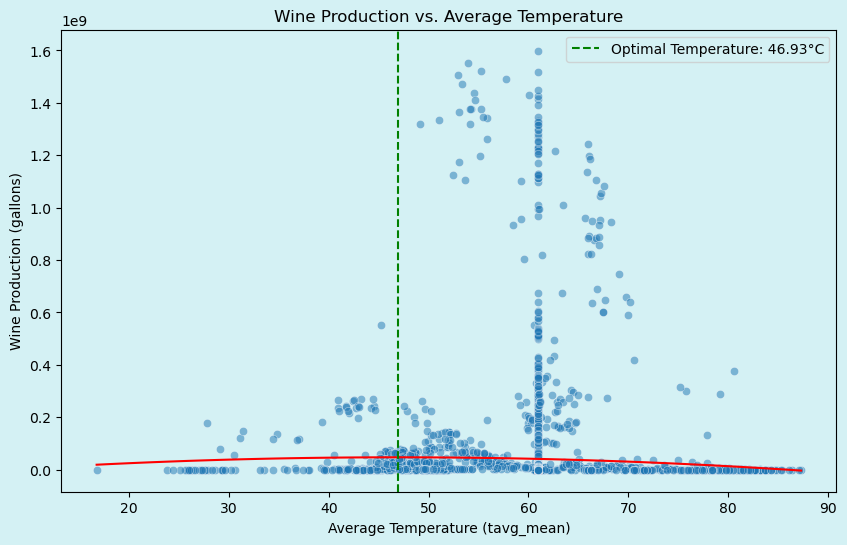

In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Drop rows with missing production values
filtered_data = filtered_data.dropna(subset=['Gallons'])

# Fill missing values in weather data with the mean of the respective column
weather_columns = ['dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
filtered_data[weather_columns] = filtered_data[weather_columns].fillna(filtered_data[weather_columns].mean())

# Create a quadratic term for average temperature
filtered_data['tavg_mean_squared'] = filtered_data['tavg_mean'] ** 2

# Select relevant columns for the regression model
X = filtered_data[['tavg_mean', 'tavg_mean_squared']]
y = filtered_data['Gallons']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
quadratic_model = sm.OLS(y, X).fit()

# Model summary
print(quadratic_model.summary())

# Calculate the optimal temperature
optimal_temperature = -quadratic_model.params['tavg_mean'] / (2 * quadratic_model.params['tavg_mean_squared'])
print(f"The optimal average temperature for maximum production is approximately {optimal_temperature:.2f} degrees.")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tavg_mean', y='Gallons', data=filtered_data, alpha=0.5)
tavg_mean_range = np.linspace(filtered_data['tavg_mean'].min(), filtered_data['tavg_mean'].max(), 100)
predicted_production = quadratic_model.predict(sm.add_constant(pd.DataFrame({
    'tavg_mean': tavg_mean_range,
    'tavg_mean_squared': tavg_mean_range ** 2
})))
plt.plot(tavg_mean_range, predicted_production, color='red')
plt.axvline(x=optimal_temperature, color='green', linestyle='--', label=f'Optimal Temperature: {optimal_temperature:.2f}°C')
plt.title('Wine Production vs. Average Temperature')
plt.xlabel('Average Temperature (tavg_mean)')
plt.ylabel('Wine Production (gallons)')
plt.legend()
plt.show()


# What is the optimal precipitation for wine production?

                            OLS Regression Results                            
Dep. Variable:                Gallons   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     85.79
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           2.22e-37
Time:                        15:22:10   Log-Likelihood:            -1.0529e+05
No. Observations:                5179   AIC:                         2.106e+05
Df Residuals:                    5176   BIC:                         2.106e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.399e+08   8.19e+0

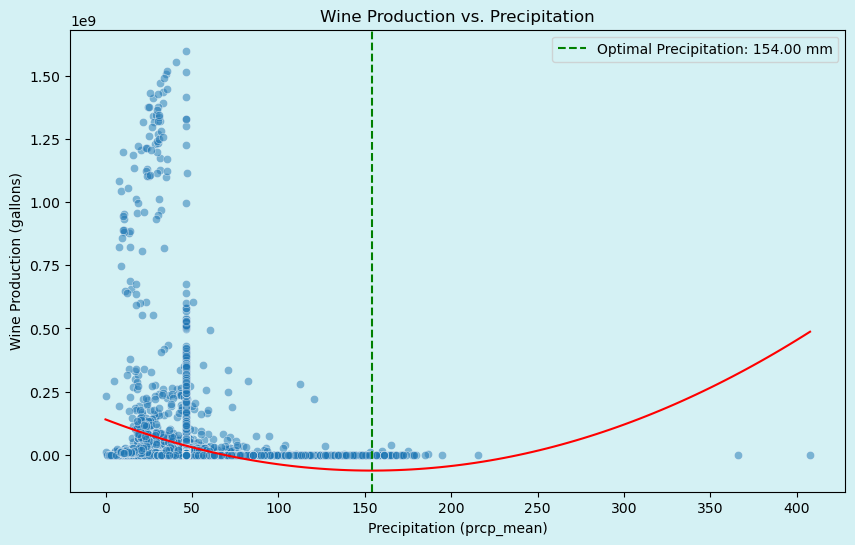

In [33]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Drop rows with missing production values
filtered_data = filtered_data.dropna(subset=['Gallons'])

# Fill missing values in weather data with the mean of the respective column
weather_columns = ['dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
filtered_data[weather_columns] = filtered_data[weather_columns].fillna(filtered_data[weather_columns].mean())

# Create a quadratic term for precipitation
filtered_data['prcp_mean_squared'] = filtered_data['prcp_mean'] ** 2

# Select relevant columns for the regression model
X = filtered_data[['prcp_mean', 'prcp_mean_squared']]
y = filtered_data['Gallons']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
quadratic_model = sm.OLS(y, X).fit()

# Model summary
print(quadratic_model.summary())

# Calculate the optimal precipitation
optimal_precipitation = -quadratic_model.params['prcp_mean'] / (2 * quadratic_model.params['prcp_mean_squared'])
print(f"The optimal average precipitation for maximum production is approximately {optimal_precipitation:.2f} mm.")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='prcp_mean', y='Gallons', data=filtered_data, alpha=0.5)
prcp_mean_range = np.linspace(filtered_data['prcp_mean'].min(), filtered_data['prcp_mean'].max(), 100)
predicted_production = quadratic_model.predict(sm.add_constant(pd.DataFrame({
    'prcp_mean': prcp_mean_range,
    'prcp_mean_squared': prcp_mean_range ** 2
})))
plt.plot(prcp_mean_range, predicted_production, color='red')
plt.axvline(x=optimal_precipitation, color='green', linestyle='--', label=f'Optimal Precipitation: {optimal_precipitation:.2f} mm')
plt.title('Wine Production vs. Precipitation')
plt.xlabel('Precipitation (prcp_mean)')
plt.ylabel('Wine Production (gallons)')
plt.legend()
plt.show()


# Can we determine if climate had a postive or negative impact on production for any countries?

Initial Filtered Data
       country  year  Quantity_hl  Gallons code  dp10_mean  dp10_std  \
0  Afghanistan  1995          0.0      0.0   AF        NaN       NaN   
1  Afghanistan  1996          0.0      0.0   AF        NaN       NaN   
2  Afghanistan  1997          0.0      0.0   AF        NaN       NaN   
3  Afghanistan  1998          0.0      0.0   AF        NaN       NaN   
4  Afghanistan  1999          0.0      0.0   AF        NaN       NaN   

   dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
0        NaN       NaN        NaN  ...        NaN       NaN        NaN   
1        NaN       NaN        NaN  ...        NaN       NaN        NaN   
2        NaN       NaN        NaN  ...        NaN       NaN        NaN   
3        NaN       NaN        NaN  ...        NaN       NaN        NaN   
4        NaN       NaN        NaN  ...        NaN       NaN        NaN   

   mxpn_std  prcp_mean  prcp_std  tavg_mean  tavg_std  tmax_mean  tmax_std  
0       NaN        NaN 

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\regression\linear_model.py:1783:

Results DataFrame
          country  coef_tavg_diff  pvalue_tavg_diff  coef_prcp_diff  \
0     Afghanistan        0.000000               NaN        0.000000   
1         Albania        0.000000               NaN    49735.551192   
2         Algeria  -247569.209035          0.608228   -37689.332966   
3  American Samoa        0.000000               NaN        0.000000   
4          Angola        0.000000               NaN        0.000000   

   pvalue_prcp_diff  r_squared  
0               NaN        NaN  
1          0.073715   0.122332  
2          0.640368   0.011620  
3               NaN        NaN  
4               NaN        NaN  
Index(['country', 'coef_tavg_diff', 'pvalue_tavg_diff', 'coef_prcp_diff',
       'pvalue_prcp_diff', 'r_squared'],
      dtype='object')
Significant Countries
                      country  coef_tavg_diff  pvalue_tavg_diff  \
7                     Armenia   -4.871547e+04          0.004985   
9                     Austria    7.405433e+05          0.294977 

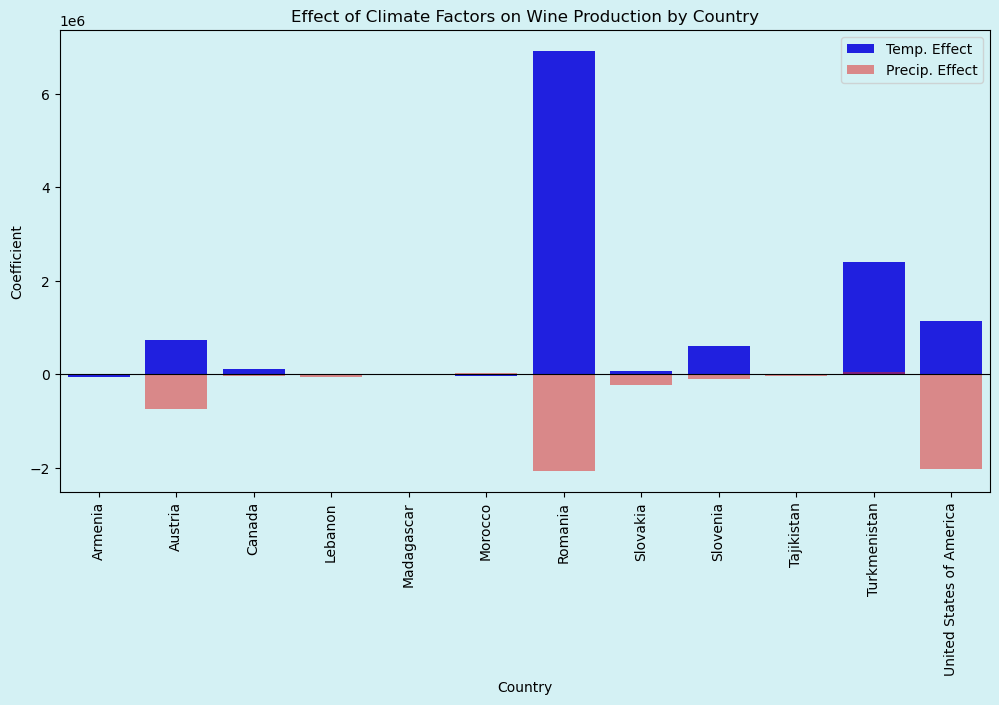

In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
wine_weather_data = pd.read_csv('Outputs/merged_wine_weather_for_regions_data.csv')

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Drop rows with missing production values
filtered_data = filtered_data.dropna(subset=['Gallons'])

# Debugging step: Check the initial filtered data
print("Initial Filtered Data")
print(filtered_data.head())
print(f"Initial Filtered Data Shape: {filtered_data.shape}")

# Fill missing values in weather data with the mean of the respective column
weather_columns = ['dp10_mean', 'dp1x_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
filtered_data[weather_columns] = filtered_data[weather_columns].fillna(filtered_data[weather_columns].mean())

# Check the number of years for each country
country_years = filtered_data.groupby('country')['year'].nunique()
print("Number of years of data per country:")
print(country_years)

# Filter countries with at least 2 years of data
sufficient_data_countries = country_years[country_years > 1].index
filtered_data = filtered_data[filtered_data['country'].isin(sufficient_data_countries)]

# Calculate year-over-year changes in production and climate factors
filtered_data.sort_values(by=['country', 'year'], inplace=True)
filtered_data['production_diff'] = filtered_data.groupby('country')['Gallons'].diff()
filtered_data['tavg_diff'] = filtered_data.groupby('country')['tavg_mean'].diff()
filtered_data['prcp_diff'] = filtered_data.groupby('country')['prcp_mean'].diff()

# Debugging step: Check the data after calculating year-over-year changes
print("Data After Calculating Year-over-Year Changes")
print(filtered_data[['country', 'year', 'production_diff', 'tavg_diff', 'prcp_diff']].head())

# Drop rows with missing differences
filtered_data = filtered_data.dropna(subset=['production_diff', 'tavg_diff', 'prcp_diff'])

# Debugging step: Check the processed data
print("Processed Data After Dropping NaNs")
print(filtered_data.head())
print(f"Processed Data Shape: {filtered_data.shape}")

# Analyze the relationship between climate factors and production for each country
results = []
for country, group in filtered_data.groupby('country'):
    if group.shape[0] > 1:  # Ensure there are enough data points for regression
        X = group[['tavg_diff', 'prcp_diff']]
        y = group['production_diff']
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        results.append({
            'country': country,
            'coef_tavg_diff': model.params.get('tavg_diff', np.nan),
            'pvalue_tavg_diff': model.pvalues.get('tavg_diff', np.nan),
            'coef_prcp_diff': model.params.get('prcp_diff', np.nan),
            'pvalue_prcp_diff': model.pvalues.get('prcp_diff', np.nan),
            'r_squared': model.rsquared
        })
    else:
        print(f"Not enough data for country: {country}")

# Check if results are being collected
if results:
    results_df = pd.DataFrame(results)

    # Print the DataFrame to debug the column names and first few rows
    print("Results DataFrame")
    print(results_df.head())
    print(results_df.columns)

    # Identify countries with significant changes
    significant_countries = results_df[(results_df['pvalue_tavg_diff'] < 0.05) | (results_df['pvalue_prcp_diff'] < 0.05)]

    # Display significant countries
    print("Significant Countries")
    print(significant_countries)

    # Visualize results
    plt.figure(figsize=(12, 6))
    sns.barplot(x='country', y='coef_tavg_diff', data=significant_countries, color='blue', label='Temp. Effect')
    sns.barplot(x='country', y='coef_prcp_diff', data=significant_countries, color='red', label='Precip. Effect', alpha=0.5)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title('Effect of Climate Factors on Wine Production by Country')
    plt.xlabel('Country')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
else:
    print("No results to display")


Correlations for Countries with Increasing Production:
country
Albania                        1.0
Armenia                        1.0
Australia                      1.0
Austria                        1.0
Azerbaijan                     1.0
Belarus                        1.0
Belgium                        1.0
Bolivia                        1.0
Bosnia and Herzegovina         1.0
Brazil                         1.0
Canada                         1.0
Chile                          1.0
Cuba                           1.0
Czech Republic                 1.0
Denmark                        1.0
Egypt                          1.0
Estonia                        1.0
Germany                        1.0
India                          1.0
Israel                         1.0
Japan                          1.0
Kazakhstan                     1.0
Lithuania                      1.0
Morocco                        1.0
New Zealand                    1.0
Peru                           1.0
Poland                     

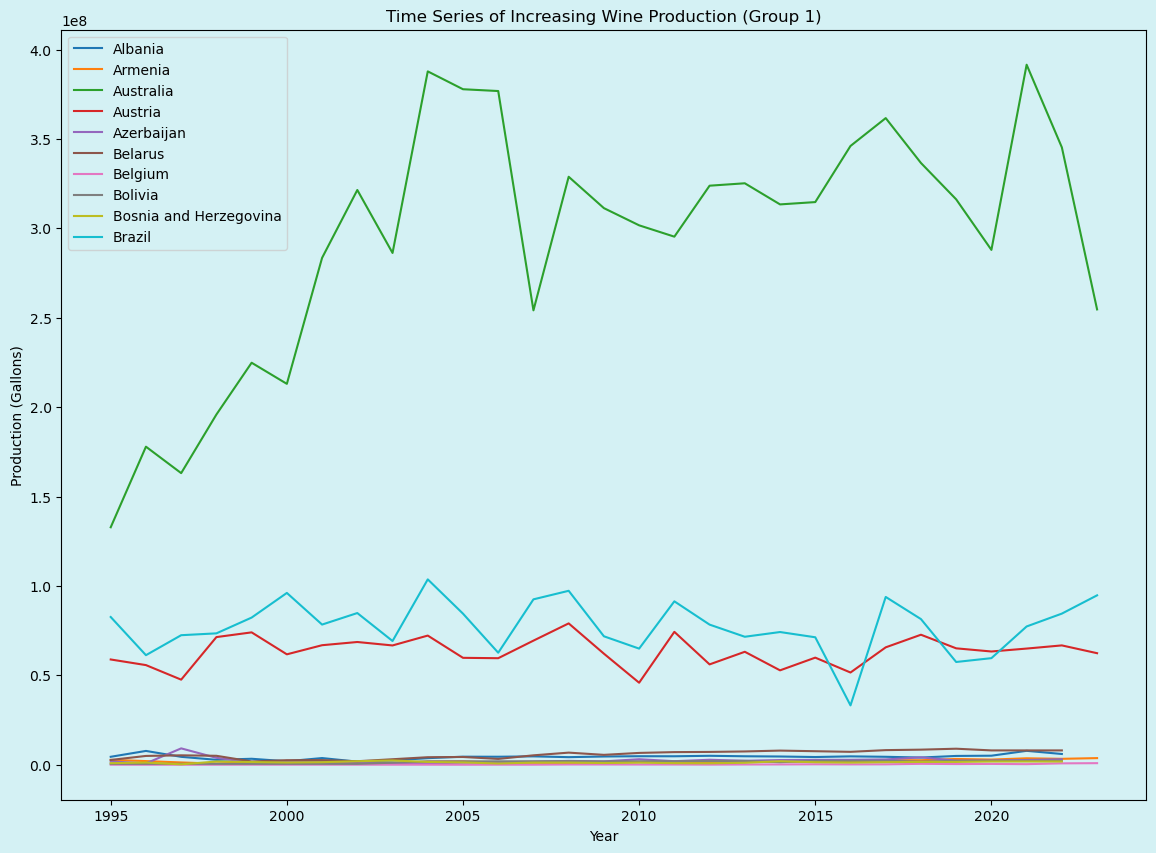

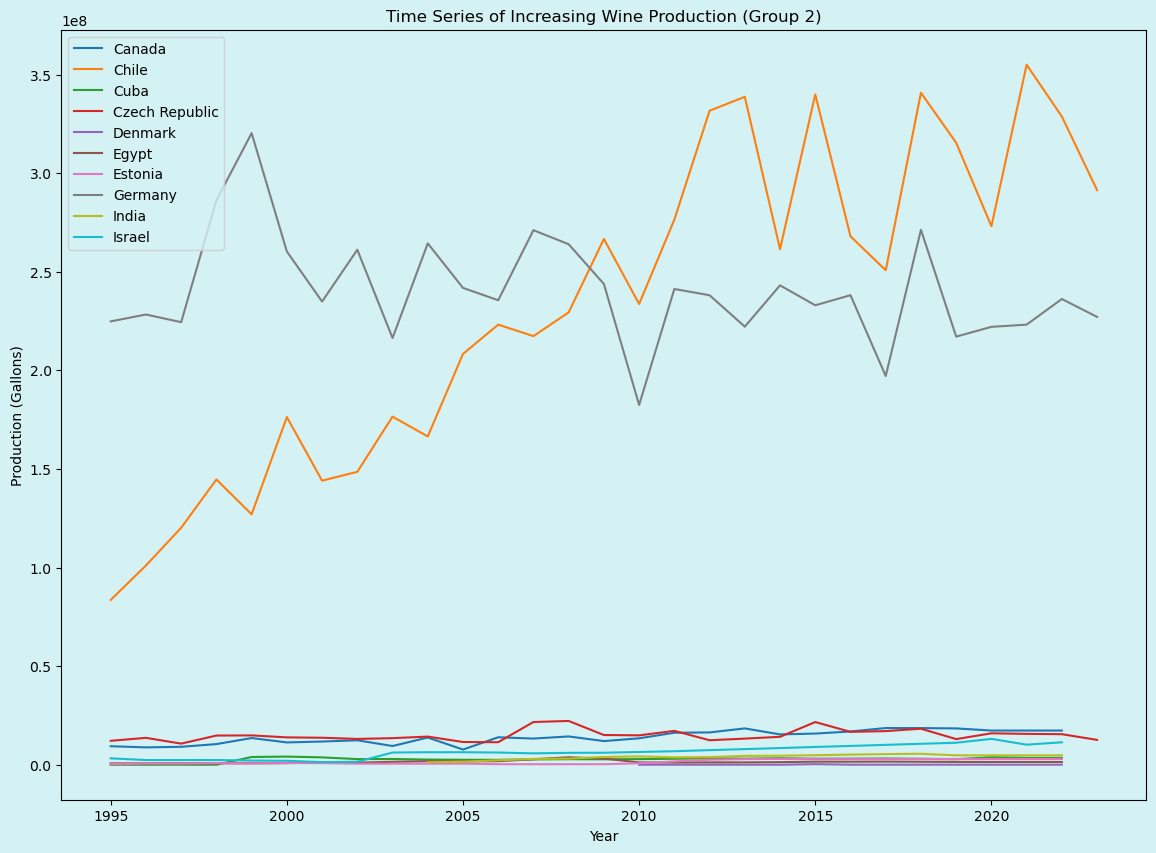

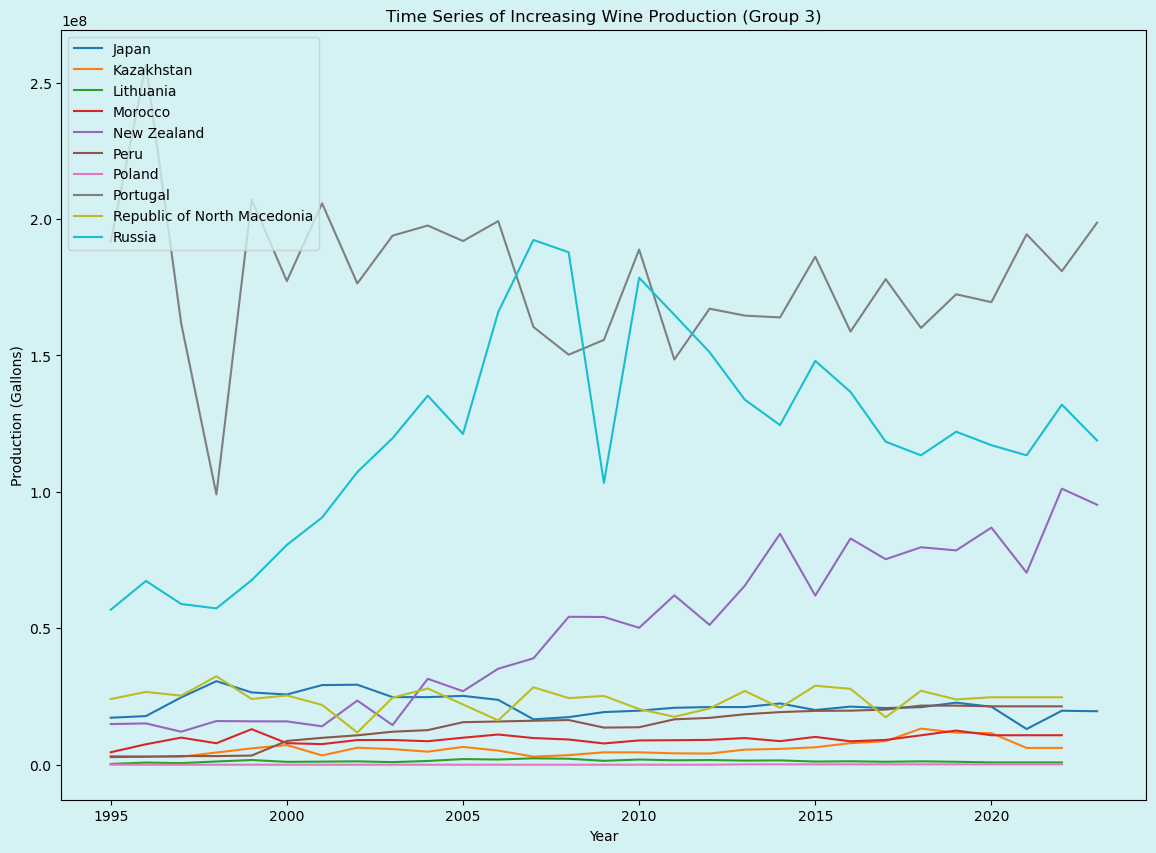

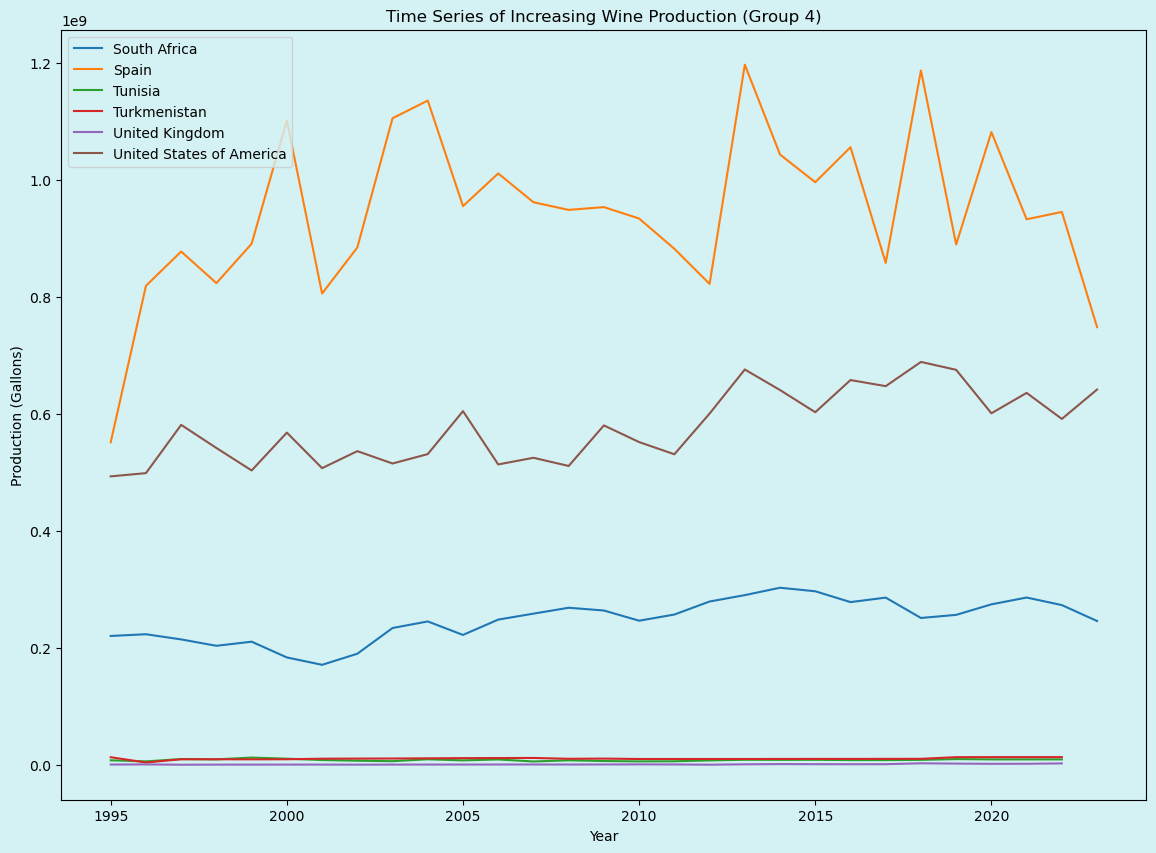

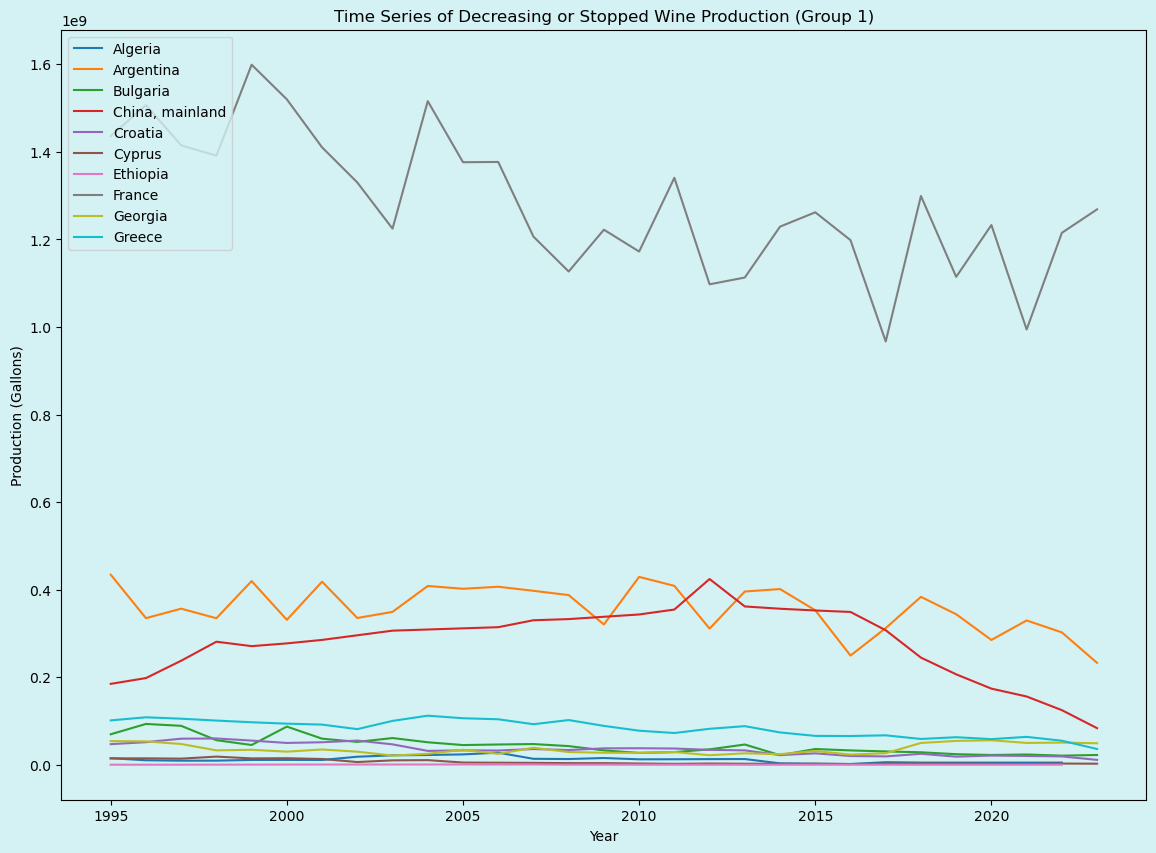

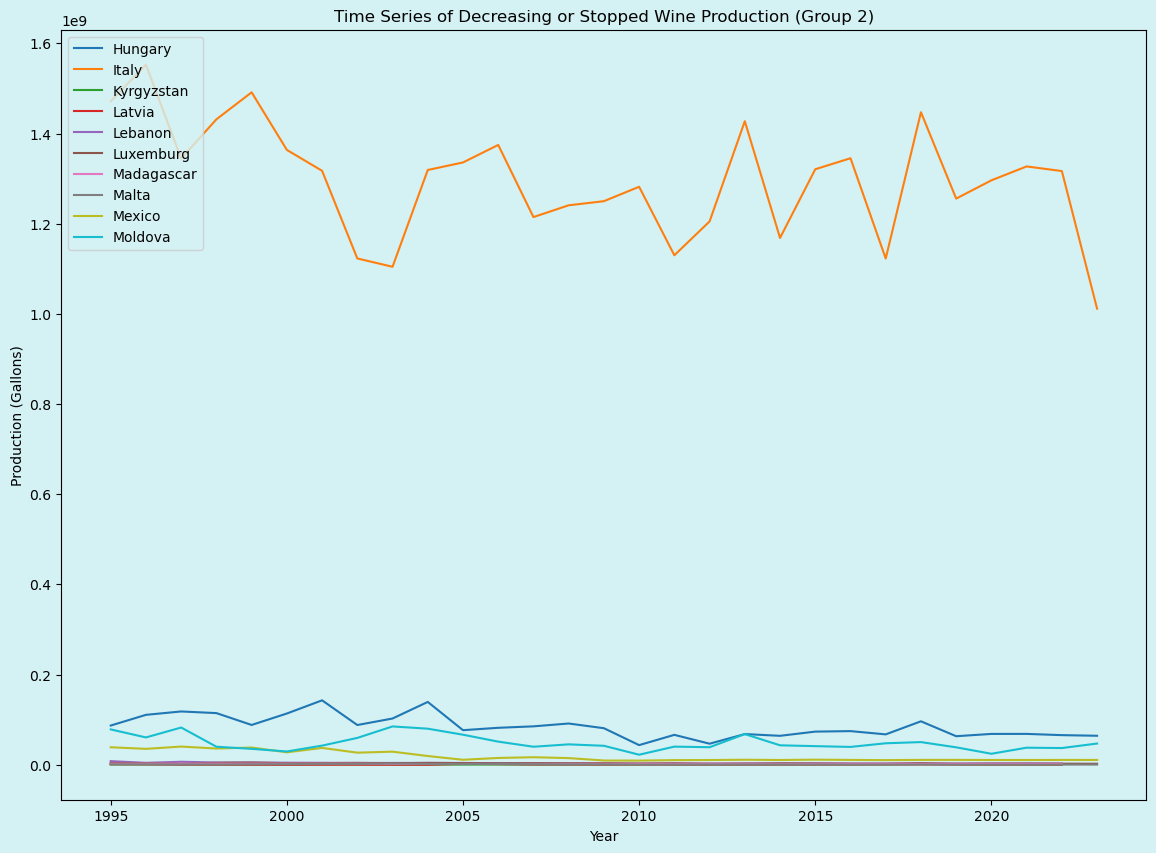

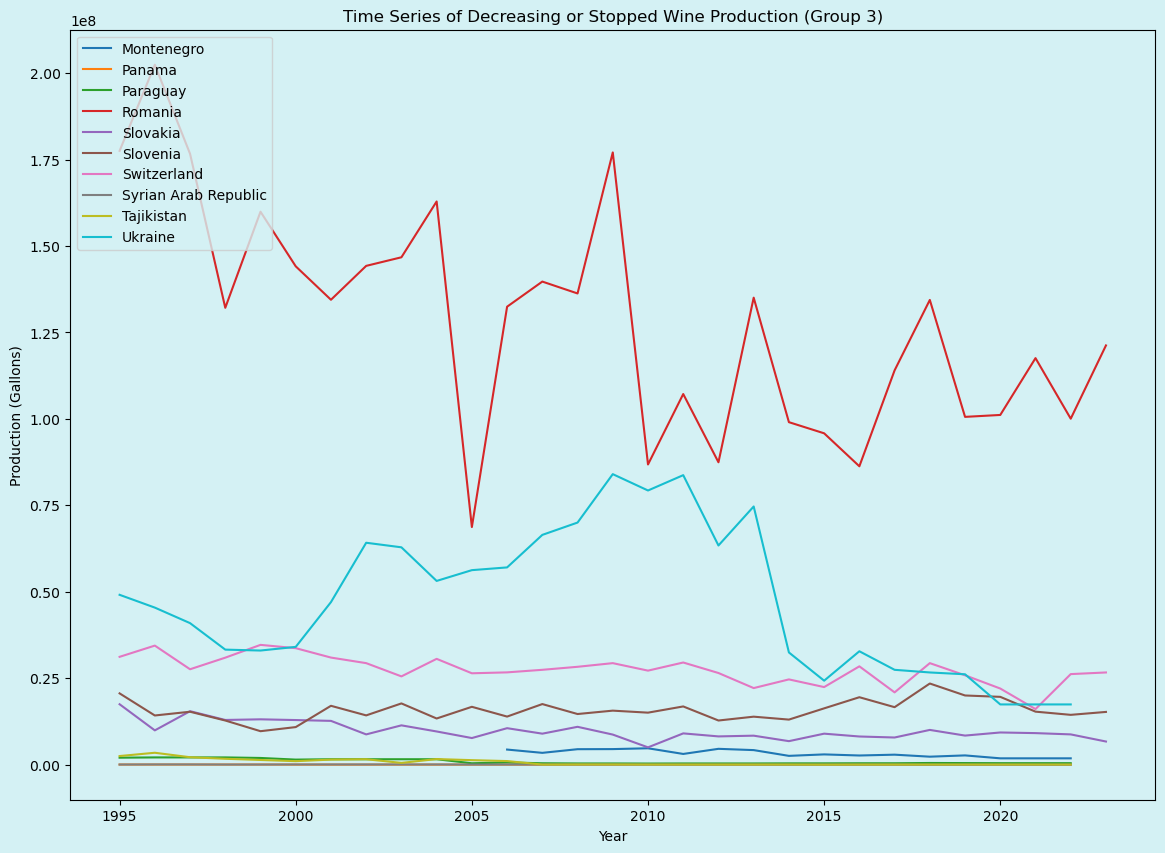

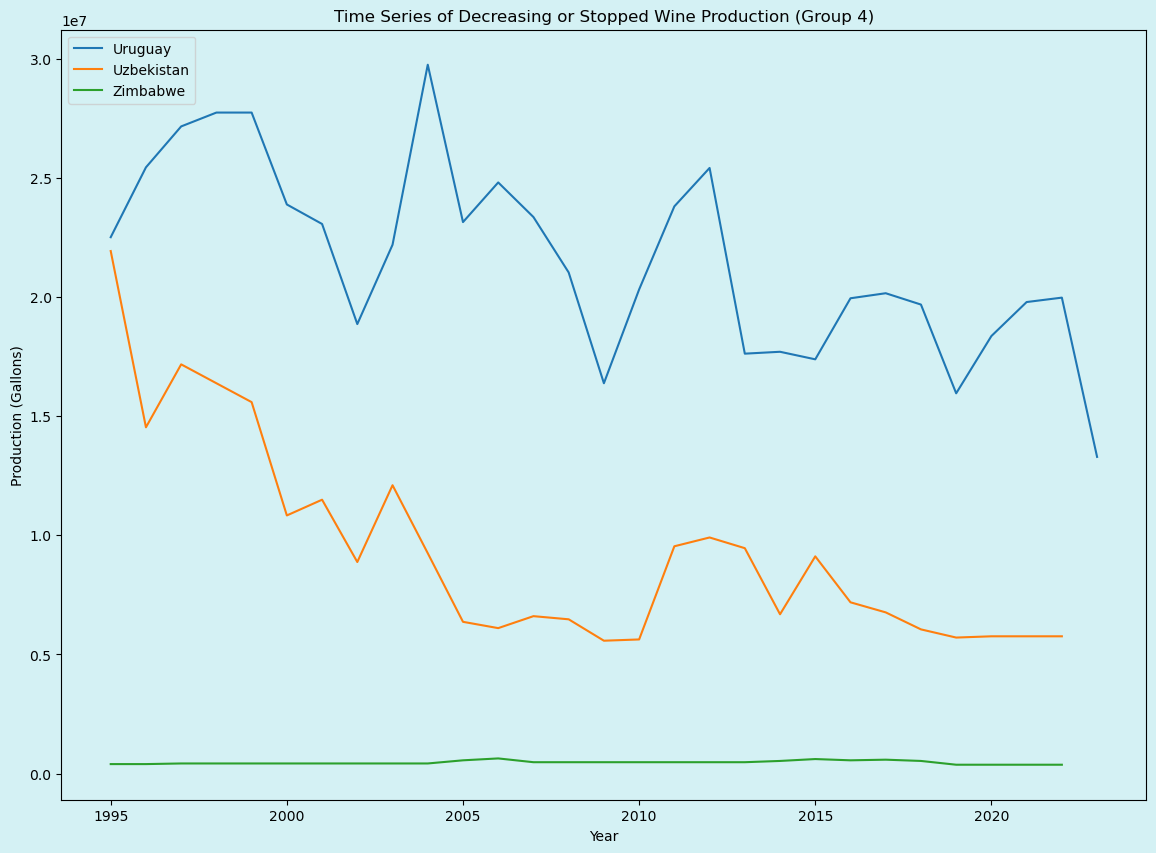

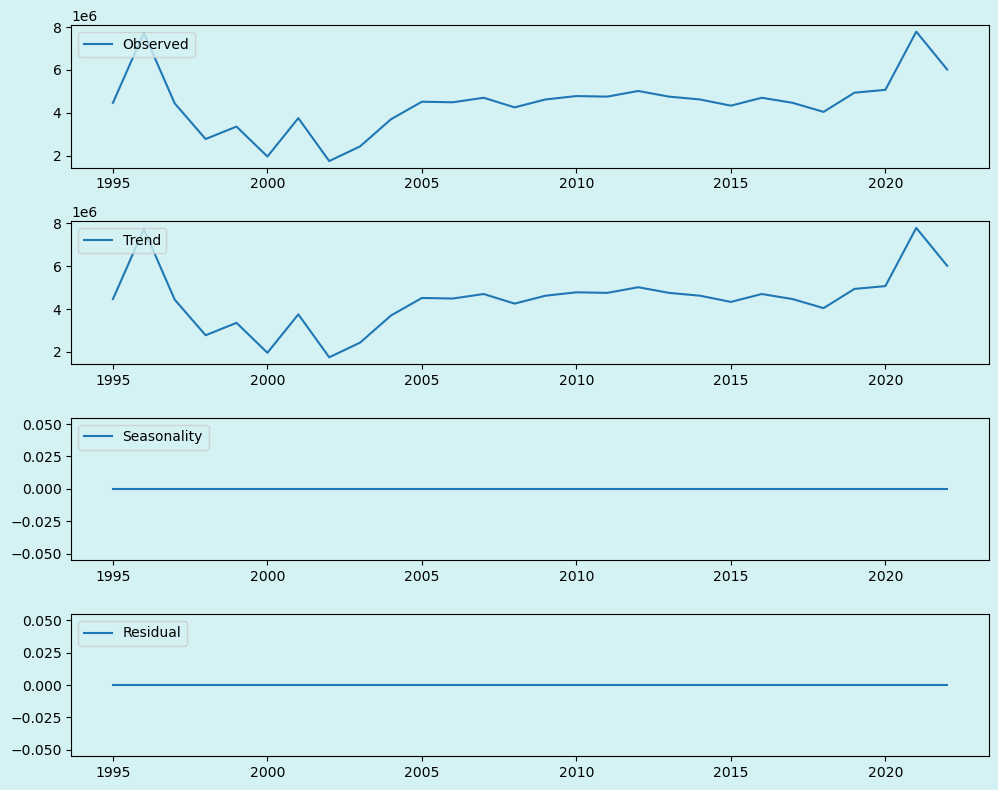

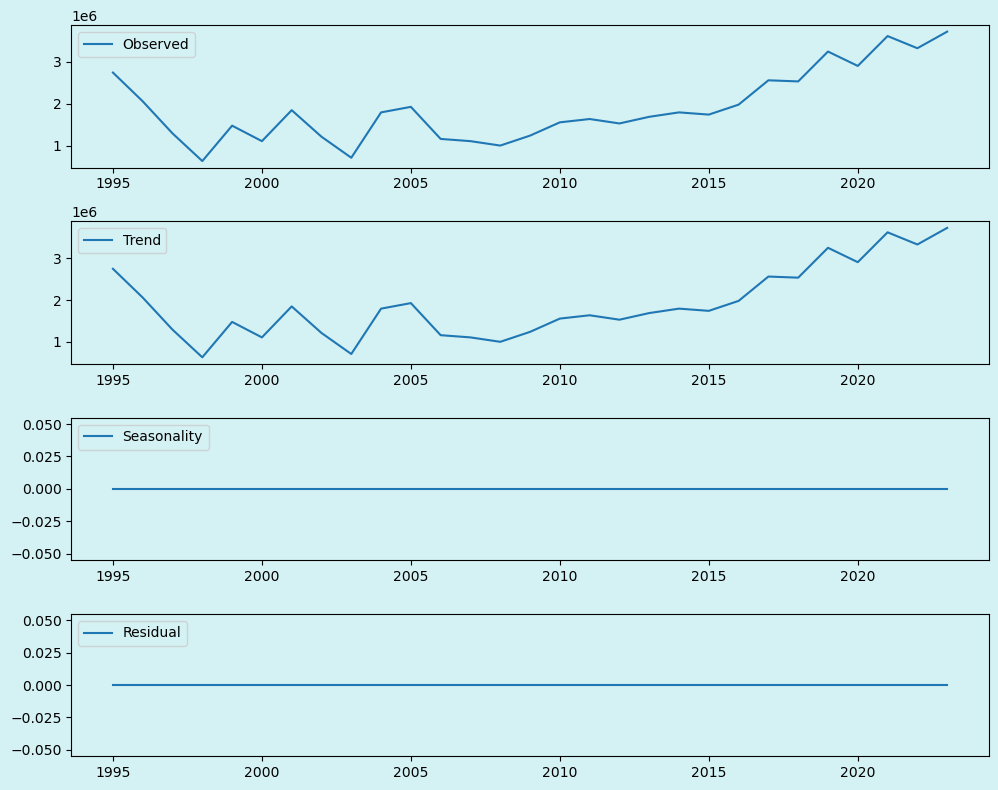

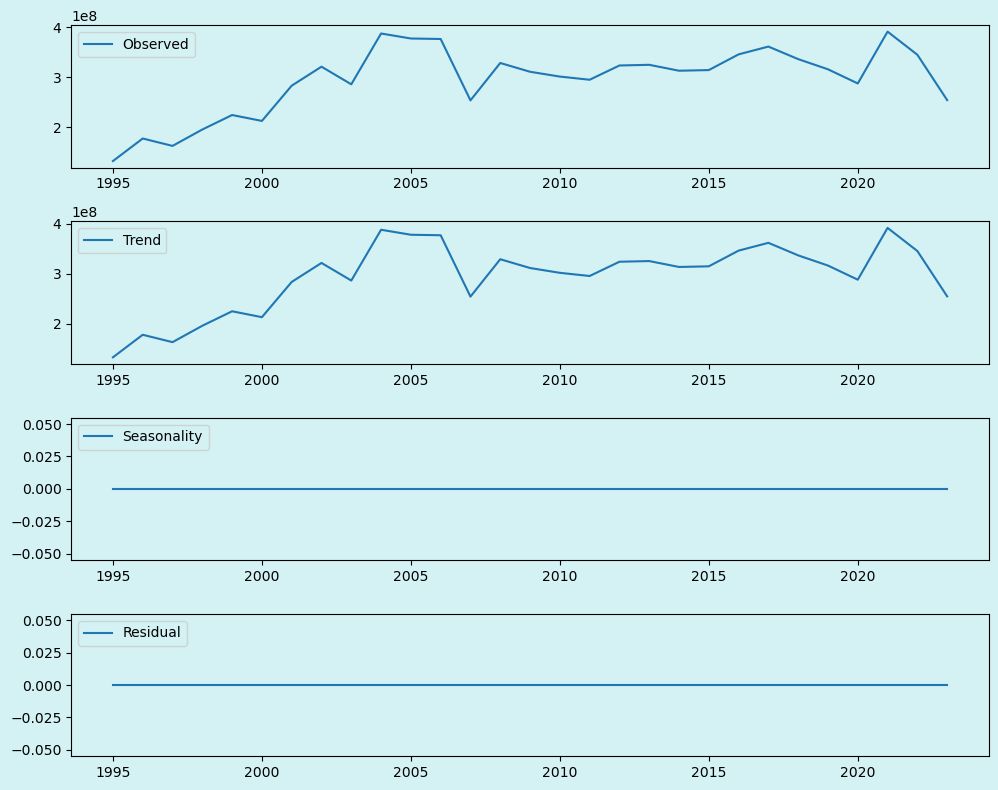

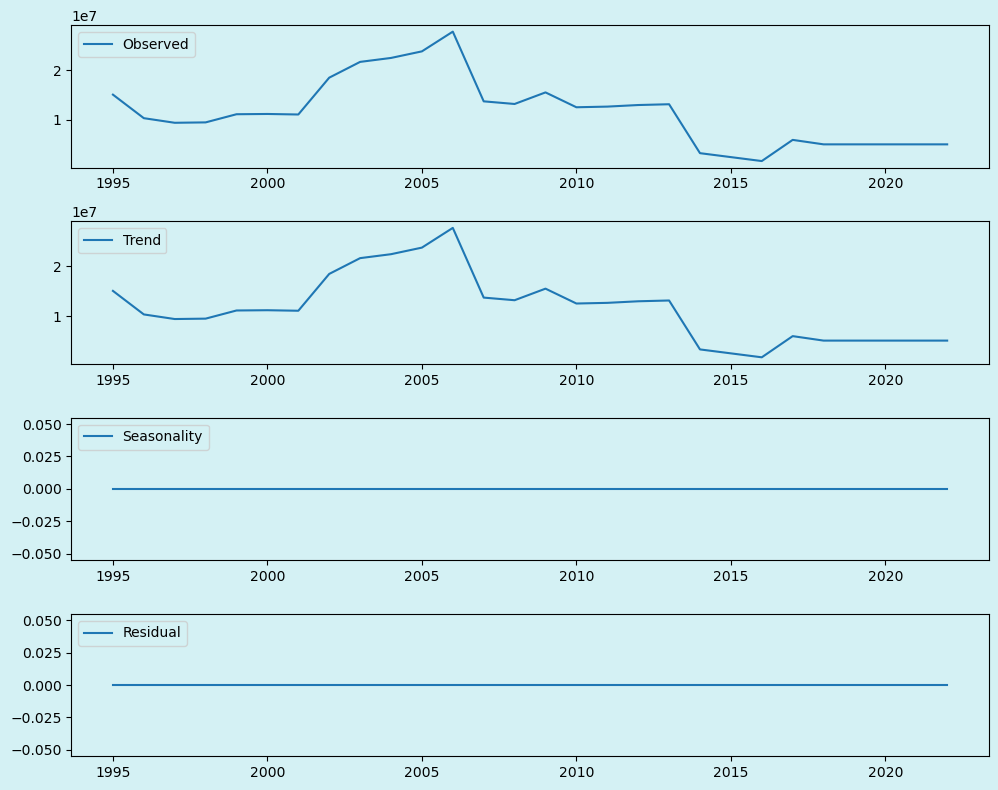

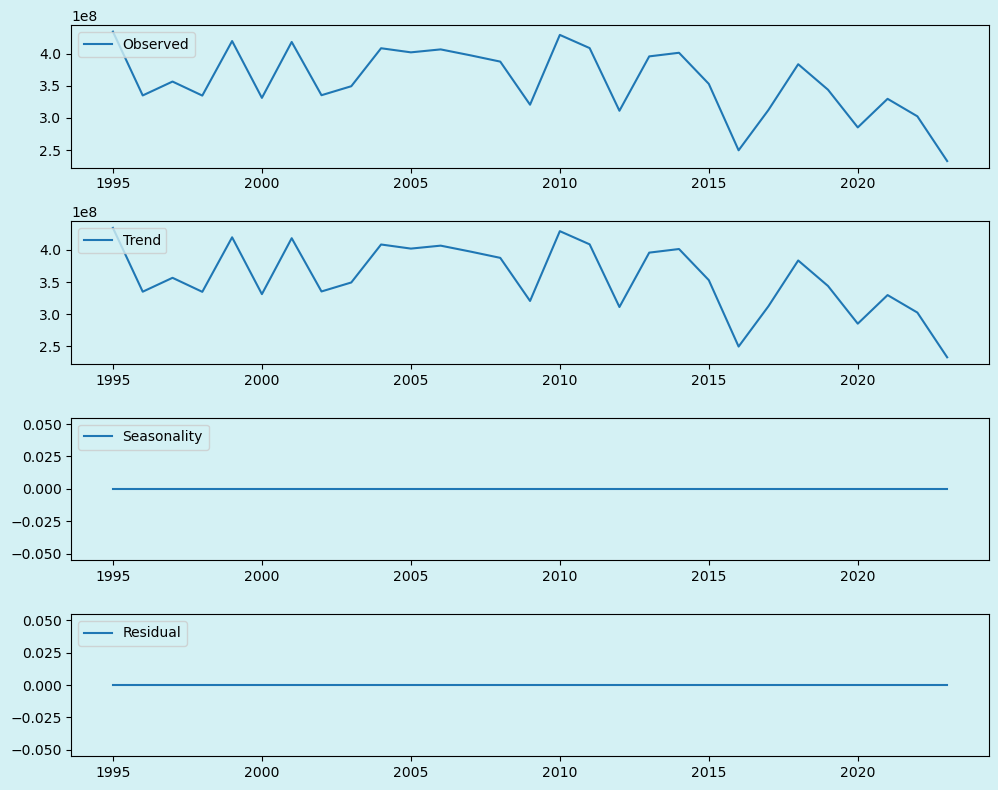

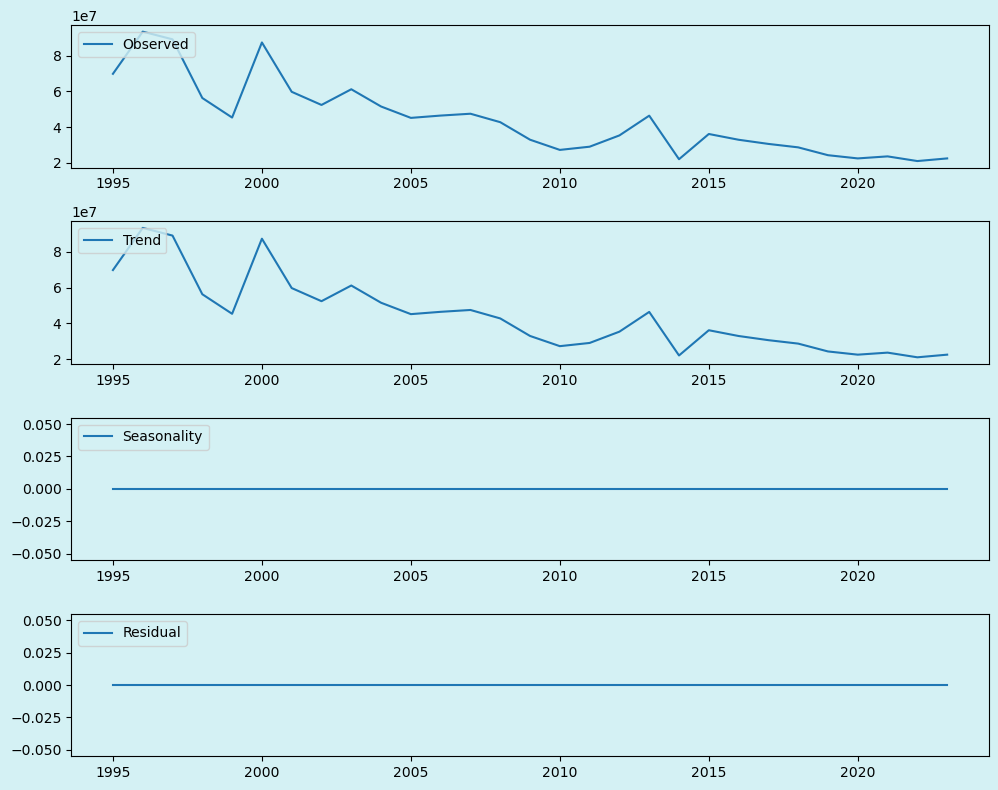

ADF Statistic for Albania: -2.791475106542348
p-value: 0.05950184436861263
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.627601001371742
ADF Statistic for Armenia: -0.4054109759156764
p-value: 0.9091914105127485
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.627601001371742
ADF Statistic for Australia: -3.736565244032122
p-value: 0.003627259461555214
Critical Values:
	1%: -3.7529275211638033
	5%: -2.998499866852963
	10%: -2.6389669754253307
ADF Statistic for Algeria: -1.4667559246851487
p-value: 0.5498879627224391
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.627601001371742
ADF Statistic for Argentina: -1.1665841714400402
p-value: 0.6878027116795001
Critical Values:
	1%: -3.7112123008648155
	5%: -2.981246804733728
	10%: -2.6300945562130176
ADF Statistic for Bulgaria: -2.2644132928023084
p-value: 0.18370230992110503
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.6276010

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction 

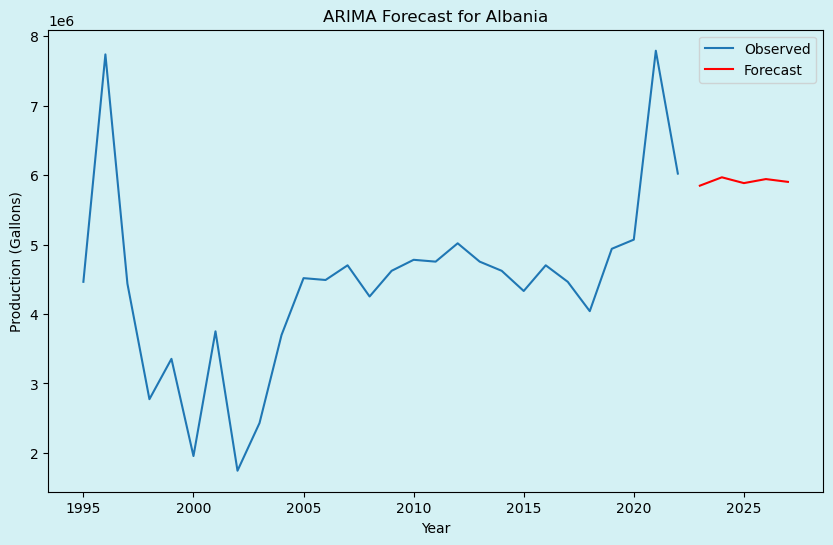

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is availab

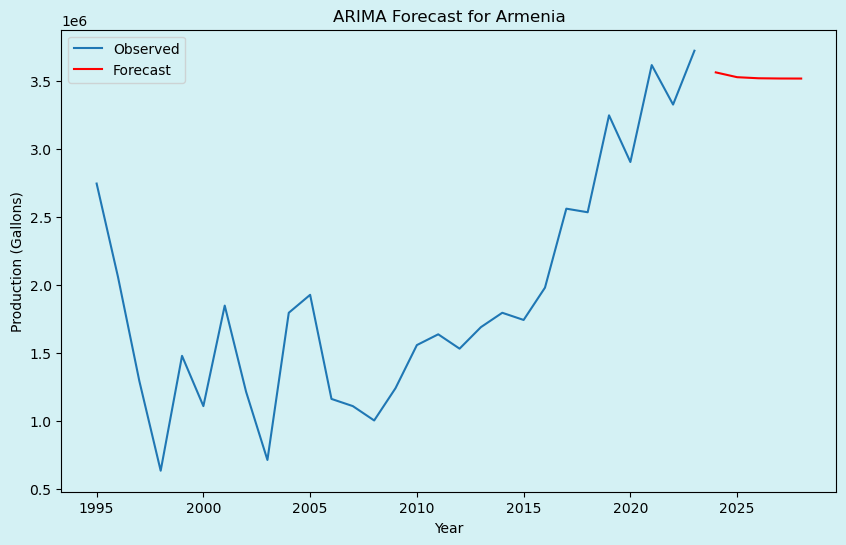

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is availab

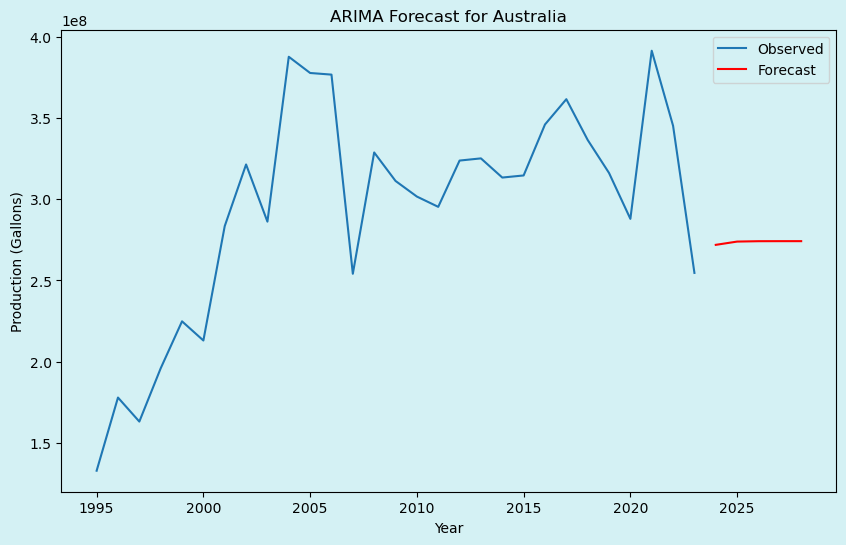

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is availab

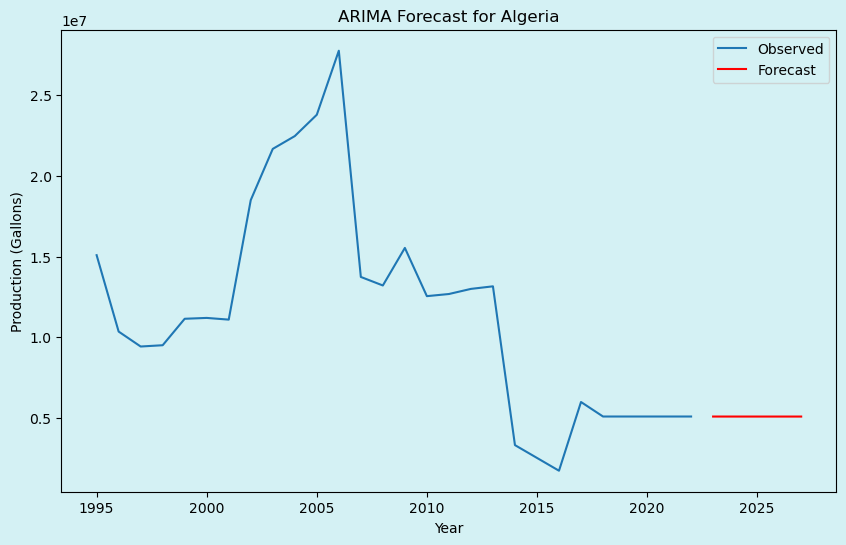

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will

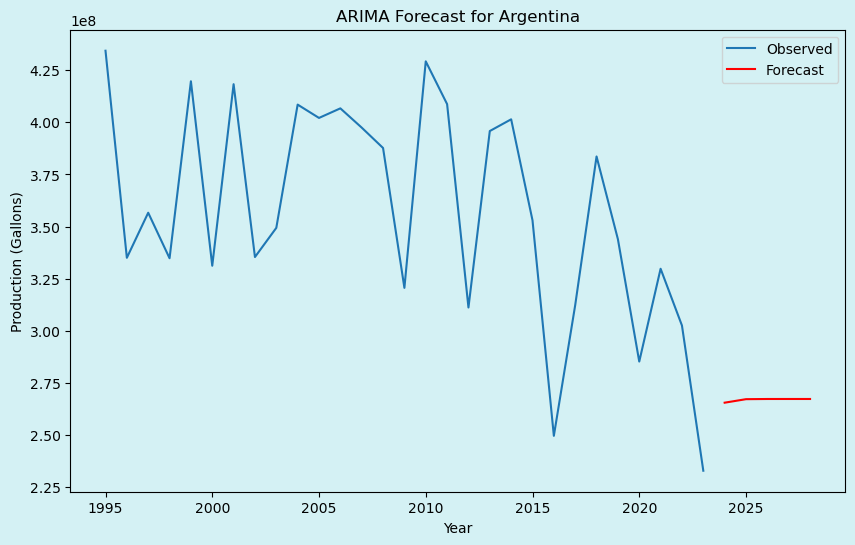

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\tfregoso\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is availab

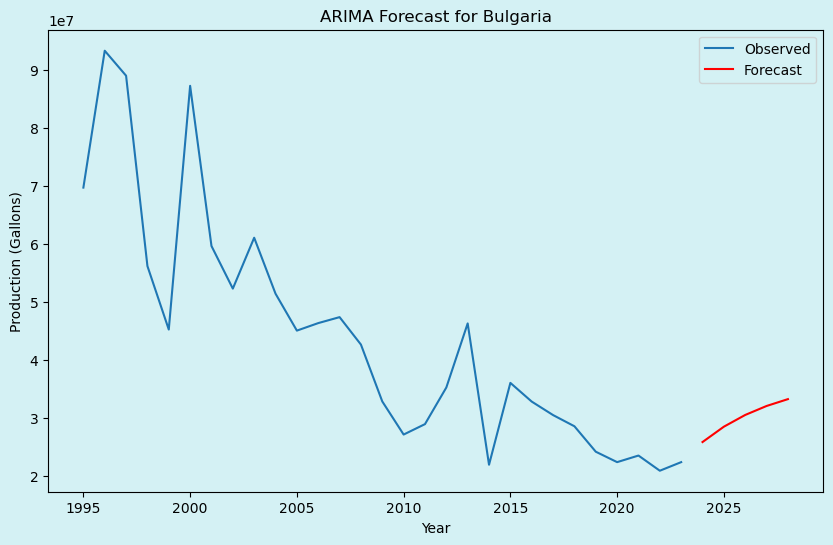

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the dataset
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
data = pd.read_csv(file_path)

# Filter out rows where production data is not available
filtered_data = data.dropna(subset=['Gallons'])

# Ensure the data is sorted by year
filtered_data = filtered_data.sort_values(by=['country', 'year'])

# Calculate the mean production by country and year
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()

# Calculate the change in production for each country
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Remove countries with essentially zero production
non_zero_production_countries = mean_production.groupby('country')['Gallons'].mean()
non_zero_production_countries = non_zero_production_countries[non_zero_production_countries > 0].index

filtered_data = filtered_data[filtered_data['country'].isin(non_zero_production_countries)]

# Recalculate production changes
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Separate countries into those with increasing production and those with decreasing/stopped production
increasing_production_countries = mean_production.groupby('country')['production_change'].sum()
increasing_production_countries = increasing_production_countries[increasing_production_countries > 0].index

decreasing_production_countries = mean_production.groupby('country')['production_change'].sum()
decreasing_production_countries = decreasing_production_countries[decreasing_production_countries <= 0].index

# Filter data for these countries
increasing_data = filtered_data[filtered_data['country'].isin(increasing_production_countries)]
decreasing_data = filtered_data[filtered_data['country'].isin(decreasing_production_countries)]

# Function to calculate correlation between production and climate factors
def calculate_correlations(data):
    climate_factors_mean = ['dp10_mean', 'dp1x_mean', 'dt32_mean', 'mnpn_mean', 'mxpn_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
    correlations = data.groupby('country')[climate_factors_mean + ['Gallons']].corr().unstack().iloc[:, -1]
    return correlations

# Calculate correlations for increasing and decreasing production countries
increasing_correlations = calculate_correlations(increasing_data)
decreasing_correlations = calculate_correlations(decreasing_data)

# Display correlation results
print("Correlations for Countries with Increasing Production:")
print(increasing_correlations)

print("\nCorrelations for Countries with Decreasing or Stopped Production:")
print(decreasing_correlations)

# Plotting time series for increasing and decreasing production countries
def plot_time_series_grouped(data, countries, title):
    plt.figure(figsize=(14, 10))
    for country in countries:
        country_data = data[data['country'] == country]
        plt.plot(country_data['year'], country_data['Gallons'], label=country)
    plt.xlabel('Year')
    plt.ylabel('Production (Gallons)')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

# Group the data and plot time series
def plot_grouped_time_series(data, countries, group_size, title_prefix):
    for i in range(0, len(countries), group_size):
        group = countries[i:i+group_size]
        plot_time_series_grouped(data, group, f"{title_prefix} (Group {i//group_size + 1})")

# Plot time series for increasing and decreasing production countries in groups
plot_grouped_time_series(filtered_data, increasing_production_countries, 10, "Time Series of Increasing Wine Production")
plot_grouped_time_series(filtered_data, decreasing_production_countries, 10, "Time Series of Decreasing or Stopped Wine Production")

# Decomposing time series to identify trend, seasonality, and residuals
def decompose_time_series(data, countries):
    for country in countries:
        country_data = data[data['country'] == country]
        country_data.set_index('year', inplace=True)
        decomposition = seasonal_decompose(country_data['Gallons'], model='additive', period=1)
        
        # Plot the decomposed components
        plt.figure(figsize=(10, 8))
        plt.subplot(411)
        plt.plot(decomposition.observed, label='Observed')
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residual')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

# Decompose time series for a few sample countries
decompose_time_series(filtered_data, increasing_production_countries[:3])
decompose_time_series(filtered_data, decreasing_production_countries[:3])

# Perform ADF test to check for stationarity
def adf_test(series, country):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {country}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Perform ADF test for a few sample countries
for country in increasing_production_countries[:3]:
    country_data = filtered_data[filtered_data['country'] == country]
    adf_test(country_data['Gallons'], country)

for country in decreasing_production_countries[:3]:
    country_data = filtered_data[filtered_data['country'] == country]
    adf_test(country_data['Gallons'], country)

# Forecasting future production using ARIMA model
def forecast_time_series(data, countries, steps=5):
    for country in countries:
        country_data = data[data['country'] == country]
        country_data.set_index('year', inplace=True)
        
        # Fit ARIMA model
        model = ARIMA(country_data['Gallons'], order=(1, 1, 1))
        model_fit = model.fit()
        
        # Forecast
        forecast = model_fit.forecast(steps=steps)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(country_data.index, country_data['Gallons'], label='Observed')
        plt.plot(range(country_data.index[-1] + 1, country_data.index[-1] + 1 + steps), forecast, label='Forecast', color='red')
        plt.xlabel('Year')
        plt.ylabel('Production (Gallons)')
        plt.title(f'ARIMA Forecast for {country}')
        plt.legend()
        plt.show()

# Forecast time series for a few sample countries
forecast_time_series(filtered_data, increasing_production_countries[:3])
forecast_time_series(filtered_data, decreasing_production_countries[:3])


Just playing with ChatGPTs interpretation of the data

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
data = pd.read_csv(file_path)

# Filter out rows where production data is not available
filtered_data = data.dropna(subset=['Gallons'])

# Ensure the data is sorted by year
filtered_data = filtered_data.sort_values(by=['country', 'year'])

# Calculate the mean production by country and year
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()

# Calculate the change in production for each country
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Remove countries with essentially zero production
non_zero_production_countries = mean_production.groupby('country')['Gallons'].mean()
non_zero_production_countries = non_zero_production_countries[non_zero_production_countries > 0].index

filtered_data = filtered_data[filtered_data['country'].isin(non_zero_production_countries)]

# Recalculate production changes
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Separate countries into those with increasing production and those with decreasing/stopped production
increasing_production_countries = mean_production.groupby('country')['production_change'].sum()
increasing_production_countries = increasing_production_countries[increasing_production_countries > 0].index

decreasing_production_countries = mean_production.groupby('country')['production_change'].sum()
decreasing_production_countries = decreasing_production_countries[decreasing_production_countries <= 0].index

# Filter data for these countries
increasing_data = filtered_data[filtered_data['country'].isin(increasing_production_countries)]
decreasing_data = filtered_data[filtered_data['country'].isin(decreasing_production_countries)]

# Function to calculate correlation between production and climate factors
def calculate_correlations(data):
    climate_factors_mean = ['dp10_mean', 'dp1x_mean', 'dt32_mean', 'mnpn_mean', 'mxpn_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']
    correlations = data.groupby('country')[climate_factors_mean + ['Gallons']].corr().unstack()
    return correlations

increasing_correlations = calculate_correlations(increasing_data)
decreasing_correlations = calculate_correlations(decreasing_data)

# Extract correlation values for 'Gallons'
increasing_corr_values = increasing_correlations.xs('Gallons', level=1, axis=1)
decreasing_corr_values = decreasing_correlations.xs('Gallons', level=1, axis=1)

# Filter significant correlations
significant_threshold = 0.5
top_increasing_correlations = increasing_corr_values.abs()[increasing_corr_values.abs() > significant_threshold].index
top_decreasing_correlations = decreasing_corr_values.abs()[decreasing_corr_values.abs() > significant_threshold].index

# Combine top factors from both increasing and decreasing production countries
top_factors = list(set(top_increasing_correlations).union(set(top_decreasing_correlations)))

# Ensure top factors are actually climate factors
top_factors = [factor for factor in top_factors if factor in filtered_data.columns]

# Debug: Print top correlated factors
print("Top Correlated Factors:\n", top_factors)

# Remove rows with missing values in top factors
filtered_data_cleaned = filtered_data.dropna(subset=top_factors)

# Debug: Print cleaned data head
print("Cleaned Data Head:\n", filtered_data_cleaned.head())

# Create a column to label whether production is increasing or decreasing/stopped
filtered_data_cleaned['production_trend'] = filtered_data_cleaned['country'].apply(
    lambda x: 'Increasing' if x in increasing_production_countries else 'Decreasing'
)

# Debug: Print the unique values in the 'production_trend' column
print("Production Trend Column Unique Values:", filtered_data_cleaned['production_trend'].unique())

# Plot violin plots for top correlated factors
if top_factors:
    for factor in top_factors:
        plt.figure(figsize=(14, 8))
        sns.violinplot(x='production_trend', y=factor, data=filtered_data_cleaned, inner='quartile')
        plt.title(f'Distribution of {factor} by Production Trend')
        plt.xlabel('Production Trend')
        plt.ylabel(factor)
        plt.show()
else:
    print("No top correlated factors identified.")


Top Correlated Factors:
 []
Cleaned Data Head:
     country  year  Quantity_hl    Gallons code  dp10_mean  dp10_std  \
28  Albania  1995        169.0  4464506.8   AL       97.0       NaN   
29  Albania  1996        293.0  7740239.6   AL      101.0       NaN   
30  Albania  1997        168.0  4438089.6   AL       70.0       NaN   
31  Albania  1998        105.0  2773806.0   AL        NaN       NaN   
32  Albania  1999        127.0  3354984.4   AL       91.0       NaN   

    dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
28       29.0       NaN        NaN  ...        NaN       NaN        NaN   
29       30.0       NaN        NaN  ...        NaN       NaN        NaN   
30       16.0       NaN        NaN  ...        NaN       NaN        NaN   
31        NaN       NaN        NaN  ...        NaN       NaN        NaN   
32       24.0       NaN        NaN  ...        NaN       NaN        NaN   

    mxpn_std  prcp_mean  prcp_std  tavg_mean  tavg_std  tmax_mean  tmax_st

ChatGPT says let Normatlize the data!

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
data = pd.read_csv(file_path)

# Filter out rows where production data is not available
filtered_data = data.dropna(subset=['Gallons'])

# Ensure the data is sorted by year
filtered_data = filtered_data.sort_values(by=['country', 'year'])

# Calculate the mean production by country and year
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()

# Calculate the change in production for each country
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Remove countries with essentially zero production
non_zero_production_countries = mean_production.groupby('country')['Gallons'].mean()
non_zero_production_countries = non_zero_production_countries[non_zero_production_countries > 0].index

filtered_data = filtered_data[filtered_data['country'].isin(non_zero_production_countries)]

# Recalculate production changes
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Separate countries into those with increasing production and those with decreasing/stopped production
increasing_production_countries = mean_production.groupby('country')['production_change'].sum()
increasing_production_countries = increasing_production_countries[increasing_production_countries > 0].index

decreasing_production_countries = mean_production.groupby('country')['production_change'].sum()
decreasing_production_countries = decreasing_production_countries[decreasing_production_countries <= 0].index

# Filter data for these countries
increasing_data = filtered_data[filtered_data['country'].isin(increasing_production_countries)]
decreasing_data = filtered_data[filtered_data['country'].isin(decreasing_production_countries)]

# Define the climate factors
climate_factors_mean = ['dp10_mean', 'dp1x_mean', 'dt32_mean', 'mnpn_mean', 'mxpn_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']

# Remove columns with no observed values
valid_climate_factors = [col for col in climate_factors_mean if col in filtered_data.columns and filtered_data[col].notna().any()]

# Function to impute missing data and normalize
def impute_and_normalize(data):
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    # Debug: Print initial shape of data
    print("Initial data shape:", data.shape)
    
    # Impute missing values
    imputed_data = imputer.fit_transform(data[valid_climate_factors + ['Gallons']])
    
    # Debug: Print shape after imputation
    print("Shape after imputation:", imputed_data.shape)
    
    # Normalize data
    normalized_data = scaler.fit_transform(imputed_data)
    
    # Debug: Print shape after normalization
    print("Shape after normalization:", normalized_data.shape)
    
    # Convert back to DataFrame
    normalized_df = pd.DataFrame(normalized_data, columns=valid_climate_factors + ['Gallons'], index=data.index)
    
    # Ensure all original columns are retained
    for col in data.columns.difference(valid_climate_factors + ['Gallons']):
        normalized_df[col] = data[col]
    
    # Debug: Print final shape of normalized DataFrame
    print("Final normalized data shape:", normalized_df.shape)
    
    return normalized_df

# Impute and normalize the data
normalized_increasing_data = impute_and_normalize(increasing_data.copy())
normalized_decreasing_data = impute_and_normalize(decreasing_data.copy())

# Function to calculate correlation between production and climate factors
def calculate_correlations(data):
    correlations = data.groupby('country')[valid_climate_factors + ['Gallons']].corr().unstack()
    return correlations

increasing_correlations = calculate_correlations(normalized_increasing_data)
decreasing_correlations = calculate_correlations(normalized_decreasing_data)

# Extract correlation values for 'Gallons'
increasing_corr_values = increasing_correlations.xs('Gallons', level=1, axis=1) if not increasing_correlations.empty else pd.DataFrame()
decreasing_corr_values = decreasing_correlations.xs('Gallons', level=1, axis=1) if not decreasing_correlations.empty else pd.DataFrame()

# Filter significant correlations
significant_threshold = 0.5
top_increasing_correlations = increasing_corr_values.abs()[increasing_corr_values.abs() > significant_threshold].index if not increasing_corr_values.empty else []
top_decreasing_correlations = decreasing_corr_values.abs()[decreasing_corr_values.abs() > significant_threshold].index if not decreasing_corr_values.empty else []

# Combine top factors from both increasing and decreasing production countries
top_factors = list(set(top_increasing_correlations).union(set(top_decreasing_correlations)))

# Ensure top factors are actually climate factors
top_factors = [factor for factor in top_factors if factor in filtered_data.columns]

# Debug: Print top correlated factors
print("Top Correlated Factors:\n", top_factors)

# Remove rows with missing values in top factors
filtered_data_cleaned = filtered_data.dropna(subset=top_factors)

# Debug: Print cleaned data head
print("Cleaned Data Head:\n", filtered_data_cleaned.head())

# Create a column to label whether production is increasing or decreasing/stopped
filtered_data_cleaned['production_trend'] = filtered_data_cleaned['country'].apply(
    lambda x: 'Increasing' if x in increasing_production_countries else 'Decreasing'
)

# Debug: Print the unique values in the 'production_trend' column
print("Production Trend Column Unique Values:", filtered_data_cleaned['production_trend'].unique())

# Plot violin plots for top correlated factors
if top_factors:
    for factor in top_factors:
        plt.figure(figsize=(14, 8))
        sns.violinplot(x='production_trend', y=factor, data=filtered_data_cleaned, inner='quartile')
        plt.title(f'Distribution of {factor} by Production Trend')
        plt.xlabel('Production Trend')
        plt.ylabel(factor)
        plt.show()
else:
    print("No top correlated factors identified.")


Initial data shape: (999, 33)
Shape after imputation: (999, 7)
Shape after normalization: (999, 7)
Final normalized data shape: (999, 33)
Initial data shape: (932, 33)
Shape after imputation: (932, 7)
Shape after normalization: (932, 7)
Final normalized data shape: (932, 33)
Top Correlated Factors:
 []
Cleaned Data Head:
     country  year  Quantity_hl    Gallons code  dp10_mean  dp10_std  \
28  Albania  1995        169.0  4464506.8   AL       97.0       NaN   
29  Albania  1996        293.0  7740239.6   AL      101.0       NaN   
30  Albania  1997        168.0  4438089.6   AL       70.0       NaN   
31  Albania  1998        105.0  2773806.0   AL        NaN       NaN   
32  Albania  1999        127.0  3354984.4   AL       91.0       NaN   

    dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
28       29.0       NaN        NaN  ...        NaN       NaN        NaN   
29       30.0       NaN        NaN  ...        NaN       NaN        NaN   
30       16.0       NaN 

Initial data shape: (999, 33)
Shape after imputation: (999, 7)
Shape after normalization: (999, 7)
Final normalized data shape: (999, 33)
Initial data shape: (932, 33)
Shape after imputation: (932, 7)
Shape after normalization: (932, 7)
Final normalized data shape: (932, 33)
Top Correlated Factors:
 []
Cleaned Data Head:
     country  year  Quantity_hl    Gallons code  dp10_mean  dp10_std  \
28  Albania  1995        169.0  4464506.8   AL       97.0       NaN   
29  Albania  1996        293.0  7740239.6   AL      101.0       NaN   
30  Albania  1997        168.0  4438089.6   AL       70.0       NaN   
31  Albania  1998        105.0  2773806.0   AL        NaN       NaN   
32  Albania  1999        127.0  3354984.4   AL       91.0       NaN   

    dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
28       29.0       NaN        NaN  ...        NaN       NaN        NaN   
29       30.0       NaN        NaN  ...        NaN       NaN        NaN   
30       16.0       NaN 

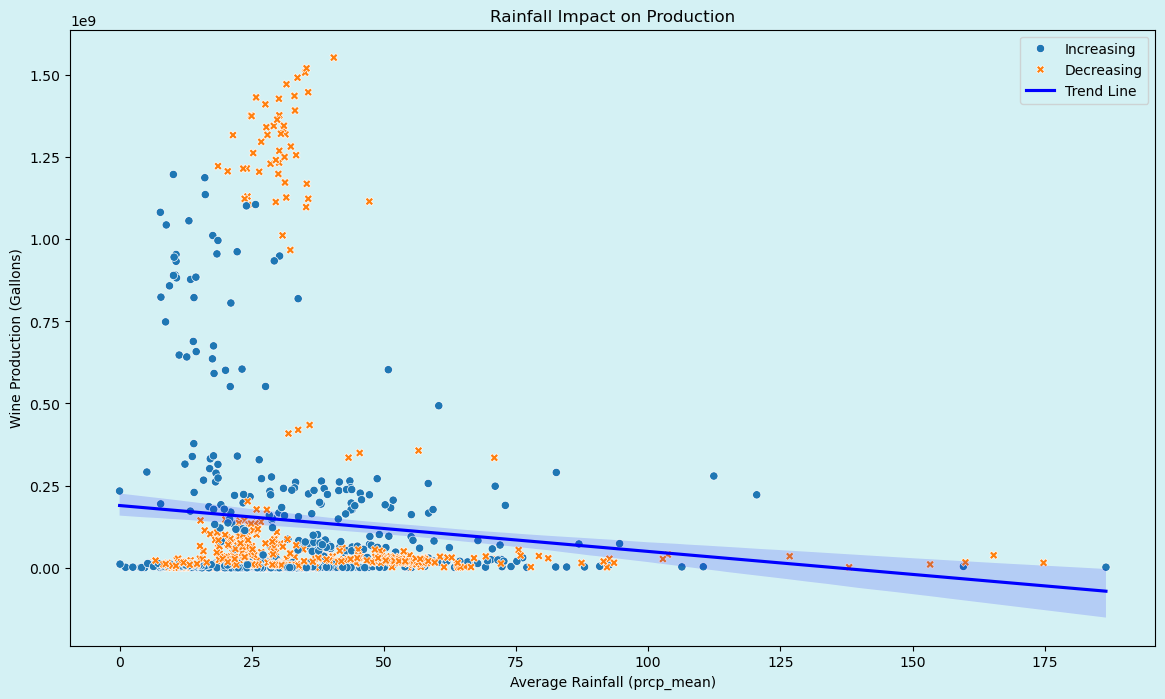

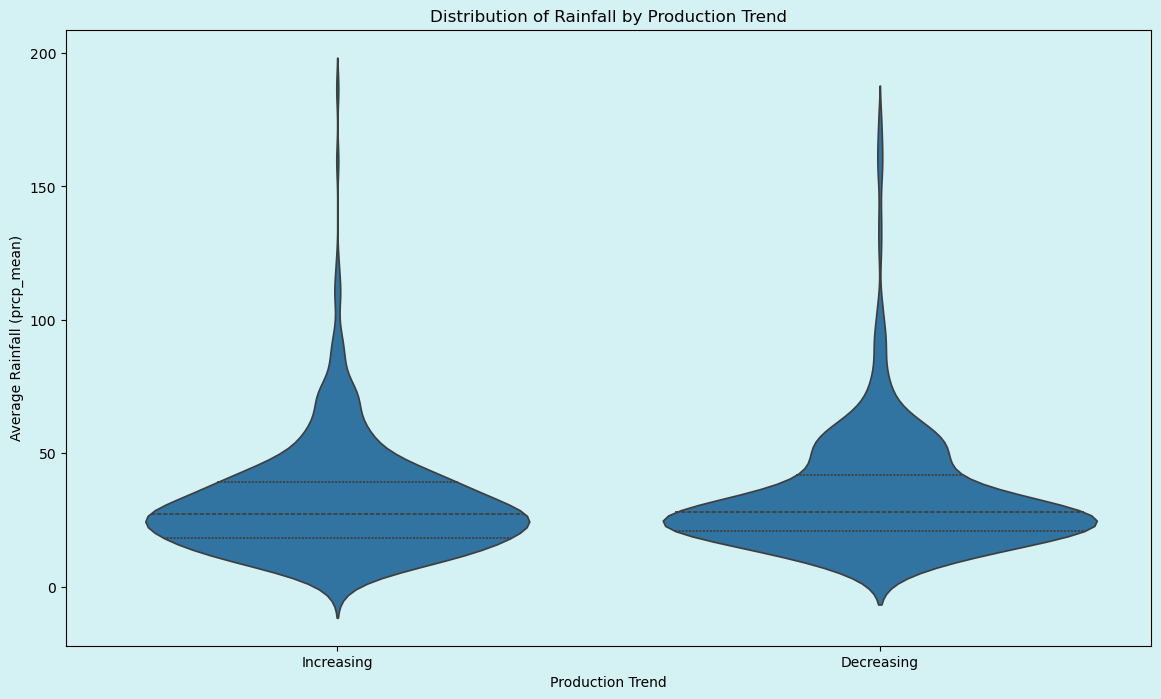

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
data = pd.read_csv(file_path)

# Filter out rows where production data is not available
filtered_data = data.dropna(subset=['Gallons'])

# Ensure the data is sorted by year
filtered_data = filtered_data.sort_values(by=['country', 'year'])

# Calculate the mean production by country and year
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()

# Calculate the change in production for each country
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Remove countries with essentially zero production
non_zero_production_countries = mean_production.groupby('country')['Gallons'].mean()
non_zero_production_countries = non_zero_production_countries[non_zero_production_countries > 0].index

filtered_data = filtered_data[filtered_data['country'].isin(non_zero_production_countries)]

# Recalculate production changes
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Separate countries into those with increasing production and those with decreasing/stopped production
increasing_production_countries = mean_production.groupby('country')['production_change'].sum()
increasing_production_countries = increasing_production_countries[increasing_production_countries > 0].index

decreasing_production_countries = mean_production.groupby('country')['production_change'].sum()
decreasing_production_countries = decreasing_production_countries[decreasing_production_countries <= 0].index

# Filter data for these countries
increasing_data = filtered_data[filtered_data['country'].isin(increasing_production_countries)]
decreasing_data = filtered_data[filtered_data['country'].isin(decreasing_production_countries)]

# Define the climate factors
climate_factors_mean = ['dp10_mean', 'dp1x_mean', 'dt32_mean', 'mnpn_mean', 'mxpn_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']

# Remove columns with no observed values
valid_climate_factors = [col for col in climate_factors_mean if col in filtered_data.columns and filtered_data[col].notna().any()]

# Function to impute missing data and normalize
def impute_and_normalize(data):
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    # Debug: Print initial shape of data
    print("Initial data shape:", data.shape)
    
    # Impute missing values
    imputed_data = imputer.fit_transform(data[valid_climate_factors + ['Gallons']])
    
    # Debug: Print shape after imputation
    print("Shape after imputation:", imputed_data.shape)
    
    # Normalize data
    normalized_data = scaler.fit_transform(imputed_data)
    
    # Debug: Print shape after normalization
    print("Shape after normalization:", normalized_data.shape)
    
    # Convert back to DataFrame
    normalized_df = pd.DataFrame(normalized_data, columns=valid_climate_factors + ['Gallons'], index=data.index)
    
    # Ensure all original columns are retained
    for col in data.columns.difference(valid_climate_factors + ['Gallons']):
        normalized_df[col] = data[col]
    
    # Debug: Print final shape of normalized DataFrame
    print("Final normalized data shape:", normalized_df.shape)
    
    return normalized_df

# Impute and normalize the data
normalized_increasing_data = impute_and_normalize(increasing_data.copy())
normalized_decreasing_data = impute_and_normalize(decreasing_data.copy())

# Function to calculate correlation between production and climate factors
def calculate_correlations(data):
    correlations = data.groupby('country')[valid_climate_factors + ['Gallons']].corr().unstack()
    return correlations

increasing_correlations = calculate_correlations(normalized_increasing_data)
decreasing_correlations = calculate_correlations(normalized_decreasing_data)

# Extract correlation values for 'Gallons'
increasing_corr_values = increasing_correlations.xs('Gallons', level=1, axis=1) if not increasing_correlations.empty else pd.DataFrame()
decreasing_corr_values = decreasing_correlations.xs('Gallons', level=1, axis=1) if not decreasing_correlations.empty else pd.DataFrame()

# Filter significant correlations
significant_threshold = 0.5
top_increasing_correlations = increasing_corr_values.abs()[increasing_corr_values.abs() > significant_threshold].index if not increasing_corr_values.empty else []
top_decreasing_correlations = decreasing_corr_values.abs()[decreasing_corr_values.abs() > significant_threshold].index if not decreasing_corr_values.empty else []

# Combine top factors from both increasing and decreasing production countries
top_factors = list(set(top_increasing_correlations).union(set(top_decreasing_correlations)))

# Ensure top factors are actually climate factors
top_factors = [factor for factor in top_factors if factor in filtered_data.columns]

# Debug: Print top correlated factors
print("Top Correlated Factors:\n", top_factors)

# Remove rows with missing values in top factors
filtered_data_cleaned = filtered_data.dropna(subset=top_factors)

# Debug: Print cleaned data head
print("Cleaned Data Head:\n", filtered_data_cleaned.head())

# Create a column to label whether production is increasing or decreasing/stopped
filtered_data_cleaned['production_trend'] = filtered_data_cleaned['country'].apply(
    lambda x: 'Increasing' if x in increasing_production_countries else 'Decreasing'
)

# Debug: Print the unique values in the 'production_trend' column
print("Production Trend Column Unique Values:", filtered_data_cleaned['production_trend'].unique())

# Plot scatter plots with regression lines for rainfall impact on production
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_data_cleaned, x='prcp_mean', y='Gallons', hue='production_trend', style='production_trend')
sns.regplot(data=filtered_data_cleaned, x='prcp_mean', y='Gallons', scatter=False, color='blue', label='Trend Line')
plt.title('Rainfall Impact on Production')
plt.xlabel('Average Rainfall (prcp_mean)')
plt.ylabel('Wine Production (Gallons)')
plt.legend()
plt.show()

# Plot violin plot for rainfall distribution across production trends
plt.figure(figsize=(14, 8))
sns.violinplot(x='production_trend', y='prcp_mean', data=filtered_data_cleaned, inner='quartile')
plt.title('Distribution of Rainfall by Production Trend')
plt.xlabel('Production Trend')
plt.ylabel('Average Rainfall (prcp_mean)')
plt.show()


Initial data shape: (999, 33)
Shape after imputation: (999, 7)
Shape after normalization: (999, 7)
Final normalized data shape: (999, 33)
Initial data shape: (932, 33)
Shape after imputation: (932, 7)
Shape after normalization: (932, 7)
Final normalized data shape: (932, 33)
Top Correlated Factors:
 []
Cleaned Data Head:
     country  year  Quantity_hl    Gallons code  dp10_mean  dp10_std  \
28  Albania  1995        169.0  4464506.8   AL       97.0       NaN   
29  Albania  1996        293.0  7740239.6   AL      101.0       NaN   
30  Albania  1997        168.0  4438089.6   AL       70.0       NaN   
31  Albania  1998        105.0  2773806.0   AL        NaN       NaN   
32  Albania  1999        127.0  3354984.4   AL       91.0       NaN   

    dp1x_mean  dp1x_std  dt32_mean  ...  mnpn_mean  mnpn_std  mxpn_mean  \
28       29.0       NaN        NaN  ...        NaN       NaN        NaN   
29       30.0       NaN        NaN  ...        NaN       NaN        NaN   
30       16.0       NaN 

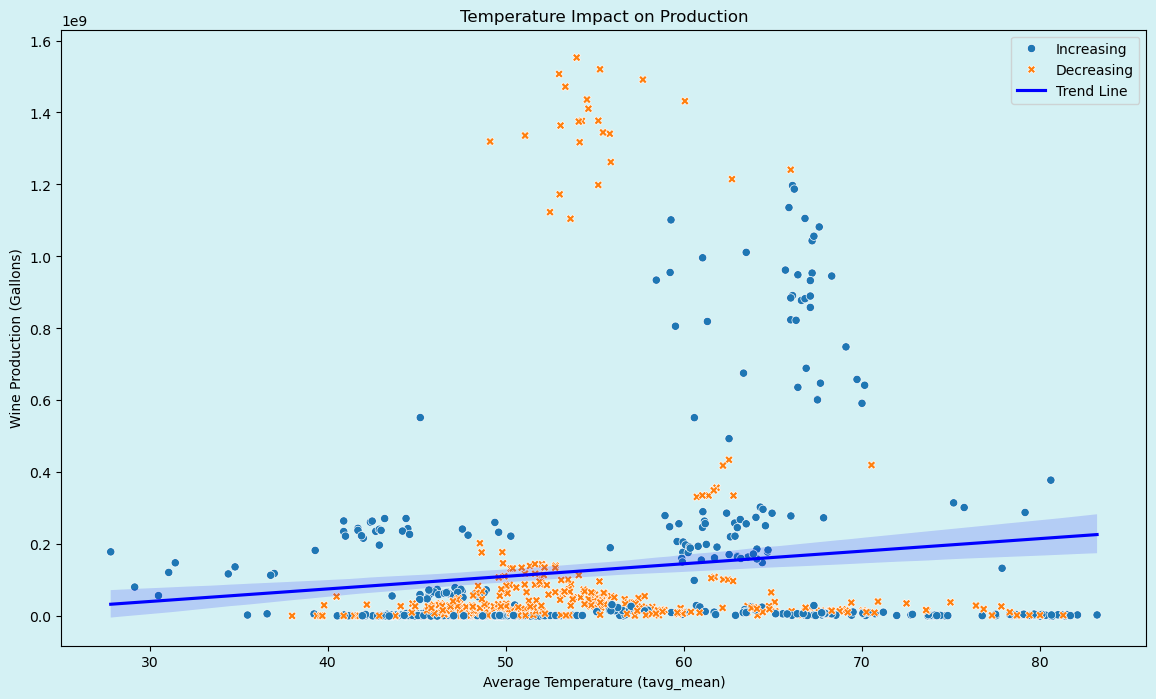

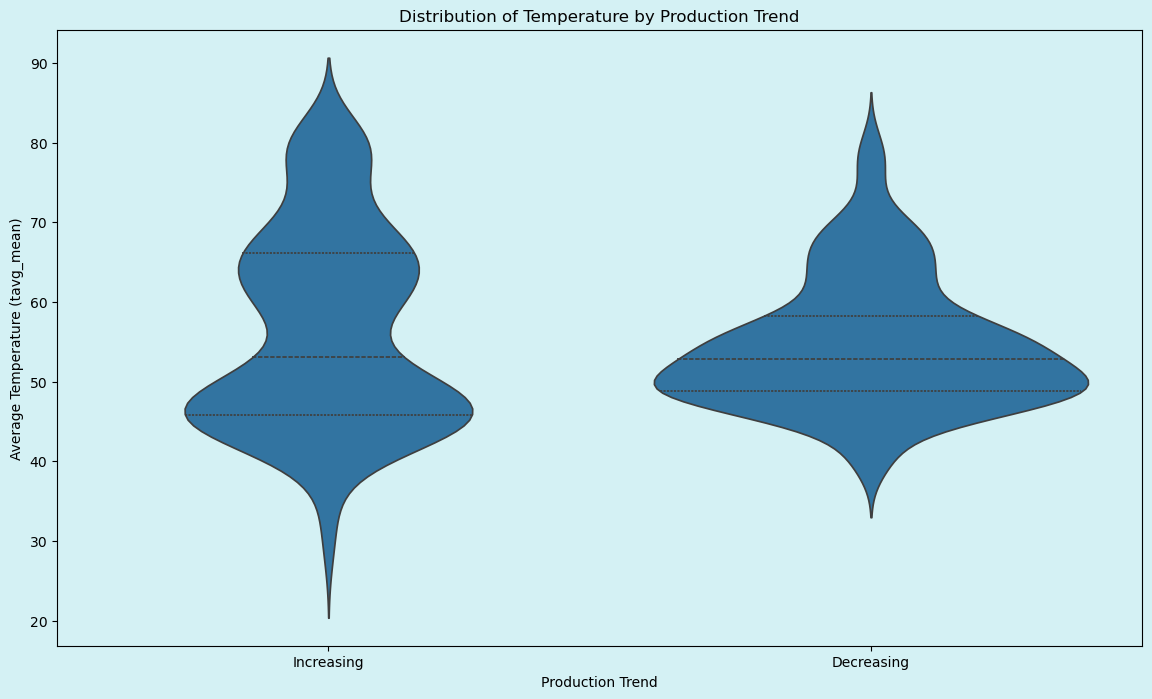

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
data = pd.read_csv(file_path)

# Filter out rows where production data is not available
filtered_data = data.dropna(subset=['Gallons'])

# Ensure the data is sorted by year
filtered_data = filtered_data.sort_values(by=['country', 'year'])

# Calculate the mean production by country and year
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()

# Calculate the change in production for each country
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Remove countries with essentially zero production
non_zero_production_countries = mean_production.groupby('country')['Gallons'].mean()
non_zero_production_countries = non_zero_production_countries[non_zero_production_countries > 0].index

filtered_data = filtered_data[filtered_data['country'].isin(non_zero_production_countries)]

# Recalculate production changes
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Separate countries into those with increasing production and those with decreasing/stopped production
increasing_production_countries = mean_production.groupby('country')['production_change'].sum()
increasing_production_countries = increasing_production_countries[increasing_production_countries > 0].index

decreasing_production_countries = mean_production.groupby('country')['production_change'].sum()
decreasing_production_countries = decreasing_production_countries[decreasing_production_countries <= 0].index

# Filter data for these countries
increasing_data = filtered_data[filtered_data['country'].isin(increasing_production_countries)]
decreasing_data = filtered_data[filtered_data['country'].isin(decreasing_production_countries)]

# Define the climate factors
climate_factors_mean = ['dp10_mean', 'dp1x_mean', 'dt32_mean', 'mnpn_mean', 'mxpn_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']

# Remove columns with no observed values
valid_climate_factors = [col for col in climate_factors_mean if col in filtered_data.columns and filtered_data[col].notna().any()]

# Function to impute missing data and normalize
def impute_and_normalize(data):
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    # Debug: Print initial shape of data
    print("Initial data shape:", data.shape)
    
    # Impute missing values
    imputed_data = imputer.fit_transform(data[valid_climate_factors + ['Gallons']])
    
    # Debug: Print shape after imputation
    print("Shape after imputation:", imputed_data.shape)
    
    # Normalize data
    normalized_data = scaler.fit_transform(imputed_data)
    
    # Debug: Print shape after normalization
    print("Shape after normalization:", normalized_data.shape)
    
    # Convert back to DataFrame
    normalized_df = pd.DataFrame(normalized_data, columns=valid_climate_factors + ['Gallons'], index=data.index)
    
    # Ensure all original columns are retained
    for col in data.columns.difference(valid_climate_factors + ['Gallons']):
        normalized_df[col] = data[col]
    
    # Debug: Print final shape of normalized DataFrame
    print("Final normalized data shape:", normalized_df.shape)
    
    return normalized_df

# Impute and normalize the data
normalized_increasing_data = impute_and_normalize(increasing_data.copy())
normalized_decreasing_data = impute_and_normalize(decreasing_data.copy())

# Function to calculate correlation between production and climate factors
def calculate_correlations(data):
    correlations = data.groupby('country')[valid_climate_factors + ['Gallons']].corr().unstack()
    return correlations

increasing_correlations = calculate_correlations(normalized_increasing_data)
decreasing_correlations = calculate_correlations(normalized_decreasing_data)

# Extract correlation values for 'Gallons'
increasing_corr_values = increasing_correlations.xs('Gallons', level=1, axis=1) if not increasing_correlations.empty else pd.DataFrame()
decreasing_corr_values = decreasing_correlations.xs('Gallons', level=1, axis=1) if not decreasing_correlations.empty else pd.DataFrame()

# Filter significant correlations
significant_threshold = 0.5
top_increasing_correlations = increasing_corr_values.abs()[increasing_corr_values.abs() > significant_threshold].index if not increasing_corr_values.empty else []
top_decreasing_correlations = decreasing_corr_values.abs()[decreasing_corr_values.abs() > significant_threshold].index if not decreasing_corr_values.empty else []

# Combine top factors from both increasing and decreasing production countries
top_factors = list(set(top_increasing_correlations).union(set(top_decreasing_correlations)))

# Ensure top factors are actually climate factors
top_factors = [factor for factor in top_factors if factor in filtered_data.columns]

# Debug: Print top correlated factors
print("Top Correlated Factors:\n", top_factors)

# Remove rows with missing values in top factors
filtered_data_cleaned = filtered_data.dropna(subset=top_factors)

# Debug: Print cleaned data head
print("Cleaned Data Head:\n", filtered_data_cleaned.head())

# Create a column to label whether production is increasing or decreasing/stopped
filtered_data_cleaned['production_trend'] = filtered_data_cleaned['country'].apply(
    lambda x: 'Increasing' if x in increasing_production_countries else 'Decreasing'
)

# Debug: Print the unique values in the 'production_trend' column
print("Production Trend Column Unique Values:", filtered_data_cleaned['production_trend'].unique())

# Plot scatter plots with regression lines for temperature impact on production
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_data_cleaned, x='tavg_mean', y='Gallons', hue='production_trend', style='production_trend')
sns.regplot(data=filtered_data_cleaned, x='tavg_mean', y='Gallons', scatter=False, color='blue', label='Trend Line')
plt.title('Temperature Impact on Production')
plt.xlabel('Average Temperature (tavg_mean)')
plt.ylabel('Wine Production (Gallons)')
plt.legend()
plt.show()

# Plot violin plot for temperature distribution across production trends
plt.figure(figsize=(14, 8))
sns.violinplot(x='production_trend', y='tavg_mean', data=filtered_data_cleaned, inner='quartile')
plt.title('Distribution of Temperature by Production Trend')
plt.xlabel('Production Trend')
plt.ylabel('Average Temperature (tavg_mean)')
plt.show()
